# References
https://gymnasium.farama.org/environments/toy_text/

https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py

In [9]:
import sys
import pickle
import random
import contextlib
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [10]:
# -----------------------------------------------------
#   Object class: Represents entities in the grid.
# -----------------------------------------------------
class Object:
    def __init__(self, type, x, y):
        self.type = type
        self.x = x
        self.y = y
        self.symbol = self.assign_symbol()
        self.point = 0
        self.assign_point()
    
    def get_position(self):
        return self.x, self.y
    
    def move(self, dx, dy):
        self.x += dx
        self.y += dy
    
    def is_drone_allowed(self):
        return getattr(self, 'drone_flyable', True)
    
    def assign_point(self):  
        points = {
            'drone': 0,
            'package_1': 25,
            'package_2': 25,
            'bird': -50,      
            'wind_up': -10,    
            'wind_down': -10,
            'wind_right': -10,
            'wind_left': -10,
            'tornado': -100,
            'destination_1': 100,
            'destination_2': 100 
        }
        self.point = points.get(self.type, 0)
        
    def assign_symbol(self):
        symbols = {
            'drone': '🚁',
            'package_1': '🎁',
            'package_2': '📦',
            'bird': '🦅',
            'wind_up': '⬆️',
            'wind_down': '⬇️',
            'wind_right': '➡️',
            'wind_left': '⬅️',
            'tornado': '🌪️',
            'destination_1': '🏠',
            'destination_2': '🛖',
            'package_delivered': '✅'
        }
        return symbols.get(self.type, '❓')
    
    @staticmethod
    def print_points():
        points = {
            'drone': 0,
            'package_1': 25,
            'package_2': 25,
            'bird': -50,      
            'wind_up': -10,    
            'wind_down': -10,
            'wind_right': -10,
            'wind_left': -10,
            'tornado': -100,
            'destination_1': 100,
            'destination_2': 100,
        }
        print("Object Type | Points")
        print("--------------------")
        for obj_type, point in points.items():
            print(f"{obj_type.ljust(12)} | {point}")


In [11]:

# ----------------------------------------------------------------------------------------------------------
#   Environment class: Contains the grid, drone, packages,obstacles, and logging/rendering methods.
# ----------------------------------------------------------------------------------------------------------
class Environment:
    def __init__(self, drone_position_x=0, drone_position_y=0, cols=6, rows=6, stochastic=False):
        self.total_reward = 0
        self.rows = rows
        self.cols = cols
        self.stochastic = stochastic
        self.empty = '⬜'
        self.package_delivered_1 = False
        self.package_delivered_2 = False
        self.package_picked_1 = False
        self.package_picked_2 = False
        self.once_package_picked_1 = False
        self.once_package_picked_2 = False
        self.terminal = False
        self.reset_env()

    def reset_env(self):
        self.package_delivered_1 = False
        self.package_delivered_2 = False
        self.package_picked_1 = False
        self.package_picked_2 = False
        self.total_reward = 0
        self.grid = [[self.empty for _ in range(self.cols)] for _ in range(self.rows)]
        self.init_positions()   # Initialize drone, packages, and destinations.
        self.init_obstacles()    # Add tornado, winds, and birds.
        self.terminal = False

    def init_positions(self):
        used = set()
        def get_pos():
            while True:
                pos = (random.randint(0, self.rows - 1), random.randint(0, self.cols - 1))
                if pos not in used:
                    used.add(pos)
                    return pos
        if self.stochastic:
            drone_pos = get_pos()
            pkg1_pos  = get_pos()
            dest1_pos = get_pos()
            pkg2_pos  = get_pos()
            dest2_pos = get_pos()
        else:
            drone_pos = (0, 0)
            pkg1_pos  = (2, 2)
            dest1_pos = (5, 5)
            pkg2_pos  = (4, 1)
            dest2_pos = (0, 5)
        self.drone = Object('drone', drone_pos[0], drone_pos[1])
        self.package_1 = Object('package_1', pkg1_pos[0], pkg1_pos[1])
        self.destination_1 = Object('destination_1', dest1_pos[0], dest1_pos[1])
        self.package_2 = Object('package_2', pkg2_pos[0], pkg2_pos[1])
        self.destination_2 = Object('destination_2', dest2_pos[0], dest2_pos[1])
        # Save delivery positions to avoid overlaps with obstacles.
        self.delivery_positions = {drone_pos, pkg1_pos, dest1_pos, pkg2_pos, dest2_pos}

    def init_obstacles(self):
        # Start with delivery-related objects.
        self.object_positions = [self.destination_1, self.package_1, self.destination_2, self.package_2]
        # Place tornado (and its winds) avoiding delivery positions.
        if self.stochastic:
            while True:
                x = random.randint(1, self.rows - 2)
                y = random.randint(1, self.cols - 2)
                if (x, y) not in self.delivery_positions:
                    break
        else:
            x, y = 3, 3
        self.tornado = Object('tornado', x, y)
        wind_up    = Object('wind_up', x + 1, y)
        wind_down  = Object('wind_down', x - 1, y)
        wind_right = Object('wind_right', x, y - 1)
        wind_left  = Object('wind_left', x, y + 1)
        # Place two birds.
        if self.stochastic:
            birds = []
            for _ in range(2):
                while True:
                    bx = random.randint(0, self.rows - 1)
                    by = random.randint(0, self.cols - 1)
                    if (bx, by) not in self.delivery_positions:
                        birds.append(Object('bird', bx, by))
                        break
            bird_1, bird_2 = birds[0], birds[1]
        else:
            bird_1 = Object('bird', 5, 1)
            bird_2 = Object('bird', 1, 5)
        self.object_positions.extend([
            bird_1, bird_2,
            self.tornado, wind_up, wind_down, wind_right, wind_left,
            self.drone
        ])
        self.update_grid()

    def update_grid(self):
        # Rebuild grid and place each object's symbol.
        self.grid = [[self.empty for _ in range(self.cols)] for _ in range(self.rows)]
        for obj in self.object_positions:
            if 0 <= obj.x < self.rows and 0 <= obj.y < self.cols and obj.type != 'drone':
                self.grid[obj.x][obj.y] = obj.symbol
        self.grid[self.drone.x][self.drone.y] = self.drone.symbol

    def render(self, instant=True):
        for row in self.grid:
            print(" ".join(row))
        print()

    def print_positions(self):
        for obj in self.object_positions:
            print(f"{obj.type}: ({obj.x}, {obj.y})")

    def update_drone_position(self):
        for obj in self.object_positions:
            if obj.type == 'drone':
                obj.x, obj.y = self.drone.x, self.drone.y

    def update_tornado_positions(self):
        if self.stochastic:
            if random.choice([True, False]):
                dx = random.choice([-1, 1])
                new_x = self.tornado.x + dx
                if 1 <= new_x <= self.rows - 2:
                    self.tornado.x = new_x
            else:
                dy = random.choice([-1, 1])
                new_y = self.tornado.y + dy
                if 1 <= new_y <= self.cols - 2:
                    self.tornado.y = new_y
        else:
            self.tornado.x, self.tornado.y = 3, 3
        for obj in self.object_positions:
            if obj.type == 'tornado':
                obj.x, obj.y = self.tornado.x, self.tornado.y
            elif obj.type == 'wind_up':
                obj.x, obj.y = self.tornado.x + 1, self.tornado.y
            elif obj.type == 'wind_down':
                obj.x, obj.y = self.tornado.x - 1, self.tornado.y
            elif obj.type == 'wind_right':
                obj.x, obj.y = self.tornado.x, self.tornado.y + 1
            elif obj.type == 'wind_left':
                obj.x, obj.y = self.tornado.x, self.tornado.y - 1

    def update_no_fly_zones(self):
        if self.stochastic:
            birds = [obj for obj in self.object_positions if obj.type == 'bird']
            for bird in birds:
                if random.random() < 0.0:
                    self.object_positions.remove(bird)
                    empties = [(i, j) for i in range(self.rows) for j in range(self.cols)
                               if self.grid[i][j] == self.empty]
                    if empties:
                        pos = random.choice(empties)
                        self.object_positions.append(Object('bird', pos[0], pos[1]))

    def check_reward(self, x, y):
        # If the drone lands on an obstacle.
        for obj in self.object_positions:
            if obj.x == x and obj.y == y and obj.type in ['tornado', 'wind_up', 'wind_down', 'wind_right', 'wind_left', 'bird']:
                return obj.point
        return -2

    def attempt_pickup(self, print_log=False):
        reward = 0
        # Package 1 pickup.
        if (not self.package_picked_1 and not self.package_delivered_1 and 
            (self.drone.x, self.drone.y) == (self.package_1.x, self.package_1.y)):
            self.package_picked_1 = True
            reward += 25
            if self.package_1 in self.object_positions:
                self.object_positions.remove(self.package_1)
            if print_log:
                print(f"Picked up package 1 for {reward} reward")
        # Package 2 pickup.
        elif (not self.package_picked_2 and not self.package_delivered_2 and 
              (self.drone.x, self.drone.y) == (self.package_2.x, self.package_2.y)):
            self.package_picked_2 = True
            reward += 25
            if self.package_2 in self.object_positions:
                self.object_positions.remove(self.package_2)
            if print_log:
                print(f"Picked up package 2 for {reward} reward")
        else:
            reward = -25
            if print_log:
                print(f"Attempted pickup failed. Penalty {reward}")
        self.package_status()
        return reward

    def attempt_dropoff(self, print_log=False):
        reward = 0
        dropped_any_overall = False
        # Package 1 dropoff.
        delta, dropped = self.handle_dropoff('package_1', 'package_picked_1', 'package_delivered_1', self.destination_1, print_log)
        reward += delta
        if dropped:
            dropped_any_overall = True
        # Package 2 dropoff.
        delta, dropped = self.handle_dropoff('package_2', 'package_picked_2', 'package_delivered_2', self.destination_2, print_log)
        reward += delta
        if dropped:
            dropped_any_overall = True
        if not dropped_any_overall:
            reward -= 50
            if print_log:
                print(f"Attempted dropoff failed (no package carried). Penalty {reward}")
        if self.package_delivered_1 and self.package_delivered_2:
            self.terminal = True
            if print_log:
                print("Task complete: All packages delivered 😎")
        self.package_status()
        self.update_grid()
        return reward

    def handle_dropoff(self, package_name, package_picked, package_delivered, destination, print_log=False):
        reward_delta = 0
        dropped = False
        if getattr(self, package_picked):
            dropped = True
            if (self.drone.x, self.drone.y) == (destination.x, destination.y):
                setattr(self, package_delivered, True)
                setattr(self, package_picked, False)
                destination.symbol = Object('package_delivered', 0, 0).symbol
                reward_delta += 100
                if print_log:
                    print(f"Delivered {package_name} for +100 reward")
            else:
                setattr(self, package_picked, False)
                reward_delta -= 50
                new_package = Object(package_name, self.drone.x, self.drone.y)
                self.object_positions.append(new_package)
                setattr(self, package_name, new_package)
                if print_log:
                    print(f"Dropped {package_name} incorrectly. Penalty {reward_delta}")
        return reward_delta, dropped

    def move_drone(self, dx, dy, render_env=False, print_log=False):
        if self.task_complete():
            return 0, True
        new_x = self.drone.x + dx
        new_y = self.drone.y + dy
        if 0 <= new_x < self.rows and 0 <= new_y < self.cols:
            self.grid[self.drone.x][self.drone.y] = self.empty
            self.update_tornado_positions()
            self.update_no_fly_zones()
            self.drone.x, self.drone.y = new_x, new_y
            self.update_drone_position()
            rwd = self.check_reward(new_x, new_y)
            self.update_grid()
            if print_log:
                print(f"Drone moved to ({new_x}, {new_y}). Step reward: {rwd}")
                self.package_status()
            if render_env:
                self.render()
            return rwd, self.task_complete()
        else:
            if print_log:
                print("Move attempted out of grid boundaries. Penalty -25")
            return -25, self.task_complete()

    def step(self, action, render_env=False, print_log=False):
        if self.task_complete():
            return 0, True
        if action in [0, 1, 2, 3]:
            dx, dy = self.action_to_delta(action)
            rwd, done = self.move_drone(dx, dy, render_env, print_log)
        elif action == 4:
            rwd = self.attempt_pickup(print_log)
            done = self.task_complete()
        elif action == 5:
            rwd = self.attempt_dropoff(print_log)
            done = self.task_complete()
        else:
            rwd = -5
            done = self.task_complete()
        self.total_reward += rwd
        return rwd, done

    def package_status(self):
        # Aggregated package status message.
        status = f"P1 - Picked: {self.package_picked_1}, Delivered: {self.package_delivered_1} | " \
                 f"P2 - Picked: {self.package_picked_2}, Delivered: {self.package_delivered_2}"
        # Uncomment the next line to see detailed package status at every step.
        # print(status)

    def task_complete(self):
        return self.terminal

    # Convenience wrappers for movement.
    def drone_move_left(self, render_env=False, print_log=False):
        return self.step(0, render_env, print_log)

    def drone_move_right(self, render_env=False, print_log=False):
        return self.step(1, render_env, print_log)

    def drone_move_up(self, render_env=False, print_log=False):
        return self.step(2, render_env, print_log)

    def drone_move_down(self, render_env=False, print_log=False):
        return self.step(3, render_env, print_log)

    def random_drone_movement(self, steps=100):
        actions = [0, 1, 2, 3, 4, 5]
        for _ in range(steps):
            action = random.choice(actions)
            rwd, done = self.step(action, render_env=False, print_log=False)
            self.total_reward += rwd
            if self.task_complete():
                break

    def action_to_delta(self, action):
        if action == 0:
            return -1, 0
        elif action == 1:
            return 1, 0
        elif action == 2:
            return 0, -1
        elif action == 3:
            return 0, 1


In [12]:
# -----------------------------------------------------
#   Helper functions for Q-learning
# -----------------------------------------------------

def get_sensor_reading(env):
    """
    This function helps me get information about the 3x3 surroundings of the drone. 
    It returns a tuple with multiple values. If a value is -1, it represents a negative obstacle 
    that the drone must avoid. Otherwise, the value corresponds to an object type, which the drone 
    will use to differentiate between obstacles and navigate accordingly.
    """
    sensor = []
    x, y = env.drone.x, env.drone.y

    # Iterating over the 3x3 neighborhood of the drone.
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < env.rows and 0 <= ny < env.cols:
                cell_value = 0  # Default value indicating an empty space.

                # Checking if there is any non-drone object in the cell.
                for obj in env.object_positions:
                    if (obj.x, obj.y) == (nx, ny) and obj.type != 'drone':
                        if obj.type in ['tornado', 'wind_up', 'wind_down', 'wind_right', 'wind_left', 'bird']:
                            cell_value = -1  # Marking it as an obstacle that must be avoided.
                            break
                        else:
                            cell_value = obj.type  # Assigning the object type.

                sensor.append(cell_value)
            else:
                sensor.append(-1)  # Marking out-of-bounds cells as obstacles.
    
    return tuple(sensor)


def get_state(env: Environment):
    """
    Returns an augmented state consisting of:
      - Drone's current (x, y) position.
      - Package status: 0 (not picked), 1 (picked), 2 (delivered) for package 1 and 2.
      - Sensor readings: a tuple of 8 values for the adjacent cells.
    """
    p1 = 2 if env.package_delivered_1 else (1 if env.package_picked_1 else 0)
    p2 = 2 if env.package_delivered_2 else (1 if env.package_picked_2 else 0)
    if env.stochastic:
        sensor = get_sensor_reading(env)
        return (env.drone.x, env.drone.y,p1, p2) + sensor
    return (env.drone.x, env.drone.y,p1, p2)

def default_q():
    return np.zeros(6)


In [13]:

# -----------------------------------------------------
#   Q-Learning Agent for Deterministic Environment 
# -----------------------------------------------------

def train_agent_deterministic_Q(env, hyperparams, render=False):
    """
    This function trains a Q-learning agent in a deterministic environment.
    I'm using an epsilon-greedy strategy for action selection, with epsilon 
    decaying over time to gradually shift from exploration to exploitation.
    """
    
    filename = "part_2_files/train_agent_deterministic_Q_console_output.txt"

    # Extracting hyperparameters with default values.
    alpha = hyperparams.get('alpha', 0.1)  # Learning rate
    gamma = hyperparams.get('gamma', 0.95)  # Discount factor
    epsilon = hyperparams.get('epsilon', 1.0)  # Initial exploration rate
    epsilon_decay = hyperparams.get('epsilon_decay', 0.995)  # Epsilon decay rate
    epsilon_min = hyperparams.get('epsilon_min', 0.01)  # Minimum epsilon value
    episodes = hyperparams.get('episodes', 500)  # Number of training episodes
    max_steps = hyperparams.get('max_steps', 100)  # Max steps per episode

    # Initializing the Q-table with six possible actions per state.
    Q = defaultdict(default_q)

    rewards_per_episode = []  # Tracking rewards per episode
    eps_history = []  # Tracking epsilon values over time

    total_successful_delivery_count = 0  # Tracking successful deliveries
    success_in_last_100 = 0  # Tracking recent success rates

    # Redirecting console output to a file for later analysis.
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()  # Resetting the environment at the start of each episode
                state = get_state(env)  # Getting the initial state of the drone
                total_reward = 0  # Keeping track of total rewards in this episode
                step_count = 0  # Counting steps per episode
                
                print(f"\n--- Training Episode {ep+1} starting ---")

                for step in range(max_steps):
                    safe_actions = [0, 1, 2, 3, 4, 5]  # Defining possible actions

                    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit.
                    if random.random() < epsilon:
                        action = random.choice(safe_actions)  # Random action (exploration)
                    else:
                        q_vals = Q[state]  # Getting Q-values for the current state
                        safe_q = {a: q_vals[a] for a in safe_actions}  # Filtering valid actions
                        action = max(safe_q, key=safe_q.get)  # Choosing the best action (exploitation)
                
                    # Performing the selected action in the environment.
                    reward, done = env.step(action, render_env=render, print_log=True)
                    total_reward += reward  # Updating total reward for this episode
                    next_state = get_state(env)  # Getting the new state after action

                    # Q-learning update: adjusting Q-value based on reward and next state.
                    best_next = np.max(Q[next_state])  # Best Q-value for next state
                    Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])  # Updating Q-table

                    state = next_state  # Moving to the next state
                    step_count += 1  # Incrementing step count
                    
                    # Rendering every 10 steps if rendering is enabled.
                    if render and (step % 10 == 0):
                        print(f"Episode {ep+1} - Step {step+1}")
                        env.render()
                    
                    # Ending the episode if the goal is reached or a failure condition occurs.
                    if done:
                        total_successful_delivery_count += 1
                        success_in_last_100 += 1
                        break

                # Updating epsilon to reduce exploration over time.
                epsilon = max(epsilon * epsilon_decay, epsilon_min)

                # Storing episode results for analysis.
                rewards_per_episode.append(total_reward)
                eps_history.append(epsilon)

                # Logging episode summary.
                print(f"Episode {ep+1}/{episodes} | Steps: {step_count} | Total Reward: {total_reward} | Epsilon: {epsilon:.3f}")

                 # Printing success count every 1,00 episodes.
                if (ep + 1) % 100 == 0:
                    print(
                        f"Episode {ep+1}/{episodes} | Eps: {epsilon:.4f} | Success in last 100: {success_in_last_100} %",
                        file=sys.__stdout__
                    )
                    success_in_last_100 = 0  # Resetting recent success counter

        # Final training summary.
        print(f"Task complete count: {total_successful_delivery_count} \n")

        # Saving the Q-table as a pickle file for later evaluation.
        q_table_filename = "part_2_files/deterministic_q_table.pkl"
        with open(q_table_filename, "wb") as pf:
            pickle.dump(Q, pf)
        print(f"Q-table saved to {q_table_filename}")

        # Returning the trained Q-table, rewards per episode, and epsilon history for further analysis.
        return Q, rewards_per_episode, eps_history

def evaluate_agent_deterministic_Q(env, q_table_filename="part_2_files/deterministic_q_table.pkl", episodes=10, max_steps=100, render=True, final_render_file_name="part_2_files/evaluate_agent_deterministic_Q_console_output.txt"):
    """
    This function evaluates a trained Q-learning agent in a deterministic environment.
    Since the environment is deterministic, the agent will always choose the action 
    with the highest Q-value at each step. I run multiple evaluation episodes to measure
    performance and ensure the policy is working as expected.
    """

    Q = None

    # Loading the Q-table from the pickle file.
    with open(q_table_filename, "rb") as pf:
        Q = pickle.load(pf)  

    rewards = []  # Tracking total rewards per episode

    filename = final_render_file_name  # Output log file
    total_successful_delivery_count = 0  # Tracking successful task completions

    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()  # Resetting the environment at the start of each episode
               
                state = get_state(env)  # Getting the initial state
                total_reward = 0  # Keeping track of total rewards in this episode
                step_count = 0  # Counting steps per episode

                print(f"\n--- Evaluation Episode {ep+1} starting ---")
                env.render()

                for step in range(max_steps):
                    # Since the environment is deterministic, I always pick the best known action.
                    q_vals = Q[state]  # Fetching Q-values for the current state
                    action = int(np.argmax(q_vals))  # Selecting the best action (greedy policy)

                    # Performing the selected action in the environment.
                    reward, done = env.step(action, render_env=render, print_log=True)
                    total_reward += reward  # Updating total reward
                    state = get_state(env)  # Updating state after taking the action
                    step_count += 1  # Incrementing step count

                    # If rendering is enabled, print progress every 10 steps.
                    if render and (step % 10 == 0):
                        print(f"Evaluation Episode {ep+1} - Step {step+1}")
                        # env.render()

                    # If the episode ends (goal reached or failure), stop further steps.
                    if done:
                        total_successful_delivery_count = total_successful_delivery_count + 1
                        break

                # Storing episode rewards for analysis.
                rewards.append(total_reward)

                # Logging episode summary.
                print(f"Evaluation Episode {ep+1}: Steps: {step_count} | Total Reward: {total_reward} \n", file=sys.__stdout__)

    # Final summary of successful task completions.
    print(f"Task complete count: {total_successful_delivery_count} \n")

    # Returning collected rewards for analysis.
    return rewards


In [30]:
# -----------------------------------------------------
#   Training in a deterministic environment
# -----------------------------------------------------

deterministic = True 
env = Environment(0, 0, stochastic=(not deterministic))

# ---- My hyperparameters ----
hyperparams = {
    'alpha': 0.01,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.995,
    'epsilon_min': 0.01,
    'episodes': 10000,
    'max_steps': 1000
}

print("Training a Q-Learning agent ...")

Q_deterministic_Q, rewards_deterministic_Q, eps_history_deterministic_Q = train_agent_deterministic_Q(env, hyperparams, render=True)

Training a Q-Learning agent ...
Episode 100/10000 | Eps: 0.6058 | Success in last 100: 0 %
Episode 200/10000 | Eps: 0.3670 | Success in last 100: 0 %
Episode 300/10000 | Eps: 0.2223 | Success in last 100: 3 %
Episode 400/10000 | Eps: 0.1347 | Success in last 100: 4 %
Episode 500/10000 | Eps: 0.0816 | Success in last 100: 18 %
Episode 600/10000 | Eps: 0.0494 | Success in last 100: 22 %
Episode 700/10000 | Eps: 0.0299 | Success in last 100: 39 %
Episode 800/10000 | Eps: 0.0181 | Success in last 100: 60 %
Episode 900/10000 | Eps: 0.0110 | Success in last 100: 66 %
Episode 1000/10000 | Eps: 0.0100 | Success in last 100: 61 %
Episode 1100/10000 | Eps: 0.0100 | Success in last 100: 64 %
Episode 1200/10000 | Eps: 0.0100 | Success in last 100: 85 %
Episode 1300/10000 | Eps: 0.0100 | Success in last 100: 77 %
Episode 1400/10000 | Eps: 0.0100 | Success in last 100: 83 %
Episode 1500/10000 | Eps: 0.0100 | Success in last 100: 91 %
Episode 1600/10000 | Eps: 0.0100 | Success in last 100: 94 %
Episo

In [34]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename="part_2_files/deterministic_q_table.pkl"

print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

Q = defaultdict(default_q)
for k, v in Q.items():
    print(k, v)

# Loading the Q-table from the pickle file
with open(q_table_filename, "rb") as pf:
    Q = pickle.load(pf)

# Printing the final Q-table
print("\nTrained Q-table (for visited states):\n")
for k, v in Q.items():
    print(k, v)



Initial Q-table (empty entries as I am using a dictionary for easier implementation):

Trained Q-table (for visited states):

(0, 1, 0, 0) [-50.82082401 -24.93623713 -34.35958968 -35.44004116 -49.51511199
 -75.72551685]
(0, 0, 0, 0) [-49.14410106 -35.85036252 -48.71510282 -24.02514819 -48.08687162
 -73.47169144]
(0, 2, 0, 0) [-50.42223551 -35.90545788 -29.55838232 -35.90538869 -50.43207227
 -75.91747989]
(1, 0, 0, 0) [-35.94765025 -35.94742496 -50.61954142 -31.81264251 -48.99438795
 -76.21075632]
(2, 0, 0, 0) [-35.89139025 -35.89027685 -50.86361551 -32.19087963 -49.65371035
 -76.17745373]
(3, 0, 0, 0) [-35.85733808 -35.75021041 -50.95247458 -28.73246571 -48.7238251
 -75.66208296]
(2, 1, 0, 0) [-31.78292545 -25.95764411 -35.43078316 -34.77983982 -47.92039515
 -76.29399607]
(3, 1, 0, 0) [-28.77543701 -13.29540686 -29.8459807  -34.66554567 -42.39159261
 -70.13387612]
(3, 2, 0, 0) [ -31.85927322  -31.88846093  -23.8783443  -108.1468066   -33.60436742
  -58.66146452]
(4, 0, 0, 0) [-35.6586

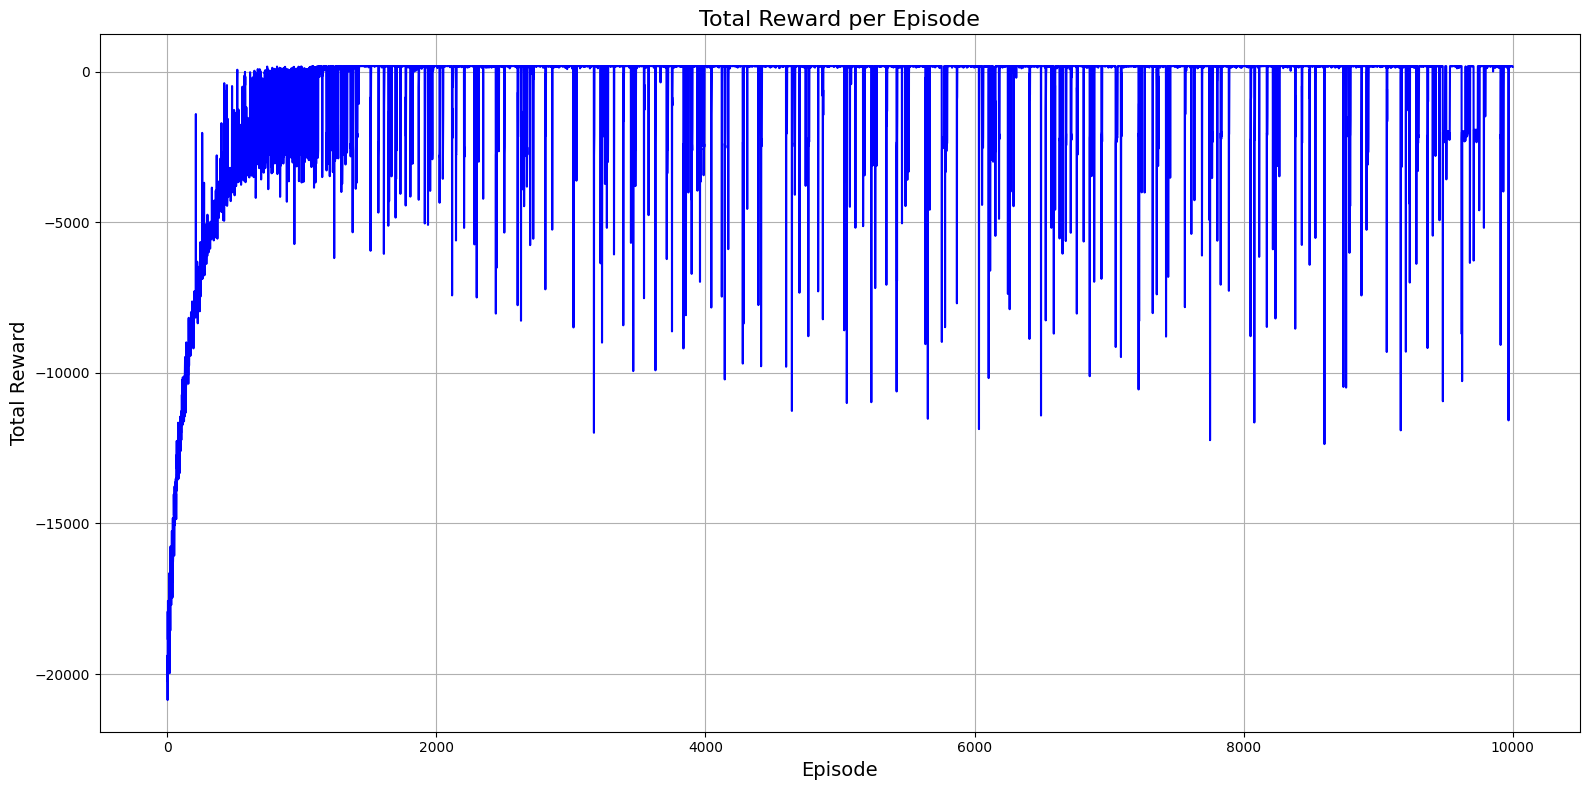

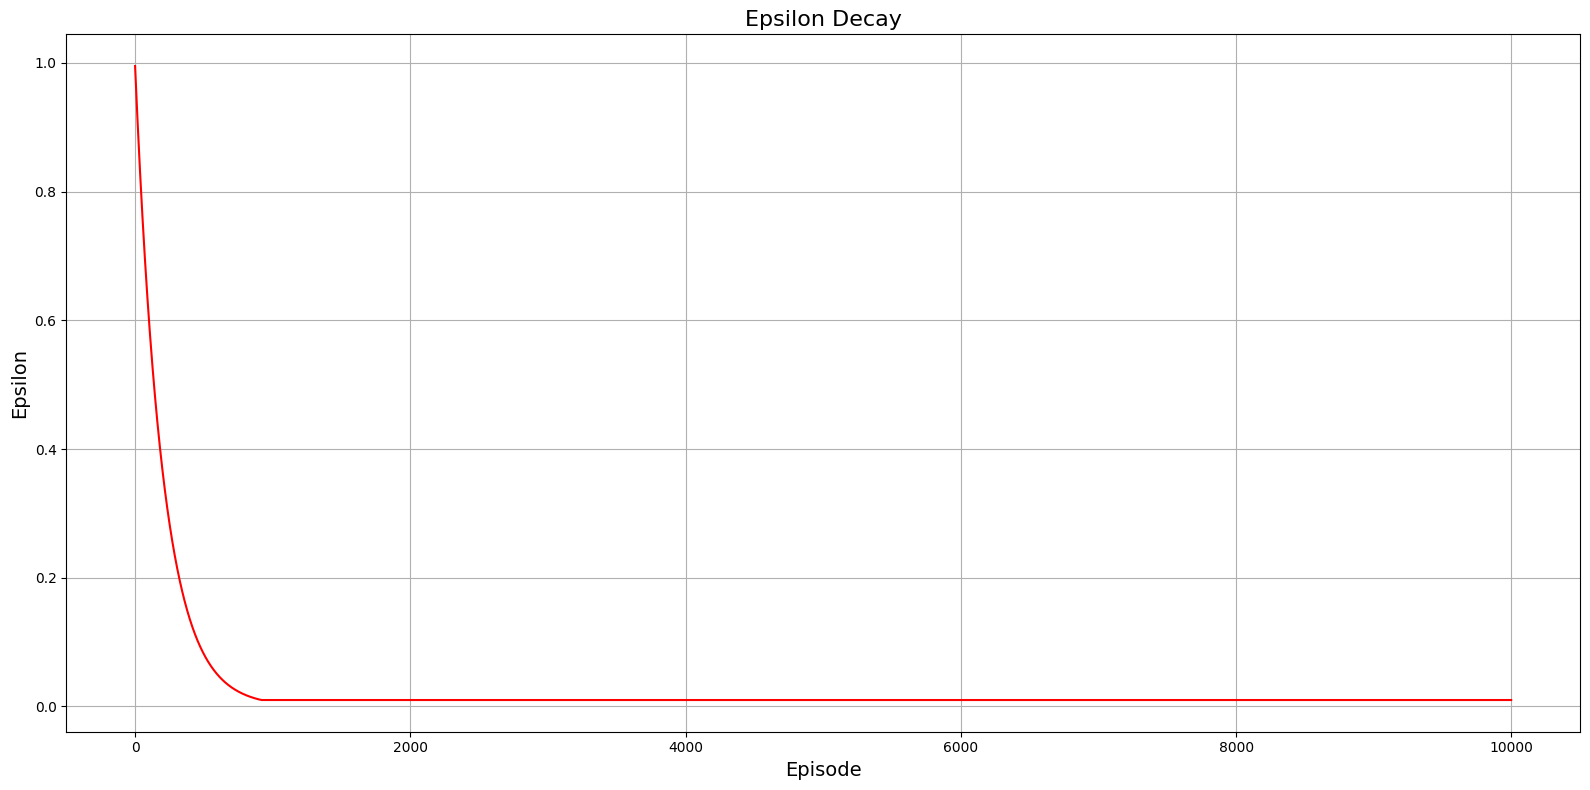

In [33]:
# Plotting the total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_deterministic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_deterministic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation Episode 1: Steps: 25 | Total Reward: 185 

Evaluation Episode 2: Steps: 25 | Total Reward: 185 

Evaluation Episode 3: Steps: 25 | Total Reward: 185 

Evaluation Episode 4: Steps: 25 | Total Reward: 185 

Evaluation Episode 5: Steps: 25 | Total Reward: 185 

Evaluation Episode 6: Steps: 25 | Total Reward: 185 

Evaluation Episode 7: Steps: 25 | Total Reward: 185 

Evaluation Episode 8: Steps: 25 | Total Reward: 185 

Evaluation Episode 9: Steps: 25 | Total Reward: 185 

Evaluation Episode 10: Steps: 25 | Total Reward: 185 

Task complete count: 10 



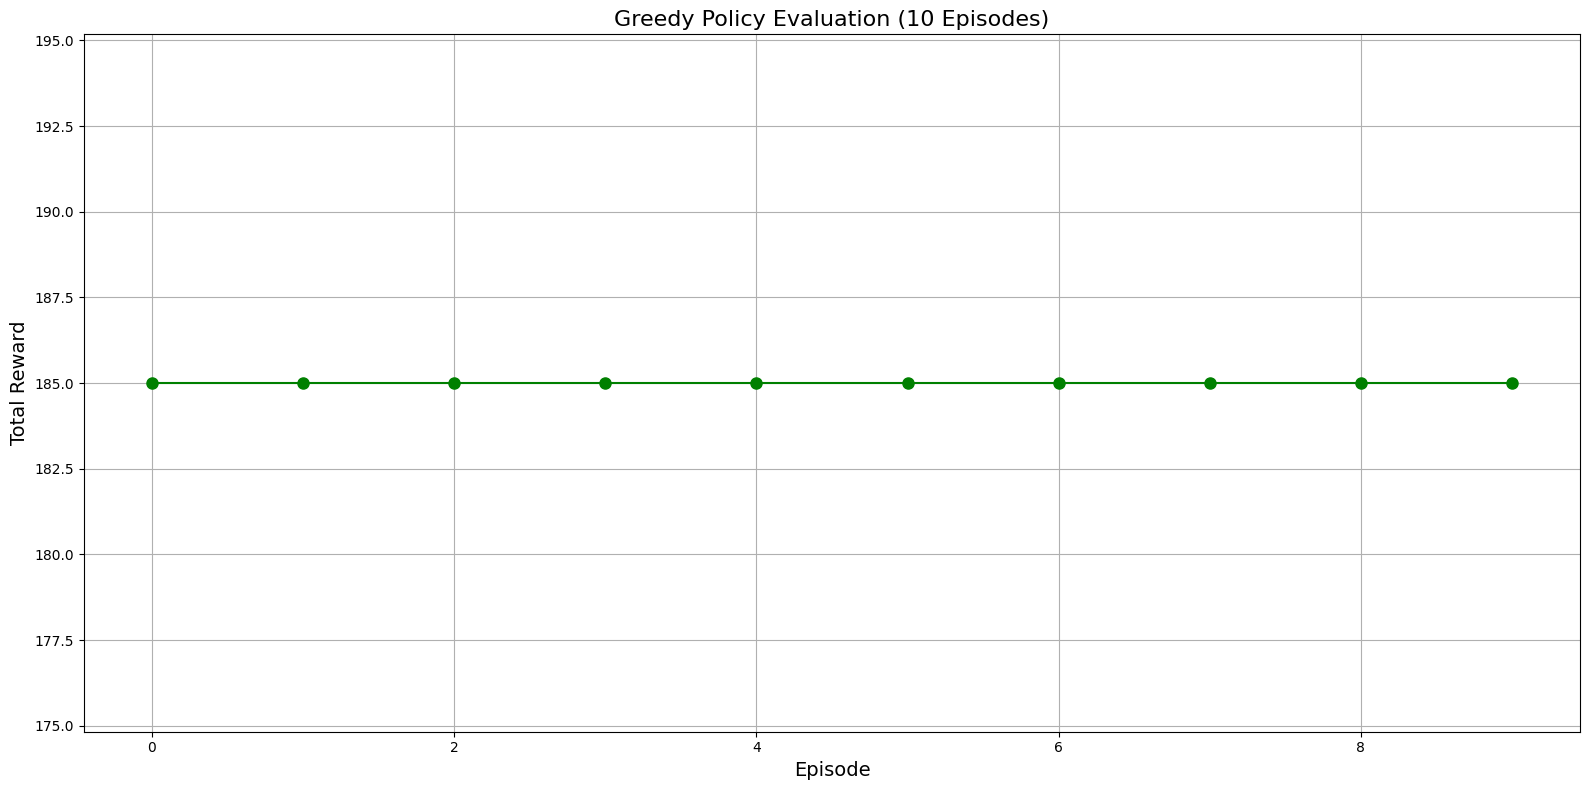

In [32]:
# Evaluating the agent using a greedy policy

deterministic = True 
env = Environment(0, 0, stochastic=(not deterministic))

q_table_filename="part_2_files/deterministic_q_table.pkl"

evaluation_rewards_deterministic_Q = evaluate_agent_deterministic_Q(env, q_table_filename=q_table_filename, 
                                                    episodes=10, max_steps=1000, render=True)

# Plotting greedy policy evaluation results
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_deterministic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (10 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Rendering the trained drone in a deterministic environment
deterministic = True  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as deterministic

# Loading the trained Q-table
q_table_filename = "part_2_files/deterministic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_agent_deterministic_Q.txt"

# Evaluating the agent and rendering the final output
final_evaluation_deterministic_Q = evaluate_agent_deterministic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 25 | Total Reward: 185 

Task complete count: 1 


--- Evaluation Episode 1 starting ---
🚁 ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ➡️ 🌪️ ⬅️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (0, 1). Step reward: -2
⬜ 🚁 ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Evaluation Episode 1 - Step 1
Drone moved to (1, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ 🚁 ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (2, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ 🚁 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ 🚁 ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (4, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 🚁 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Picked up package 2 for 25 reward
Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ 🚁 ⬅️ 🌪️ ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (2, 1). Step reward: -2

In [36]:
# -----------------------------------------------------
#   Q-Learning Agent for Stochastic Environment 
# -----------------------------------------------------


def train_agent_stochastic_Q(env, hyperparams, hyperparams_name: str , render=False, ):
    """
    This function trains a Q-learning agent in a stochastic environment.
    I'm using an epsilon-greedy strategy for action selection, with decaying epsilon 
    to balance exploration and exploitation. The function also includes a penalty for 
    repetitive actions to encourage diverse decision-making.
    """
    
    filename = "part_2_files/train_agent_stochastic_Q_console_output.txt"
    
    # Extracting hyperparameters with default values.
    alpha = hyperparams.get('alpha', 0.1)  # Learning rate
    gamma = hyperparams.get('gamma', 0.95)  # Discount factor
    epsilon = hyperparams.get('epsilon', 1.0)  # Initial exploration rate
    epsilon_decay = hyperparams.get('epsilon_decay', 0.995)  # Epsilon decay rate
    epsilon_min = hyperparams.get('epsilon_min', 0.01)  # Minimum epsilon value
    episodes = hyperparams.get('episodes', 500)  # Number of training episodes
    max_steps = hyperparams.get('max_steps', 100)  # Max steps per episode
    
    # New hyperparameter: applying a penalty for taking the same action repeatedly.
    repetition_penalty = hyperparams.get('repetition_penalty', -50)
    
    total_successful_delivery_count = 0  # Tracking successful deliveries
    success_in_last_1K = 0  # Tracking recent success rates
    
    # Initializing Q-table using defaultdict with six possible actions.
    Q = defaultdict(default_q)

    rewards_per_episode = []  # Storing episode rewards for analysis
    eps_history = []  # Tracking epsilon values over time
    
    # Redirecting console output to a file so I can analyze training logs later.
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()  # Resetting the environment at the start of each episode
                state = get_state(env)  # Getting the initial state of the drone
                total_reward = 0  # Keeping track of total rewards earned in this episode
                step_count = 0  # Counting steps per episode
                
                # Keeping track of repeated actions to discourage static behavior.
                last_action = None
                repeat_count = 0
                
                print(f"\n--- Training Episode {ep+1} starting ---")
                
                for step in range(max_steps):
                    safe_actions = [0, 1, 2, 3, 4, 5]  # Defining possible actions

                    # Epsilon-greedy action selection: sometimes explore, sometimes exploit.
                    if random.random() < epsilon:
                        action = random.choice(safe_actions)  # Random action (exploration)
                    else:
                        q_vals = Q[state]  # Getting Q-values for the current state
                        safe_q = {a: q_vals[a] for a in safe_actions}  # Filtering valid actions
                        action = max(safe_q, key=safe_q.get)  # Choosing the best action (exploitation)
                    
                    # Checking if the same action is taken repeatedly.
                    if last_action is not None and action == last_action:
                        repeat_count += 1
                    else:
                        repeat_count = 1  # Resetting count if action changes
                    last_action = action
                    
                    # Performing the chosen action in the environment.
                    reward, done = env.step(action, render_env=render, print_log=True)
                    
                    # If the agent repeats the same action 3+ times, apply a penalty.
                    if repeat_count >= 3:
                        reward += repetition_penalty
                        print(f"Repetition penalty applied: {repetition_penalty} (repeat_count={repeat_count})")
                    
                    total_reward += reward  # Updating total reward for this episode
                    next_state = get_state(env)  # Getting the new state after action
                    
                    # Q-learning update: adjusting Q-value based on reward and next state.
                    best_next = np.max(Q[next_state])  # Best Q-value for next state
                    Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])  # Q-value update
                    
                    state = next_state  # Moving to the next state
                    step_count += 1  # Incrementing step count
                    
                    # Printing progress every 10 steps if rendering is enabled.
                    if render and (step % 10 == 0):
                        print(f"Episode {ep+1} - Step {step+1}")
                    
                    # If the episode ends (goal reached or failure), stop further steps.
                    if done:
                        total_successful_delivery_count += 1
                        success_in_last_1K += 1
                        break
        
                # Updating epsilon to reduce exploration over time.
                epsilon = max(epsilon * epsilon_decay, epsilon_min)
                
                # Storing episode results for analysis.
                rewards_per_episode.append(total_reward)
                eps_history.append(epsilon)
                
                # Logging episode summary.
                print(f"Episode {ep+1}/{episodes} | Steps: {step_count} | Total Reward: {total_reward} | Epsilon: {epsilon:.3f}")
                
                # Printing success count every 1,000 episodes.
                if (ep + 1) % 1000 == 0:
                    print(
                        f"Episode {ep+1}/{episodes} | Eps: {epsilon:.4f} | Success in last 1K: {success_in_last_1K/10} %",
                        file=sys.__stdout__
                    )
                    success_in_last_1K = 0  # Resetting recent success counter
        
        # Final training summary.
        print(f"Task complete count: {total_successful_delivery_count} \n")

        # Saving the Q-table as a pickle file for later evaluation.
        q_table_filename = "part_2_files/"+hyperparams_name+"_stochastic_q_table.pkl"
        with open(q_table_filename, "wb") as pf:
            pickle.dump(Q, pf)
        print(f"Q-table saved to {q_table_filename}")
        
        # Returning Q-table, episode rewards, and epsilon history for further analysis.
        return Q, rewards_per_episode, eps_history

def evaluate_agent_stochastic_Q(env, q_table_filename="", episodes=10, max_steps=100, render=True, final_render_file_name="part_2_files/evaluate_agent_stochastic_Q_console_output.txt"):
    """
    This function evaluates a trained Q-learning agent in a stochastic environment.
    I run multiple episodes, track rewards, and ensure that the agent does not get stuck
    in repetitive actions. If the agent encounters an unseen state, it chooses a random action.
    """
    Q = None
    
    # Loading the Q-table from the pickle file.
    with open(q_table_filename, "rb") as pf:
        Q = pickle.load(pf)  

    rewards = []  # Storing rewards per episode
    repetition_threshold = 4  # Maximum allowed consecutive repetitions of the same action
    valid_actions = [0, 1, 2, 3, 4, 5]  # Defining possible actions
    filename = final_render_file_name  # Output log file
    total_successful_delivery_count = 0  # Tracking successful task completions

    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()  # Resetting the environment at the start of each episode
                state = get_state(env)  # Getting the initial state
                total_reward = 0  # Tracking total reward in this episode
                step_count = 0  # Counting steps per episode

                # Tracking repeated actions to prevent looping behavior
                last_action = None
                repeat_count = 0

                # Logging episode start
                with contextlib.redirect_stdout(f):
                    print(f"\n--- Evaluation Episode {ep+1} starting ---")
                    env.render()
                for step in range(max_steps):
                    with contextlib.redirect_stdout(f):
                        # If the state is not in Q or has default values, take a random action.
                        if state not in Q or np.all(Q[state] == 0):
                            print(f"State {state} not found or has default Q-values. Choosing random valid action.")
                            action = random.choice(valid_actions)
                        else:
                            q_vals = Q[state]  # Fetch Q-values for the current state
                            action = int(np.argmax(q_vals))  # Choosing the best action based on Q-values

                        # Checking for repeated actions.
                        if last_action is not None and action == last_action:
                            repeat_count += 1
                        else:
                            repeat_count = 1  # Resetting repetition count if action changes
                        last_action = action

                        # If the agent repeats an action too many times, pick a different one.
                        if repeat_count >= repetition_threshold:
                            print(f"Action {action} repeated {repeat_count} times. Switching to a new action.")
                            action = random.choice(valid_actions)
                            repeat_count = 1  # Resetting repetition count

                        # Performing the action in the environment.
                        reward, done = env.step(action, render_env=render, print_log=True)
                        total_reward += reward  # Updating total reward
                        state = get_state(env)  # Updating the state
                        step_count += 1  # Incrementing step count

                        # Displaying progress every 10 steps if rendering is enabled.
                        if render and (step % 10 == 0):
                            print(f"Evaluation Episode {ep+1} - Step {step+1}")

                        # If the episode ends (goal reached or failure), stop further steps.
                        if done:
                            total_successful_delivery_count += 1
                            break

                # Storing episode rewards for analysis.
                rewards.append(total_reward)

                # Logging episode summary.
                print(f"Evaluation Episode {ep+1}: Steps: {step_count} | Total Reward: {total_reward}", file=sys.__stdout__)

    # Final summary of successful task completions.
    print(f"Task complete count: {total_successful_delivery_count} \n")

    # Returning collected rewards for analysis.
    return rewards




In [37]:
# Hyperparameter Base

hyperparams_base = {   
    'alpha': 0.005,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 10000,
    'max_steps': 1000
}


# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_base, hyperparams_name="hyperparams_base", render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/10000 | Eps: 0.9048 | Success in last 1K: 0.4 %
Episode 2000/10000 | Eps: 0.8187 | Success in last 1K: 1.8 %
Episode 3000/10000 | Eps: 0.7408 | Success in last 1K: 3.8 %
Episode 4000/10000 | Eps: 0.6703 | Success in last 1K: 6.7 %
Episode 5000/10000 | Eps: 0.6065 | Success in last 1K: 13.7 %
Episode 6000/10000 | Eps: 0.5488 | Success in last 1K: 26.0 %
Episode 7000/10000 | Eps: 0.4966 | Success in last 1K: 38.0 %
Episode 8000/10000 | Eps: 0.4493 | Success in last 1K: 44.7 %
Episode 9000/10000 | Eps: 0.4066 | Success in last 1K: 53.8 %
Task complete count: 2490 
Episode 10000/10000 | Eps: 0.3679 | Success in last 1K: 60.1 %

Q-table saved to part_2_files/hyperparams_base_stochastic_q_table.pkl


In [38]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_base_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


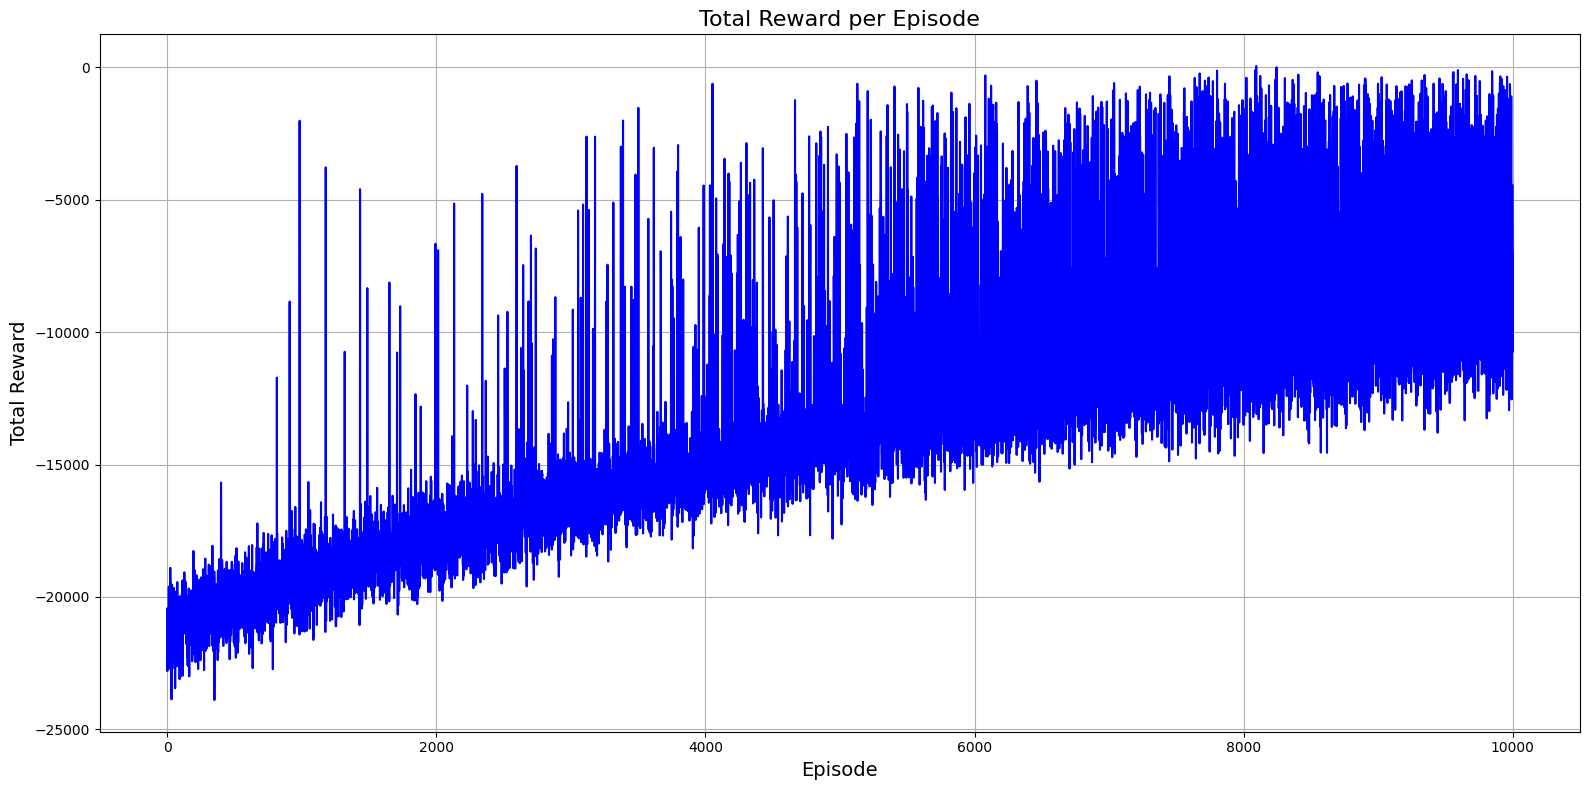

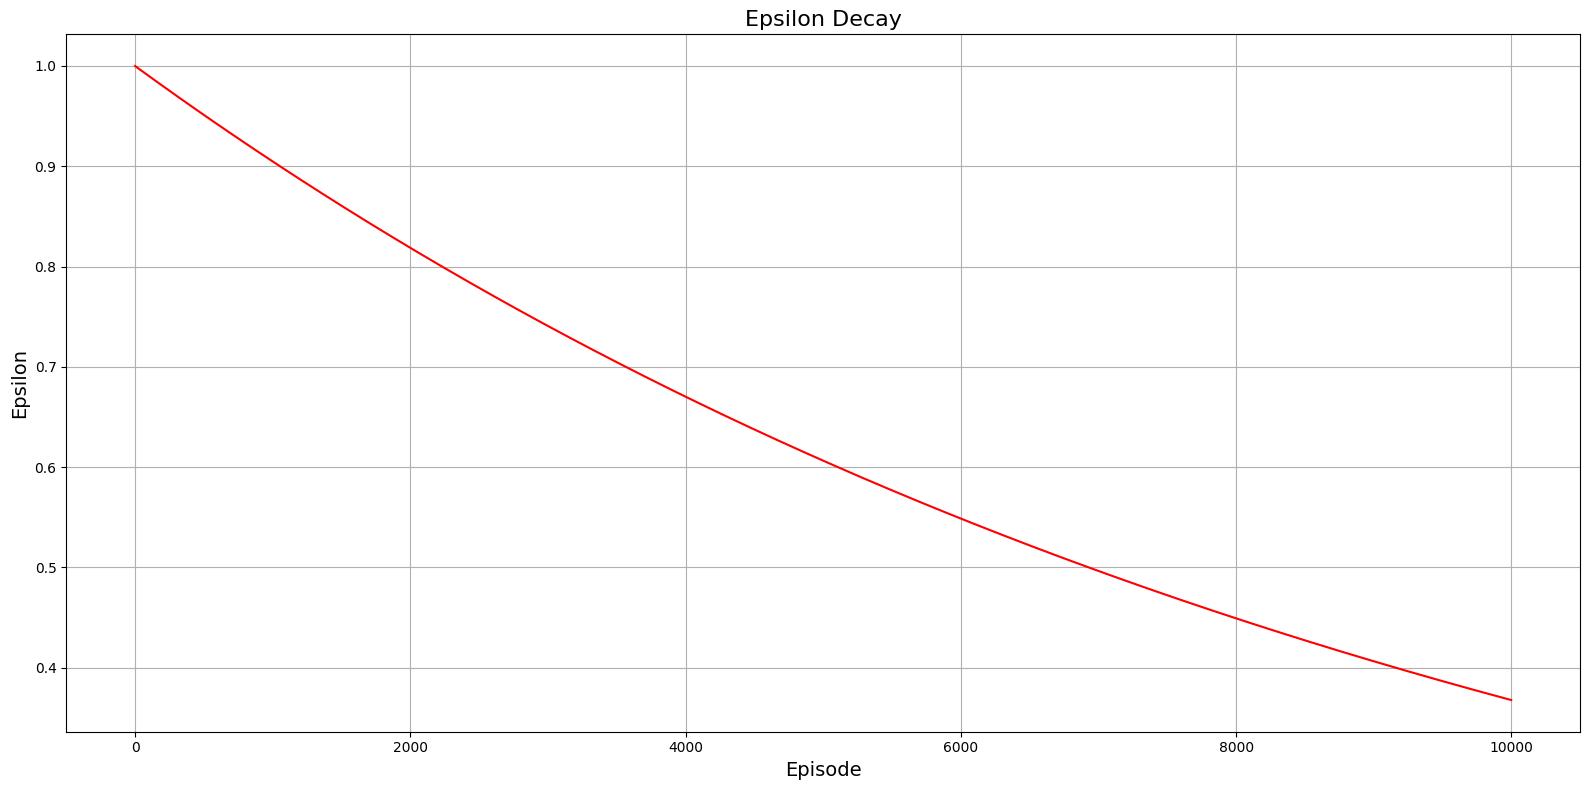

In [39]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 1000 | Total Reward: -7114
Evaluation Episode 2: Steps: 1000 | Total Reward: -5496
Evaluation Episode 3: Steps: 751 | Total Reward: -6349
Evaluation Episode 4: Steps: 477 | Total Reward: -2909
Evaluation Episode 5: Steps: 1000 | Total Reward: -7355
Evaluation Episode 6: Steps: 398 | Total Reward: -1940
Evaluation Episode 7: Steps: 459 | Total Reward: -2749
Evaluation Episode 8: Steps: 1000 | Total Reward: -9355
Evaluation Episode 9: Steps: 1000 | Total Reward: -5148
Evaluation Episode 10: Steps: 386 | Total Reward: -948
Evaluation Episode 11: Steps: 1000 | Total Reward: -8609
Evaluation Episode 12: Steps: 1000 | Total Reward: -7344
Evaluation Episode 13: Steps: 398 | Total Reward: -2020
Evaluation Episode 14: Steps: 213 | Total Reward: -1173
Evaluation Episode 15: Steps: 395 | Total Reward: -5303
Evaluation Episode 16: Steps: 1000 | Total Reward: -6948
Evaluation Episode 17: Steps: 567 | Total Reward: -3723
Evaluation Episode 18: Steps: 958 | Total Reward: 

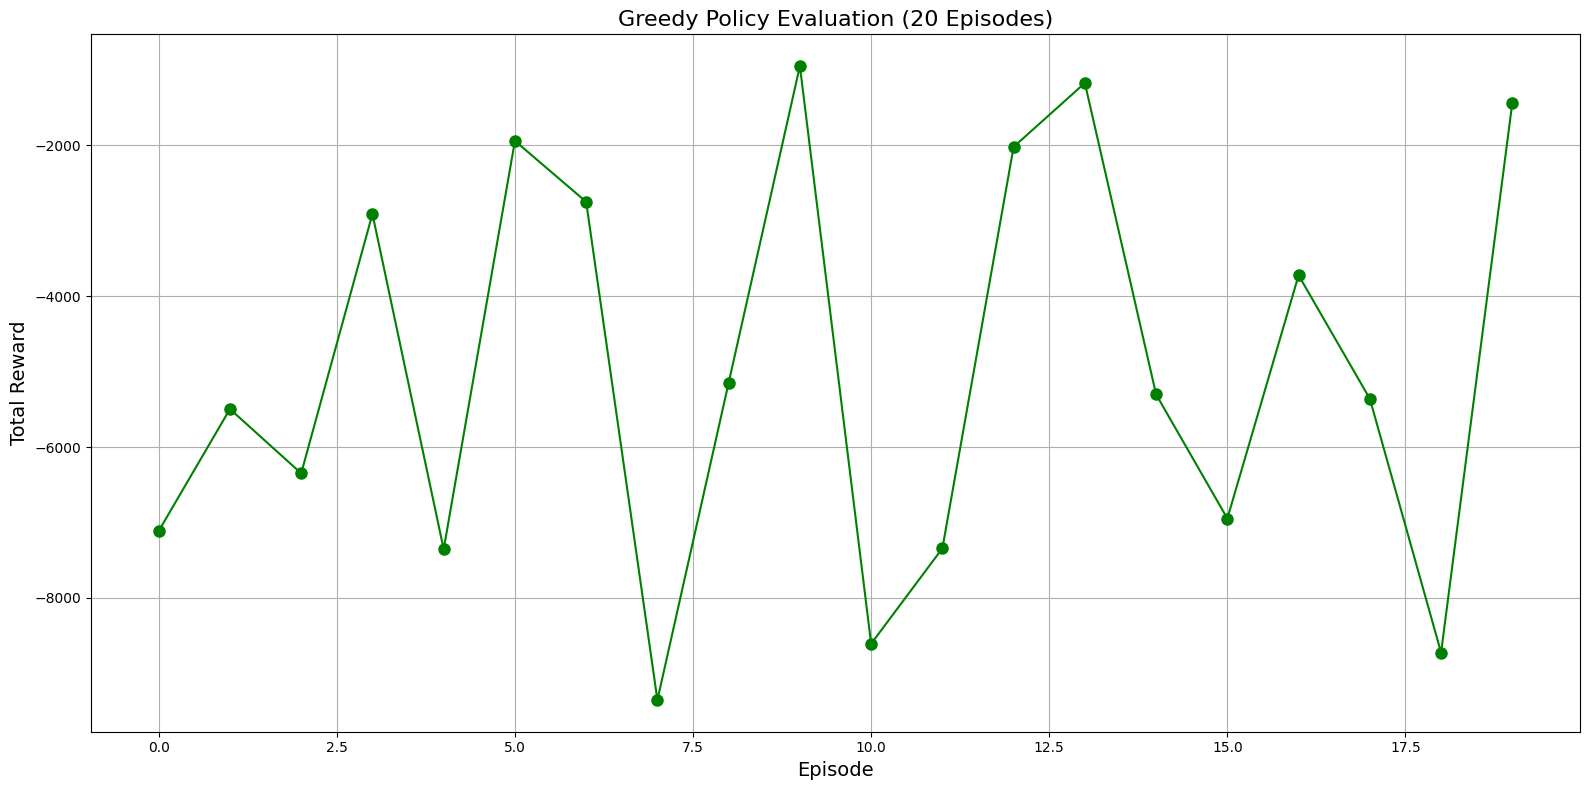

In [42]:
# Evaluating the trained agent
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_base_stochastic_q_table.pkl"

evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_base_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_base_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_base_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 119 | Total Reward: -791
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ ⬜ ⬜ ⬜ 🚁 ⬜
🦅 ⬜ 📦 ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬇️ ⬜ 🛖
⬜ ⬜ ➡️ 🌪️ ⬅️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Drone moved to (1, 3). Step reward: -2
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ ⬜ ⬜ 🚁 ⬜ ⬜
🦅 ⬜ 📦 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜

Evaluation Episode 1 - Step 1
Attempted pickup failed. Penalty -25
Attempted pickup failed. Penalty -25
Attempted pickup failed. Penalty -25
Action 4 repeated 4 times. Switching to a new action.
Drone moved to (2, 3). Step reward: -100
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
🦅 ⬜ ⬅️ 🚁 ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜

Drone moved to (2, 2). Step reward: -100
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🦅 ⬅️ 🚁 ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜

Drone moved to (1, 2). Step reward: -2
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ ⬜ 🚁 ⬜ ⬜ ⬜
🦅 ⬜ ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ 🛖
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜

Drone moved to (1, 1). Step reward: -2
⬜ 🦅 ⬜ ⬜ 🏠 ⬜
⬜ 🚁 ⬜ ⬜ ⬜ ⬜
🦅 ⬜ 📦 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜

Drone moved to (2, 1).

In [48]:
# Hyperparameter set 6 changing alpha = 0.001

hyperparams_6 = {   
    'alpha': 0.001,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 10000,
    'max_steps': 1000
}


# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_6, hyperparams_name= 'hyperparams_6' ,render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/10000 | Eps: 0.9048 | Success in last 1K: 0.6 %
Episode 2000/10000 | Eps: 0.8187 | Success in last 1K: 1.9 %
Episode 3000/10000 | Eps: 0.7408 | Success in last 1K: 2.4 %
Episode 4000/10000 | Eps: 0.6703 | Success in last 1K: 6.9 %
Episode 5000/10000 | Eps: 0.6065 | Success in last 1K: 10.4 %
Episode 6000/10000 | Eps: 0.5488 | Success in last 1K: 18.2 %
Episode 7000/10000 | Eps: 0.4966 | Success in last 1K: 22.2 %
Episode 8000/10000 | Eps: 0.4493 | Success in last 1K: 34.3 %
Episode 9000/10000 | Eps: 0.4066 | Success in last 1K: 39.9 %
Task complete count: 1853 
Episode 10000/10000 | Eps: 0.3679 | Success in last 1K: 48.5 %

Q-table saved to part_2_files/hyperparams_6_stochastic_q_table.pkl


In [49]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_6_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


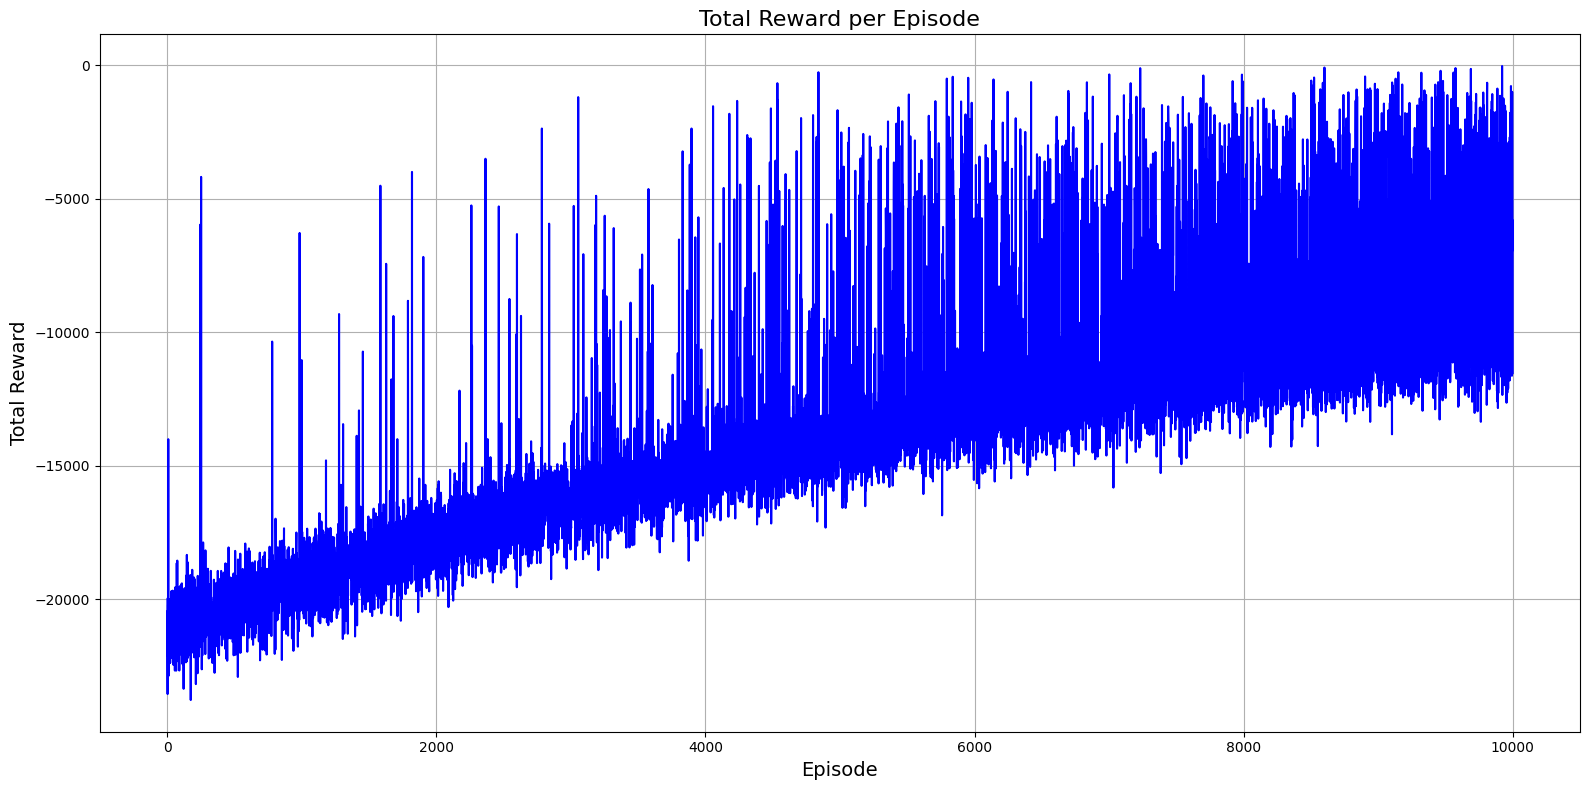

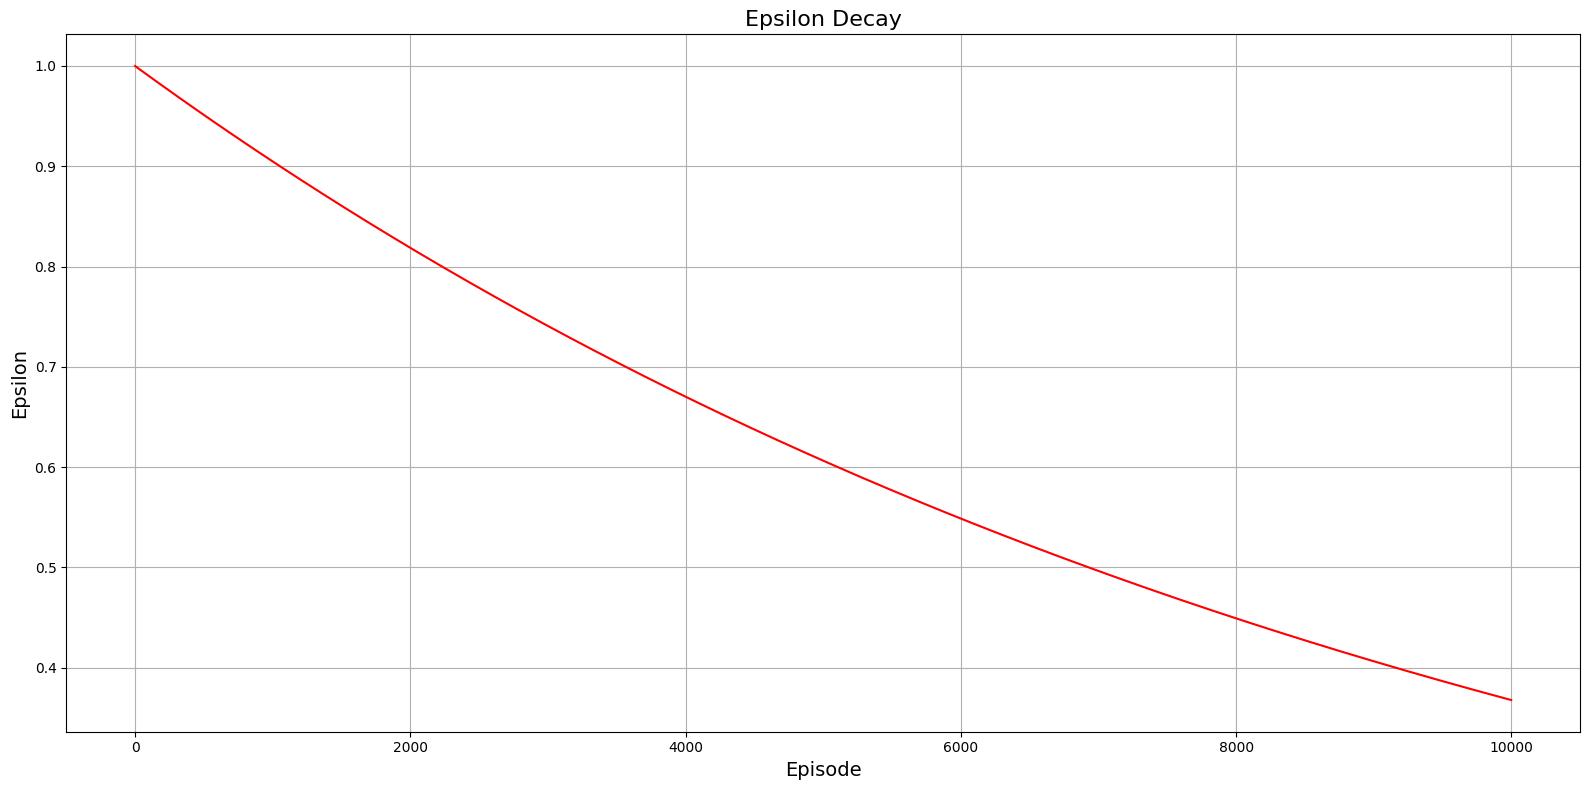

In [50]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 1000 | Total Reward: -6291
Evaluation Episode 2: Steps: 1000 | Total Reward: -4532
Evaluation Episode 3: Steps: 1000 | Total Reward: -7067
Evaluation Episode 4: Steps: 1000 | Total Reward: -4407
Evaluation Episode 5: Steps: 957 | Total Reward: -6679
Evaluation Episode 6: Steps: 113 | Total Reward: -456
Evaluation Episode 7: Steps: 762 | Total Reward: -2513
Evaluation Episode 8: Steps: 1000 | Total Reward: -11799
Evaluation Episode 9: Steps: 1000 | Total Reward: -4137
Evaluation Episode 10: Steps: 235 | Total Reward: -3252
Evaluation Episode 11: Steps: 1000 | Total Reward: -6448
Evaluation Episode 12: Steps: 82 | Total Reward: -1210
Evaluation Episode 13: Steps: 578 | Total Reward: -3893
Evaluation Episode 14: Steps: 1000 | Total Reward: -3507
Evaluation Episode 15: Steps: 684 | Total Reward: -3243
Evaluation Episode 16: Steps: 665 | Total Reward: -2616
Evaluation Episode 17: Steps: 1000 | Total Reward: -8000
Evaluation Episode 18: Steps: 1000 | Total Reward

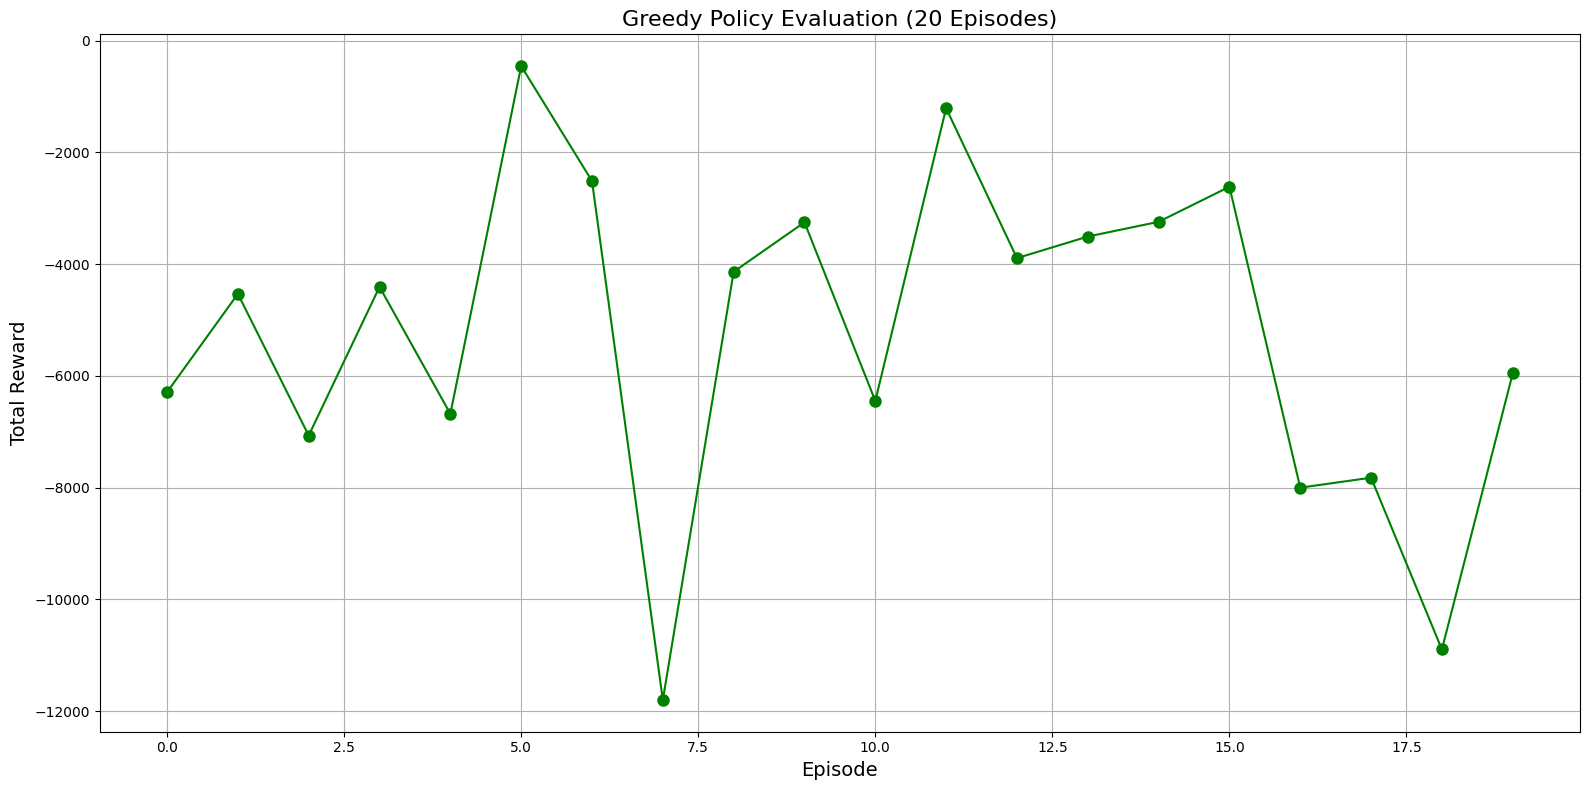

In [51]:
# Evaluating the trained agent

deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_6_stochastic_q_table.pkl"

evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename= q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_6_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_6_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_6_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)



Evaluation Episode 1: Steps: 187 | Total Reward: -882
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ 🚁 ⬇️ ⬜ ⬜ ⬜
⬜ ➡️ 🌪️ ⬅️ ⬜ 🏠
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (0, 0). Step reward: -2
🚁 ⬇️ ⬜ ⬜ ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ 🏠
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Evaluation Episode 1 - Step 1
Drone moved to (1, 0). Step reward: -2
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🚁 ⬅️ 🌪️ ➡️ ⬜ 🏠
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 0). Step reward: -2
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ 🏠
🚁 ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 1). Step reward: -2
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ 🏠
⬜ 🚁 ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 ⬇️ ⬜ ⬜ 🏠
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ 🚁 ⬆️ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 0). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 🦅 ⬜ ⬜ 🏠
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🚁 ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ 🎁 ⬆️ 🦅 ⬜ 📦
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 0). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 🦅 ⬜ ⬜ 🏠
⬜ ⬜ ⬜ ⬜ ⬜

In [59]:
# Hyperparameter set 5 changing alpha = 0.01

hyperparams_5 = {   
    'alpha': 0.01,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 10000,
    'max_steps': 1000
}


# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_5,hyperparams_name='hyperparams_5', render=False)


Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/10000 | Eps: 0.9048 | Success in last 1K: 0.9 %
Episode 2000/10000 | Eps: 0.8187 | Success in last 1K: 0.9 %
Episode 3000/10000 | Eps: 0.7408 | Success in last 1K: 4.9 %
Episode 4000/10000 | Eps: 0.6703 | Success in last 1K: 6.6 %
Episode 5000/10000 | Eps: 0.6065 | Success in last 1K: 14.9 %
Episode 6000/10000 | Eps: 0.5488 | Success in last 1K: 28.3 %
Episode 7000/10000 | Eps: 0.4966 | Success in last 1K: 39.2 %
Episode 8000/10000 | Eps: 0.4493 | Success in last 1K: 53.0 %
Episode 9000/10000 | Eps: 0.4066 | Success in last 1K: 61.1 %
Task complete count: 2773 
Episode 10000/10000 | Eps: 0.3679 | Success in last 1K: 67.5 %

Q-table saved to part_2_files/hyperparams_5_stochastic_q_table.pkl


In [60]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_5_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


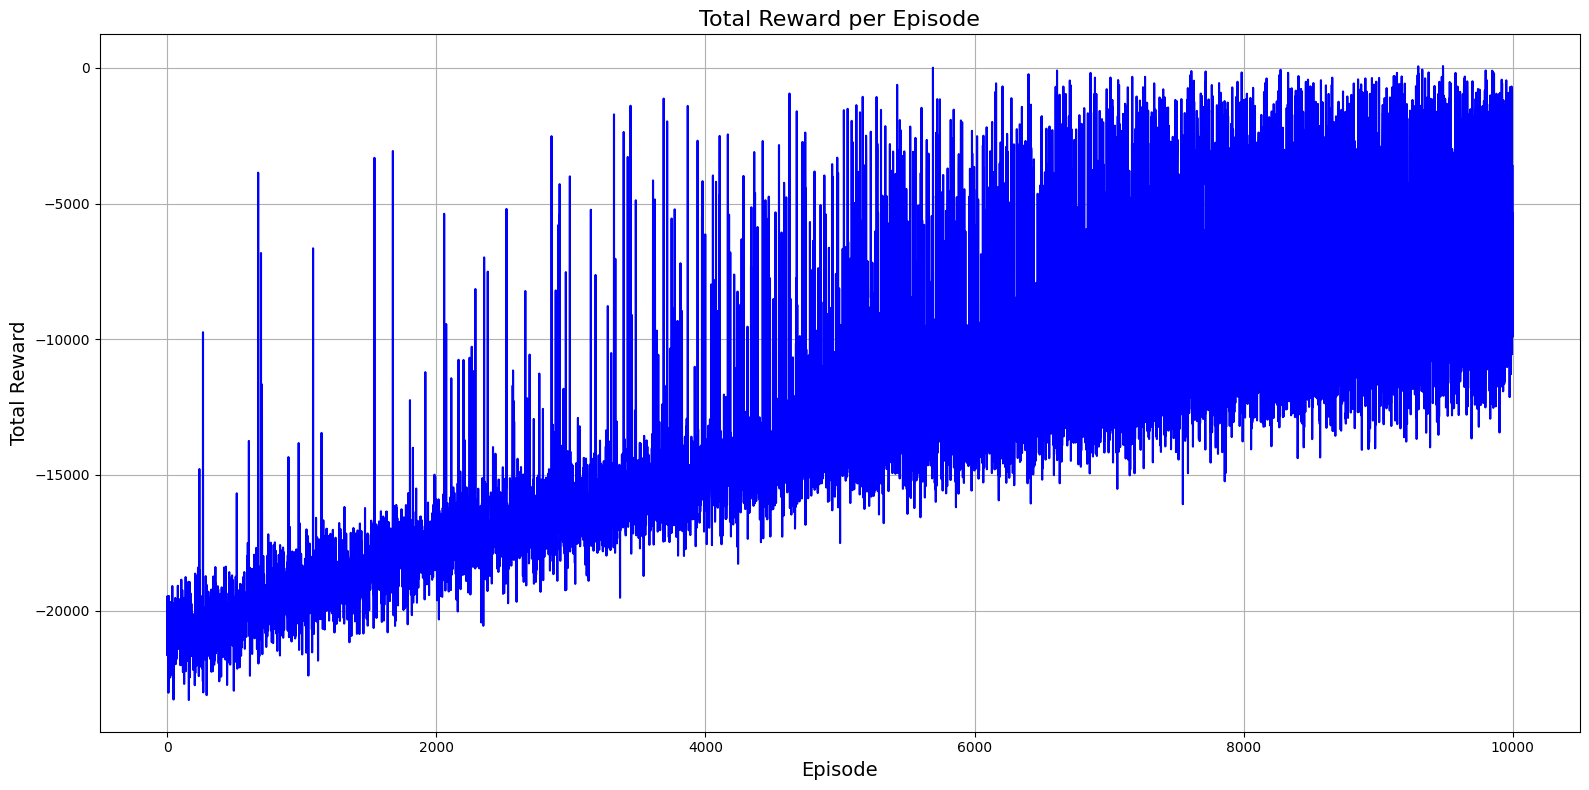

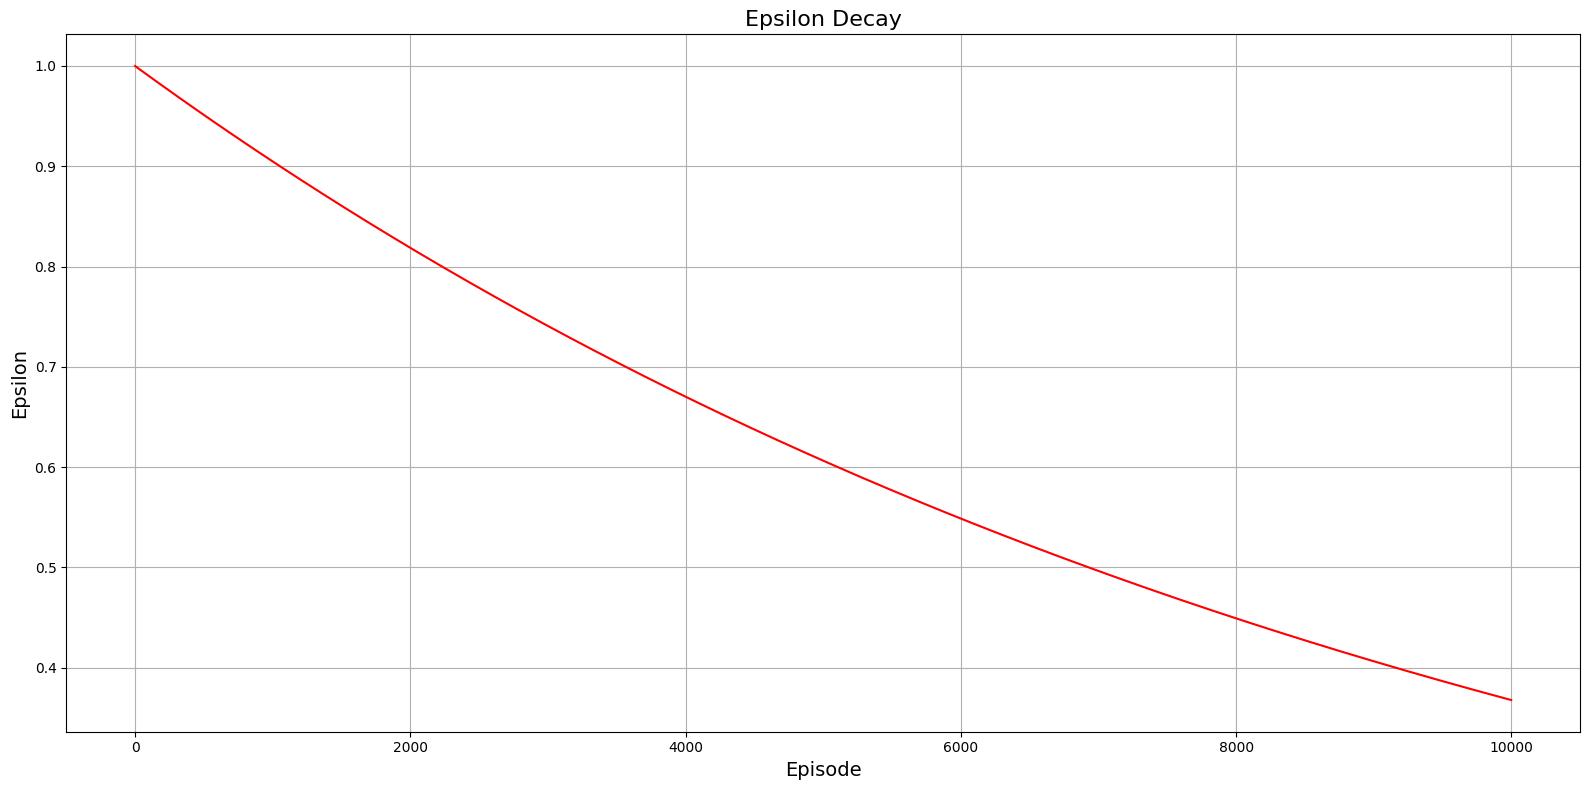

In [61]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 481 | Total Reward: -2415
Evaluation Episode 2: Steps: 1000 | Total Reward: -12324
Evaluation Episode 3: Steps: 562 | Total Reward: -1853
Evaluation Episode 4: Steps: 862 | Total Reward: -4375
Evaluation Episode 5: Steps: 1000 | Total Reward: -4468
Evaluation Episode 6: Steps: 1000 | Total Reward: -7260
Evaluation Episode 7: Steps: 576 | Total Reward: -3416
Evaluation Episode 8: Steps: 831 | Total Reward: -7228
Evaluation Episode 9: Steps: 214 | Total Reward: -1651
Evaluation Episode 10: Steps: 1000 | Total Reward: -11786
Evaluation Episode 11: Steps: 1000 | Total Reward: -4968
Evaluation Episode 12: Steps: 345 | Total Reward: -6115
Evaluation Episode 13: Steps: 140 | Total Reward: -710
Evaluation Episode 14: Steps: 1000 | Total Reward: -6724
Evaluation Episode 15: Steps: 1000 | Total Reward: -6377
Evaluation Episode 16: Steps: 1000 | Total Reward: -8926
Evaluation Episode 17: Steps: 1000 | Total Reward: -4849
Evaluation Episode 18: Steps: 1000 | Total Rewa

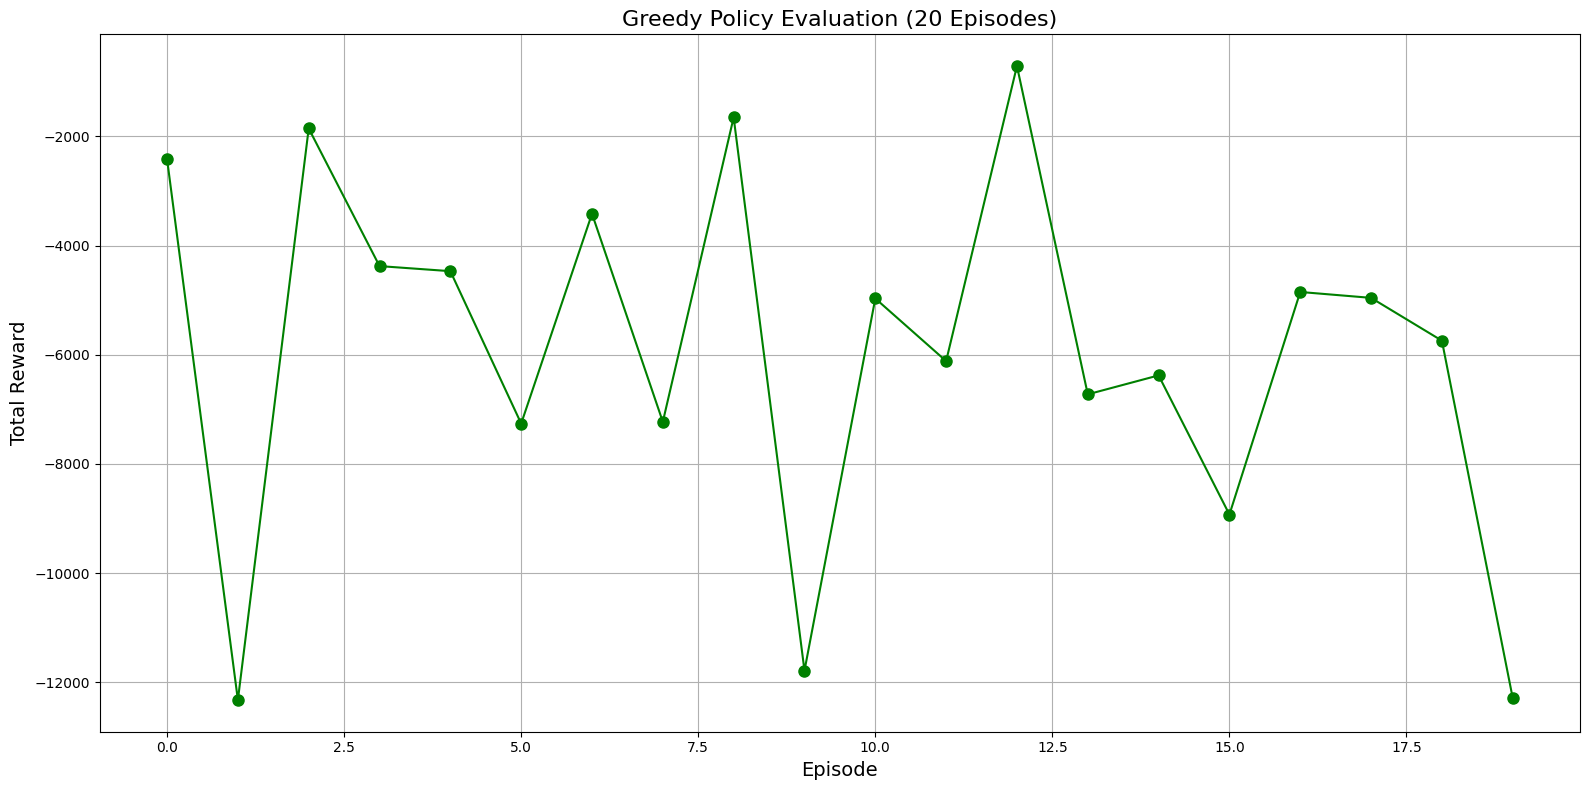

In [62]:
# Evaluating the trained agent
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_5_stochastic_q_table.pkl"
evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_5_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_5_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_5_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)



Evaluation Episode 1: Steps: 741 | Total Reward: -3349
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ ⬜ ⬜ ⬜ ⬜
🦅 ⬜ ⬜ ⬇️ 🎁 ⬜
⬜ 🚁 ➡️ 🌪️ ⬅️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Drone moved to (3, 1). Step reward: -2
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ ⬜ ⬜ ⬜ ⬜
🦅 🚁 ⬜ ⬇️ 🎁 ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Evaluation Episode 1 - Step 1
Drone moved to (3, 2). Step reward: -2
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ ⬜ ⬜ ⬜ ⬜
🦅 ⬜ 🚁 ⬇️ 🎁 ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Drone moved to (2, 2). Step reward: -2
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ 🚁 ⬜ ⬜ ⬜
🦅 ⬜ ⬜ ⬇️ 🎁 ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Drone moved to (2, 3). Step reward: -10
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ ⬜ 🚁 ⬜ ⬜
🦅 ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ 🦅 🛖
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 2). Step reward: -10
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
📦 ⬜ 🚁 ⬜ ⬜ ⬜
🦅 ⬅️ 🌪️ ➡️ 🎁 ⬜
⬜ ⬜ ⬆️ ⬜ 🦅 🛖
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 1). Step reward: -10
⬜ 🏠 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
📦 🚁 🌪️ ➡️ ⬜ ⬜
🦅 ⬜ ⬆️ ⬜ 🎁 ⬜
⬜ ⬜ ⬜ ⬜ 🦅 🛖
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Attempted pickup failed. Penalty -25
Attempted pickup failed. Penalty -

In [71]:
# Hyperparameter set 4 changing alpha = 0.1

hyperparams_4 = {   
    'alpha': 0.1,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 10000,
    'max_steps': 1000
}

# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_4, hyperparams_name='hyperparams_4',render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/10000 | Eps: 0.9048 | Success in last 1K: 1.1 %
Episode 2000/10000 | Eps: 0.8187 | Success in last 1K: 2.7 %
Episode 3000/10000 | Eps: 0.7408 | Success in last 1K: 5.8 %
Episode 4000/10000 | Eps: 0.6703 | Success in last 1K: 11.9 %
Episode 5000/10000 | Eps: 0.6065 | Success in last 1K: 24.4 %
Episode 6000/10000 | Eps: 0.5488 | Success in last 1K: 38.7 %
Episode 7000/10000 | Eps: 0.4966 | Success in last 1K: 51.6 %
Episode 8000/10000 | Eps: 0.4493 | Success in last 1K: 60.9 %
Episode 9000/10000 | Eps: 0.4066 | Success in last 1K: 66.8 %
Task complete count: 3402 
Episode 10000/10000 | Eps: 0.3679 | Success in last 1K: 76.3 %

Q-table saved to part_2_files/hyperparams_4_stochastic_q_table.pkl


In [ ]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_4_stochastic_q_table.pkl"


# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


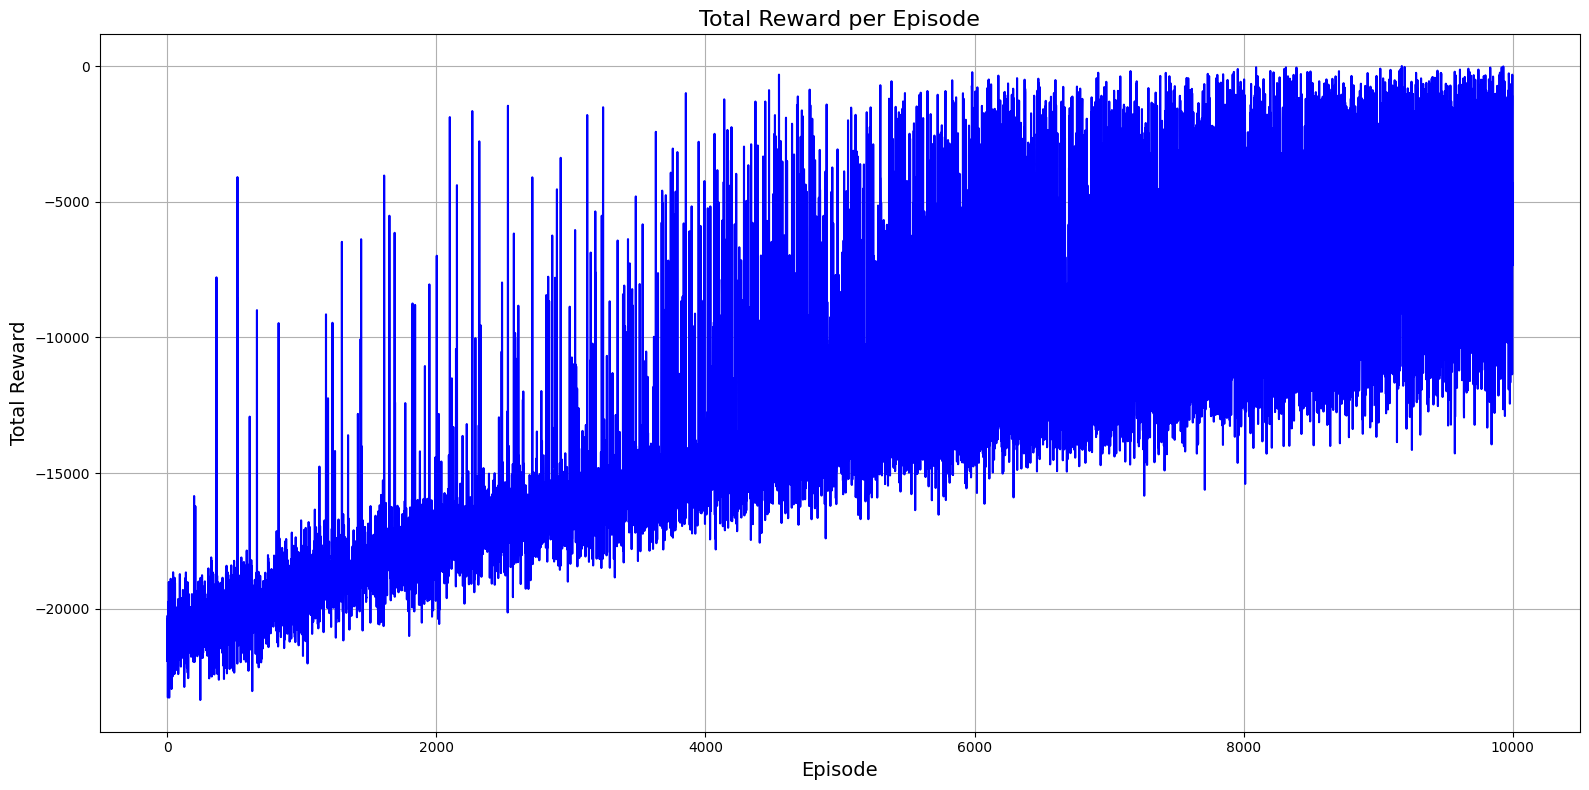

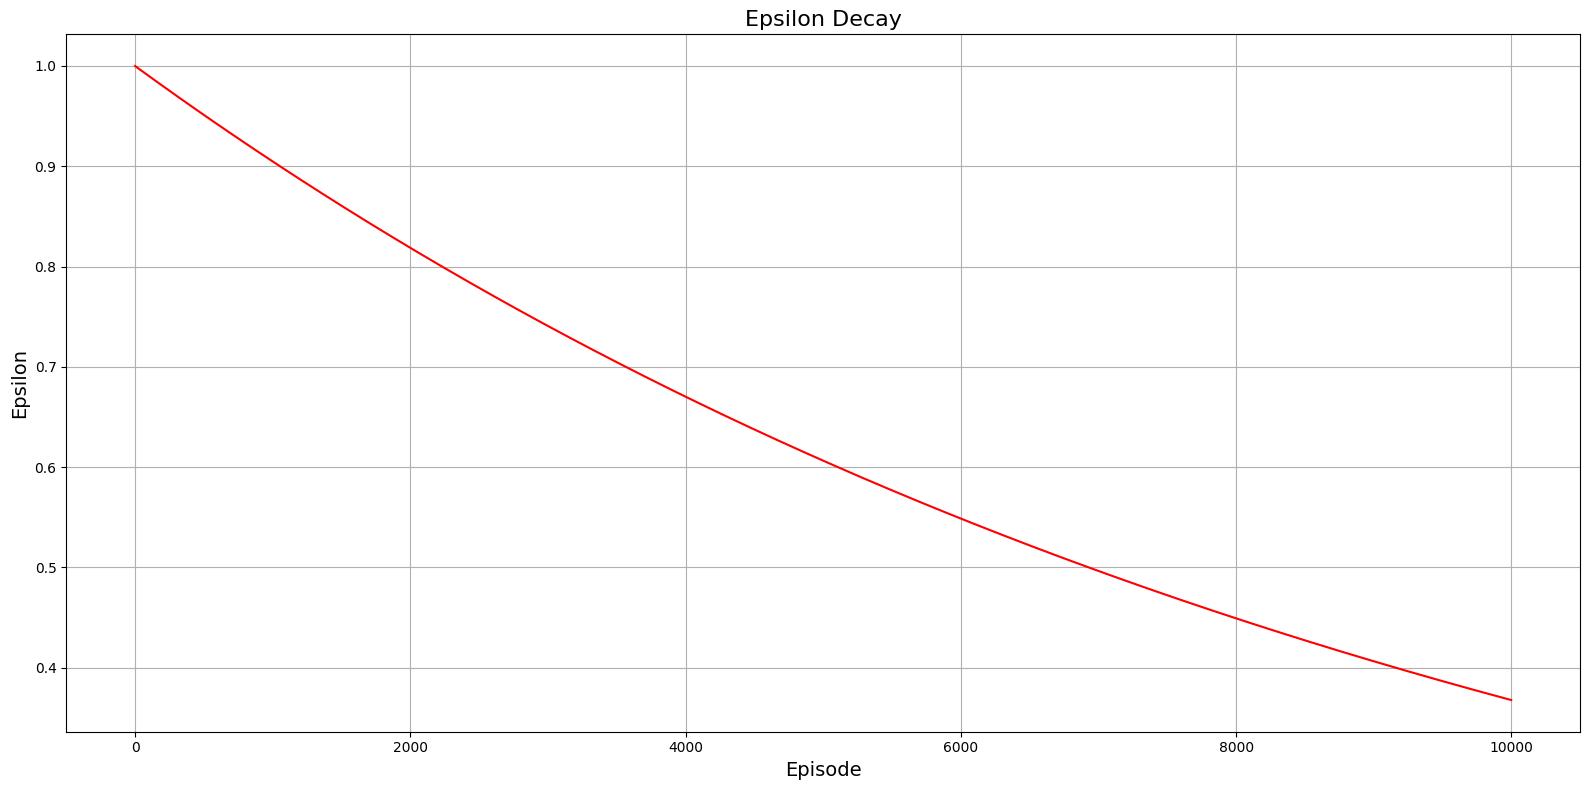

In [72]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 1000 | Total Reward: -11966
Evaluation Episode 2: Steps: 955 | Total Reward: -7532
Evaluation Episode 3: Steps: 52 | Total Reward: 122
Evaluation Episode 4: Steps: 1000 | Total Reward: -6839
Evaluation Episode 5: Steps: 92 | Total Reward: -851
Evaluation Episode 6: Steps: 210 | Total Reward: -1005
Evaluation Episode 7: Steps: 783 | Total Reward: -3892
Evaluation Episode 8: Steps: 339 | Total Reward: -1663
Evaluation Episode 9: Steps: 233 | Total Reward: -687
Evaluation Episode 10: Steps: 1000 | Total Reward: -4737
Evaluation Episode 11: Steps: 1000 | Total Reward: -6421
Evaluation Episode 12: Steps: 142 | Total Reward: -479
Evaluation Episode 13: Steps: 1000 | Total Reward: -8014
Evaluation Episode 14: Steps: 529 | Total Reward: -2993
Evaluation Episode 15: Steps: 1000 | Total Reward: -8764
Evaluation Episode 16: Steps: 1000 | Total Reward: -4656
Evaluation Episode 17: Steps: 1000 | Total Reward: -15091
Evaluation Episode 18: Steps: 203 | Total Reward: -436

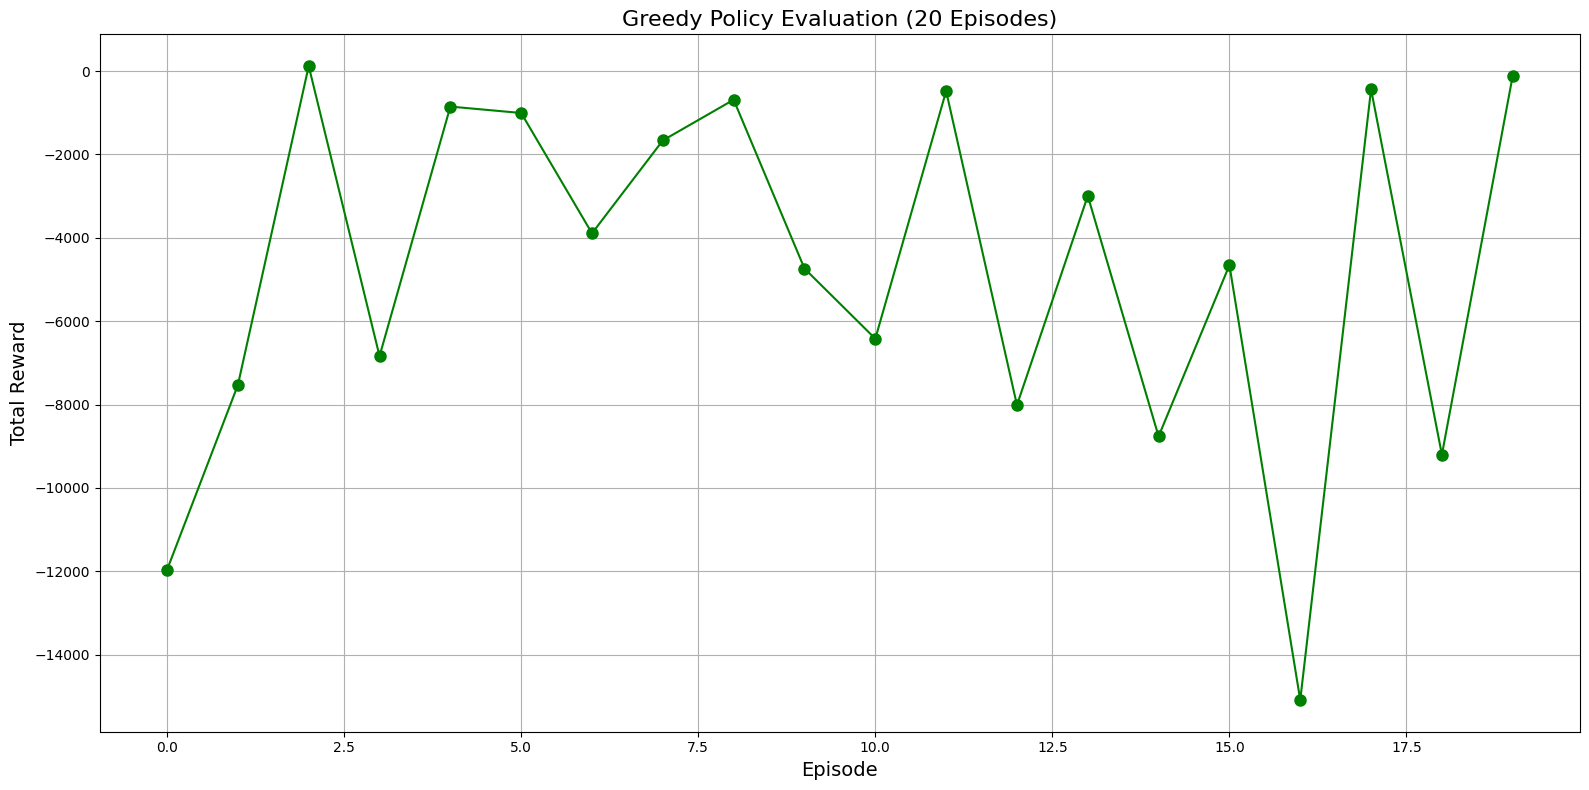

In [73]:
# Evaluating the trained agent
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_4_stochastic_q_table.pkl"

evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_4_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_4_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_4_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)



Evaluation Episode 1: Steps: 277 | Total Reward: -1271
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬜ ⬇️ 🎁 ⬜ ⬜
⬜ ➡️ 🌪️ ⬅️ ⬜ 🦅
⬜ ⬜ ⬆️ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ 🚁 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (5, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬇️ ⬜ 🎁 ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ 🦅
⬜ ⬆️ 🛖 ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 🚁 ⬜

Evaluation Episode 1 - Step 1
Drone moved to (4, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬇️ ⬜ 🎁 ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ 🦅
⬜ ⬆️ 🛖 ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ 🚁 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (5, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜
⬜ ⬇️ ⬜ ⬜ ⬜ 🦅
⬅️ 🌪️ ➡️ ⬜ ⬜ 🦅
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 🚁 ⬜

Drone moved to (4, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ 🦅
⬜ ⬅️ 🌪️ ➡️ ⬜ 🦅
⬜ ⬜ ⬆️ ⬜ 🚁 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 5). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬜ ⬜ 🎁 ⬜ ⬜
⬜ ⬇️ ⬜ ⬜ ⬜ 🦅
⬅️ 🌪️ ➡️ ⬜ ⬜ 🦅
⬜ ⬆️ ⬜ ⬜ ⬜ 🚁
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬇️ ⬜ 🎁 ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ 🦅
⬜ ⬆️ 🛖 ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ 🚁 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (5, 4). Step reward: -2
⬜ ⬜ 🏠 ⬜ 📦 ⬜
⬜ ⬇️ ⬜ 🎁 ⬜ ⬜
⬅️ 🌪️ ➡

In [75]:
# Hyperparameter set 3 chaning episodes = 15000
hyperparams_3 = {   
    'alpha': 0.1,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 15000,
    'max_steps': 1000
}

# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_3, hyperparams_name='hyperparams_3', render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/15000 | Eps: 0.9048 | Success in last 1K: 1.1 %
Episode 2000/15000 | Eps: 0.8187 | Success in last 1K: 2.4 %
Episode 3000/15000 | Eps: 0.7408 | Success in last 1K: 5.7 %
Episode 4000/15000 | Eps: 0.6703 | Success in last 1K: 13.1 %
Episode 5000/15000 | Eps: 0.6065 | Success in last 1K: 26.3 %
Episode 6000/15000 | Eps: 0.5488 | Success in last 1K: 40.8 %
Episode 7000/15000 | Eps: 0.4966 | Success in last 1K: 52.5 %
Episode 8000/15000 | Eps: 0.4493 | Success in last 1K: 64.7 %
Episode 9000/15000 | Eps: 0.4066 | Success in last 1K: 71.1 %
Episode 10000/15000 | Eps: 0.3679 | Success in last 1K: 75.2 %
Episode 11000/15000 | Eps: 0.3329 | Success in last 1K: 81.4 %
Episode 12000/15000 | Eps: 0.3012 | Success in last 1K: 82.9 %
Episode 13000/15000 | Eps: 0.2725 | Success in last 1K: 84.7 %
Episode 14000/15000 | Eps: 0.2466 | Success in last 1K: 88.3 %
Task complete count: 7784 
Episode 15000/15000 

In [ ]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_3_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


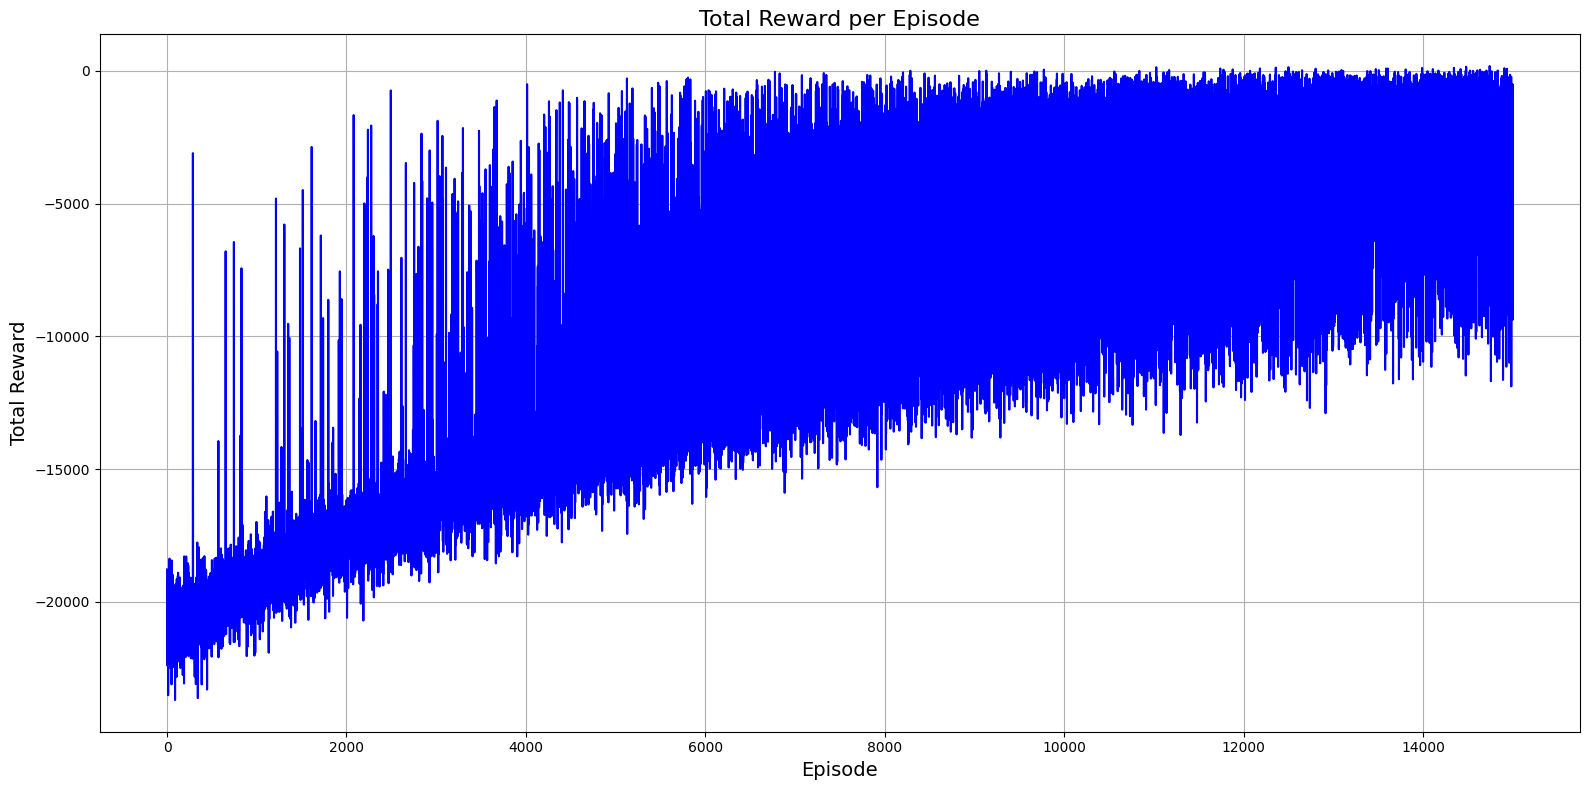

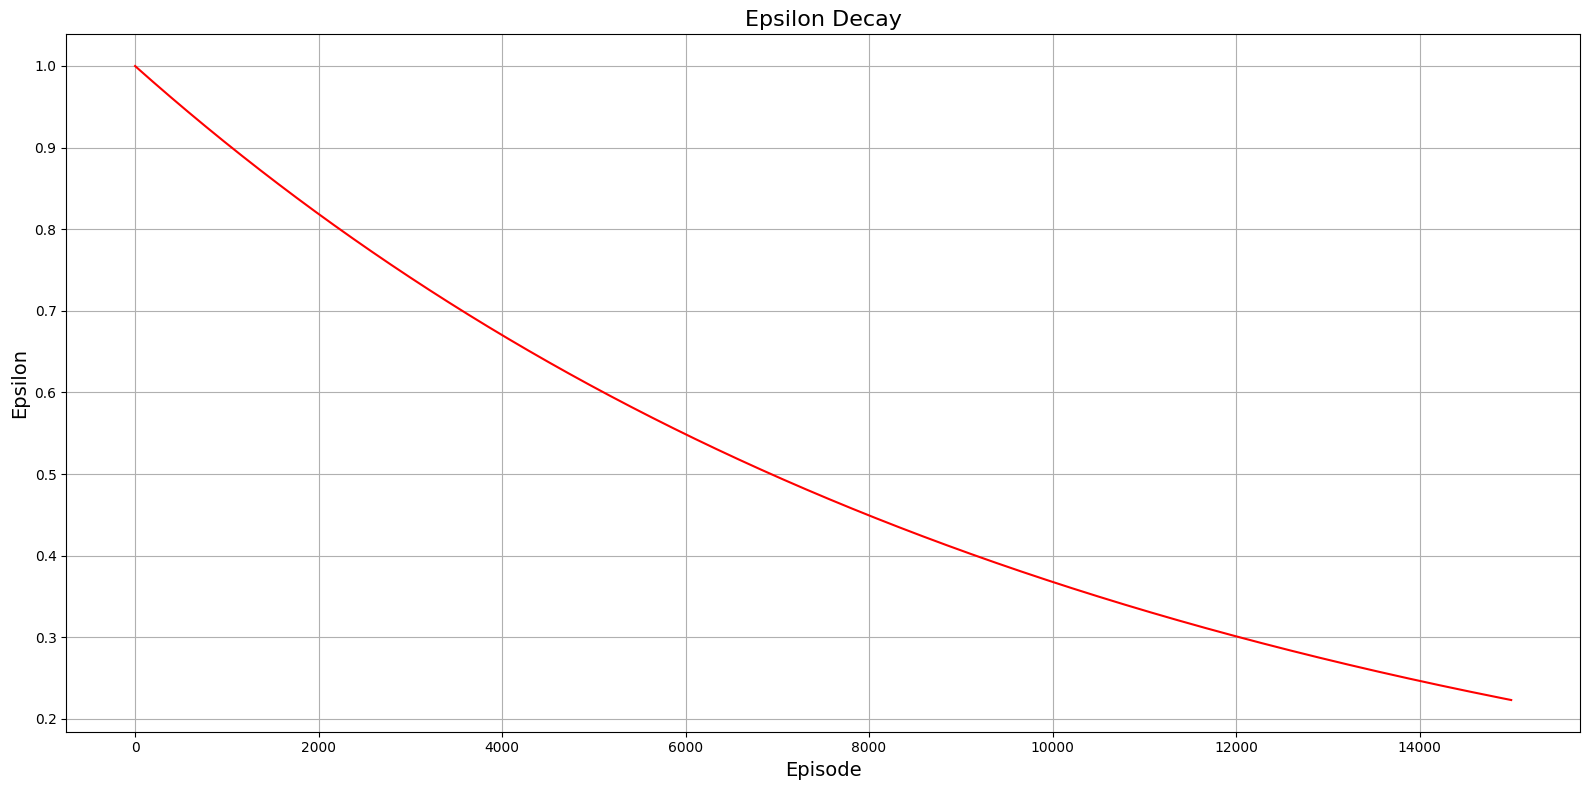

In [ ]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 488 | Total Reward: -3096
Evaluation Episode 2: Steps: 149 | Total Reward: -1310
Evaluation Episode 3: Steps: 304 | Total Reward: -1237
Evaluation Episode 4: Steps: 102 | Total Reward: -728
Evaluation Episode 5: Steps: 71 | Total Reward: -28
Evaluation Episode 6: Steps: 194 | Total Reward: -1255
Evaluation Episode 7: Steps: 235 | Total Reward: -2279
Evaluation Episode 8: Steps: 193 | Total Reward: -799
Evaluation Episode 9: Steps: 93 | Total Reward: -968
Evaluation Episode 10: Steps: 131 | Total Reward: -606
Evaluation Episode 11: Steps: 420 | Total Reward: -3277
Evaluation Episode 12: Steps: 1000 | Total Reward: -8091
Evaluation Episode 13: Steps: 1000 | Total Reward: -7862
Evaluation Episode 14: Steps: 108 | Total Reward: -217
Evaluation Episode 15: Steps: 620 | Total Reward: -2000
Evaluation Episode 16: Steps: 572 | Total Reward: -5221
Evaluation Episode 17: Steps: 187 | Total Reward: -1225
Evaluation Episode 18: Steps: 124 | Total Reward: -461
Evaluatio

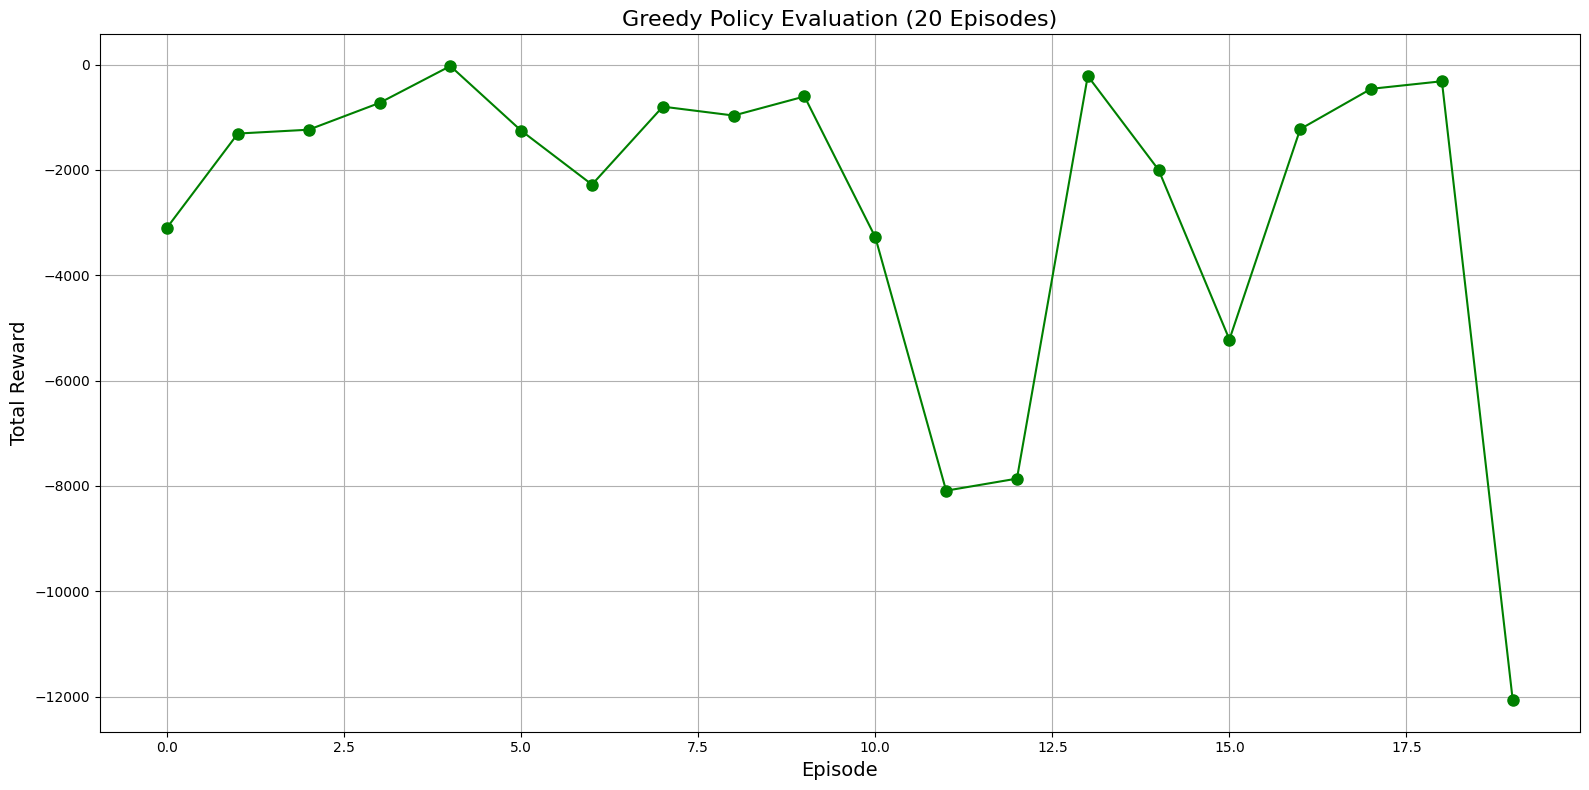

In [ ]:
# Evaluating the trained agent

deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_3_stochastic_q_table.pkl"

evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_3_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_3_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_3_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 101 | Total Reward: -544
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 📦 ⬜ ⬜ ⬜
⬜ ⬜ 🦅 ⬜ ⬜ ⬜
⬜ ⬇️ 🚁 ⬜ ⬜ ⬜
➡️ 🌪️ ⬅️ ⬜ ⬜ ⬜
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 3). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 📦 ⬜ ⬜ ⬜
⬜ ⬜ 🦅 ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ 🚁 ⬜ ⬜
🏠 ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ 🎁 ⬆️ ⬜ ⬜ ⬜

Evaluation Episode 1 - Step 1
Drone moved to (2, 3). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 📦 ⬜ ⬜ ⬜
⬜ ⬜ 🦅 🚁 ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🏠 ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ 🎁 ⬆️ ⬜ ⬜ ⬜

Drone moved to (2, 4). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 📦 ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ 🚁 ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
🏠 ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ 🎁 ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 5). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ 🚁
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
🏠 ⬜ 🦅 ⬜ ⬜ ⬜
⬜ 🎁 ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 4). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬇️ 📦 ⬜ ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ 🚁 ⬜
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜
🏠 ⬜ 🦅 ⬜ ⬜ ⬜
⬜ 🎁 ⬜ ⬜ ⬜ ⬜

Drone moved to (2, 3). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬇️ 📦 ⬜ ⬜ ⬜
⬅️ 🌪️ ➡️ 🚁 ⬜ ⬜
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜
🏠 ⬜ 🦅 ⬜ ⬜ ⬜
⬜ 🎁 ⬜ ⬜ ⬜ ⬜

Drone moved to (1, 3). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🛖 ⬇️ 🚁 ⬜ ⬜
⬜ ⬅️ 🌪️ 

In [ ]:
# Hyperparameter set 2 chaning episodes = 25000
hyperparams_2 = {   
    'alpha': 0.1,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 25000,
    'max_steps': 1000
}

# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_2, hyperparams_name='hyperparams_2', render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/25000 | Eps: 0.9048 | Success in last 1K: 1.5 %
Episode 2000/25000 | Eps: 0.8187 | Success in last 1K: 2.1 %
Episode 3000/25000 | Eps: 0.7408 | Success in last 1K: 6.5 %
Episode 4000/25000 | Eps: 0.6703 | Success in last 1K: 13.8 %
Episode 5000/25000 | Eps: 0.6065 | Success in last 1K: 27.4 %
Episode 6000/25000 | Eps: 0.5488 | Success in last 1K: 37.6 %
Episode 7000/25000 | Eps: 0.4966 | Success in last 1K: 55.8 %
Episode 8000/25000 | Eps: 0.4493 | Success in last 1K: 62.3 %
Episode 9000/25000 | Eps: 0.4066 | Success in last 1K: 69.2 %
Episode 10000/25000 | Eps: 0.3679 | Success in last 1K: 76.1 %
Episode 11000/25000 | Eps: 0.3329 | Success in last 1K: 80.3 %
Episode 12000/25000 | Eps: 0.3012 | Success in last 1K: 82.8 %
Episode 13000/25000 | Eps: 0.2725 | Success in last 1K: 86.4 %
Episode 14000/25000 | Eps: 0.2466 | Success in last 1K: 86.2 %
Episode 15000/25000 | Eps: 0.2231 | Success in 

In [ ]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_2_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


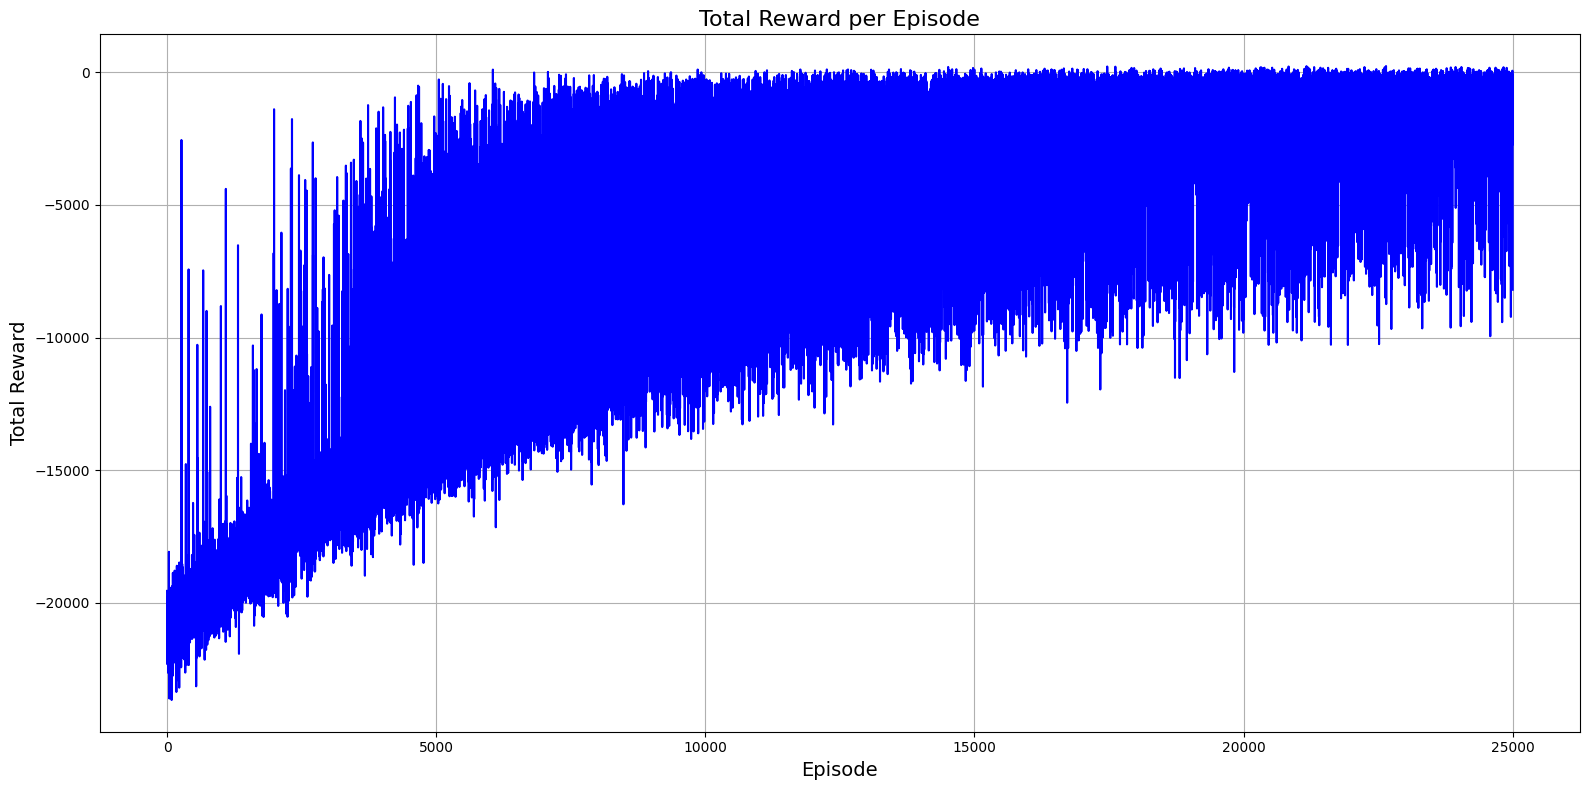

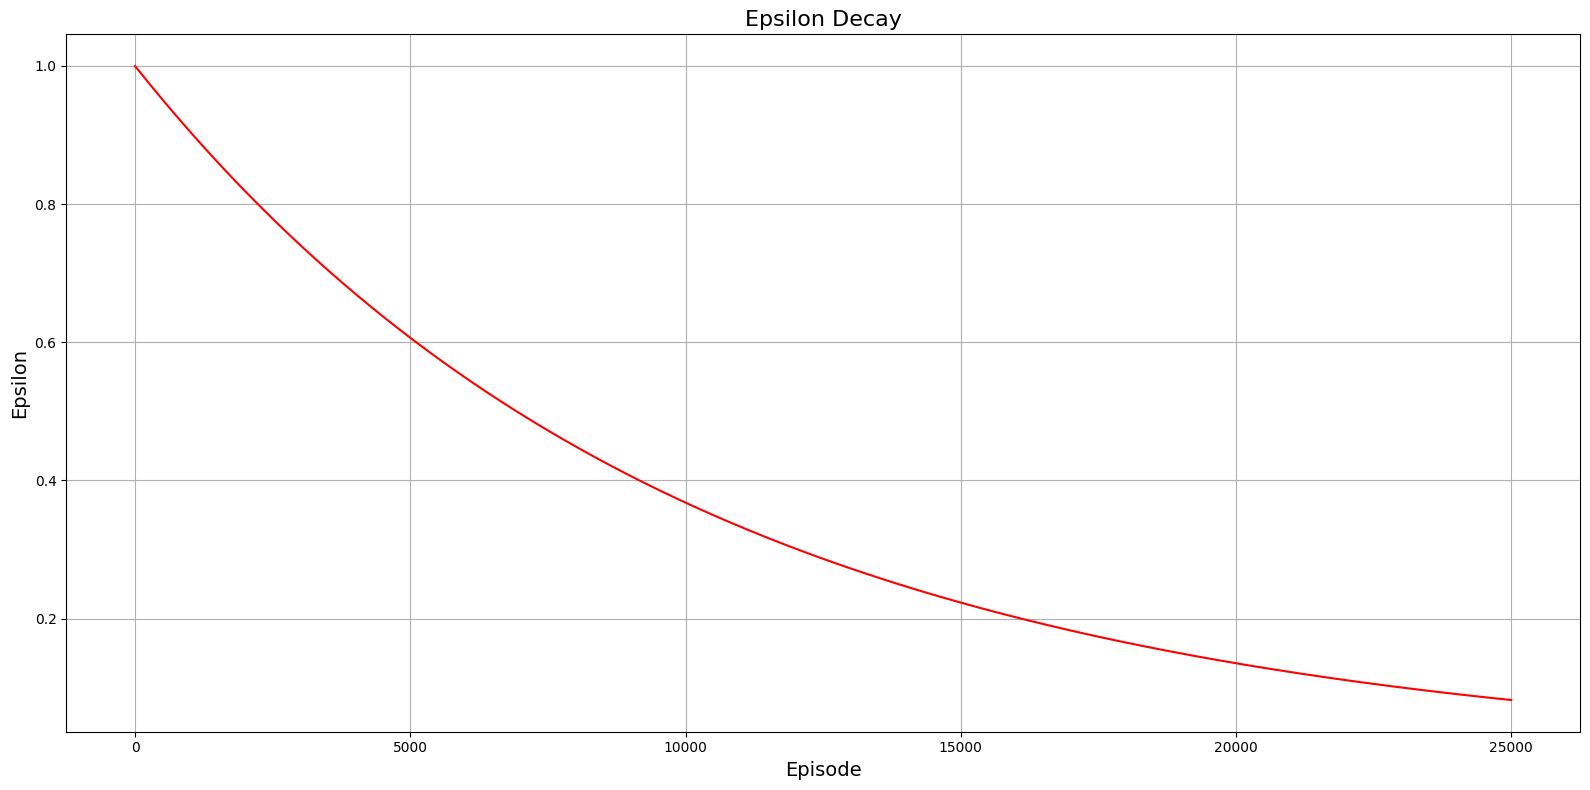

In [ ]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 56 | Total Reward: -525
Evaluation Episode 2: Steps: 410 | Total Reward: -2350
Evaluation Episode 3: Steps: 1000 | Total Reward: -4172
Evaluation Episode 4: Steps: 1000 | Total Reward: -11547
Evaluation Episode 5: Steps: 142 | Total Reward: -575
Evaluation Episode 6: Steps: 1000 | Total Reward: -6342
Evaluation Episode 7: Steps: 1000 | Total Reward: -11778
Evaluation Episode 8: Steps: 192 | Total Reward: -984
Evaluation Episode 9: Steps: 216 | Total Reward: -874
Evaluation Episode 10: Steps: 1000 | Total Reward: -10756
Evaluation Episode 11: Steps: 169 | Total Reward: -1025
Evaluation Episode 12: Steps: 223 | Total Reward: -1628
Evaluation Episode 13: Steps: 131 | Total Reward: -930
Evaluation Episode 14: Steps: 500 | Total Reward: -2585
Evaluation Episode 15: Steps: 1000 | Total Reward: -10824
Evaluation Episode 16: Steps: 786 | Total Reward: -5043
Evaluation Episode 17: Steps: 1000 | Total Reward: -12230
Evaluation Episode 18: Steps: 1000 | Total Reward: 

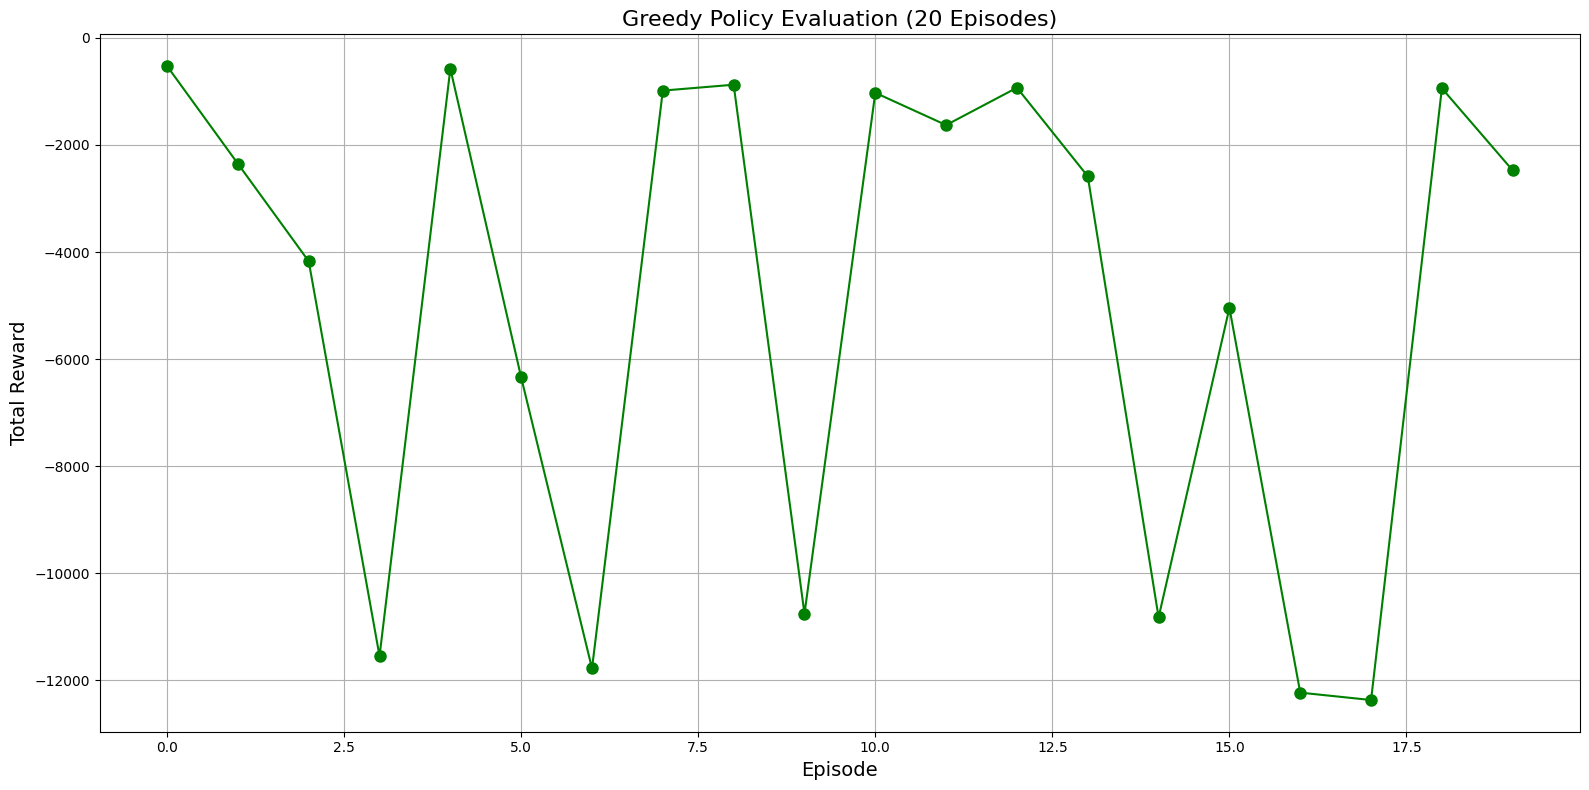

In [ ]:
# Evaluating the trained agent

deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_2_stochastic_q_table.pkl"

evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_2_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_2_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_2_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)



Evaluation Episode 1: Steps: 287 | Total Reward: -1644
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🎁 📦 ⬜ ⬇️ ⬜ ⬜
⬜ ⬜ ➡️ 🌪️ ⬅️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ 🛖
🏠 ⬜ 🚁 ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🎁 📦 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ 🛖
🏠 🚁 ⬜ ⬆️ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Evaluation Episode 1 - Step 1
Drone moved to (3, 1). Step reward: -10
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🎁 📦 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
⬜ 🚁 🌪️ ➡️ ⬜ 🛖
🏠 ⬜ ⬆️ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🎁 📦 ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ 🦅 ⬜ 🛖
🏠 🚁 ⬜ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🎁 ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ 🚁 ⬜ 🦅 ⬜ 🛖
🏠 ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 1). Step reward: -2
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
🎁 📦 ⬅️ 🌪️ ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜
⬜ ⬜ ⬜ 🦅 ⬜ 🛖
🏠 🚁 ⬜ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
🎁 ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜
⬜ 🚁 ⬜ 🦅 ⬜ 🛖
🏠 ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🎁 📦 ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️

In [ ]:
# Best hyperparameter set Rank 1 
hyperparams_1 = {   
    'alpha': 0.1,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9999,
    'epsilon_min': 0.01,
    'episodes': 50000,
    'max_steps': 1000
}

# Setting environment to stochastic mode
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))

print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
Q_stochastic_Q, rewards_stochastic_Q, eps_history_stochastic_Q = train_agent_stochastic_Q(env, hyperparams_1, hyperparams_name='hyperparams_1', render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/50000 | Eps: 0.9048 | Success in last 1K: 0.4 %
Episode 2000/50000 | Eps: 0.8187 | Success in last 1K: 2.2 %
Episode 3000/50000 | Eps: 0.7408 | Success in last 1K: 4.8 %
Episode 4000/50000 | Eps: 0.6703 | Success in last 1K: 13.6 %
Episode 5000/50000 | Eps: 0.6065 | Success in last 1K: 25.9 %
Episode 6000/50000 | Eps: 0.5488 | Success in last 1K: 41.8 %
Episode 7000/50000 | Eps: 0.4966 | Success in last 1K: 53.2 %
Episode 8000/50000 | Eps: 0.4493 | Success in last 1K: 64.6 %
Episode 9000/50000 | Eps: 0.4066 | Success in last 1K: 70.7 %
Episode 10000/50000 | Eps: 0.3679 | Success in last 1K: 76.5 %
Episode 11000/50000 | Eps: 0.3329 | Success in last 1K: 78.2 %
Episode 12000/50000 | Eps: 0.3012 | Success in last 1K: 81.0 %
Episode 13000/50000 | Eps: 0.2725 | Success in last 1K: 83.6 %
Episode 14000/50000 | Eps: 0.2466 | Success in last 1K: 86.6 %
Episode 15000/50000 | Eps: 0.2231 | Success in 

In [ ]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/hyperparams_1_stochastic_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


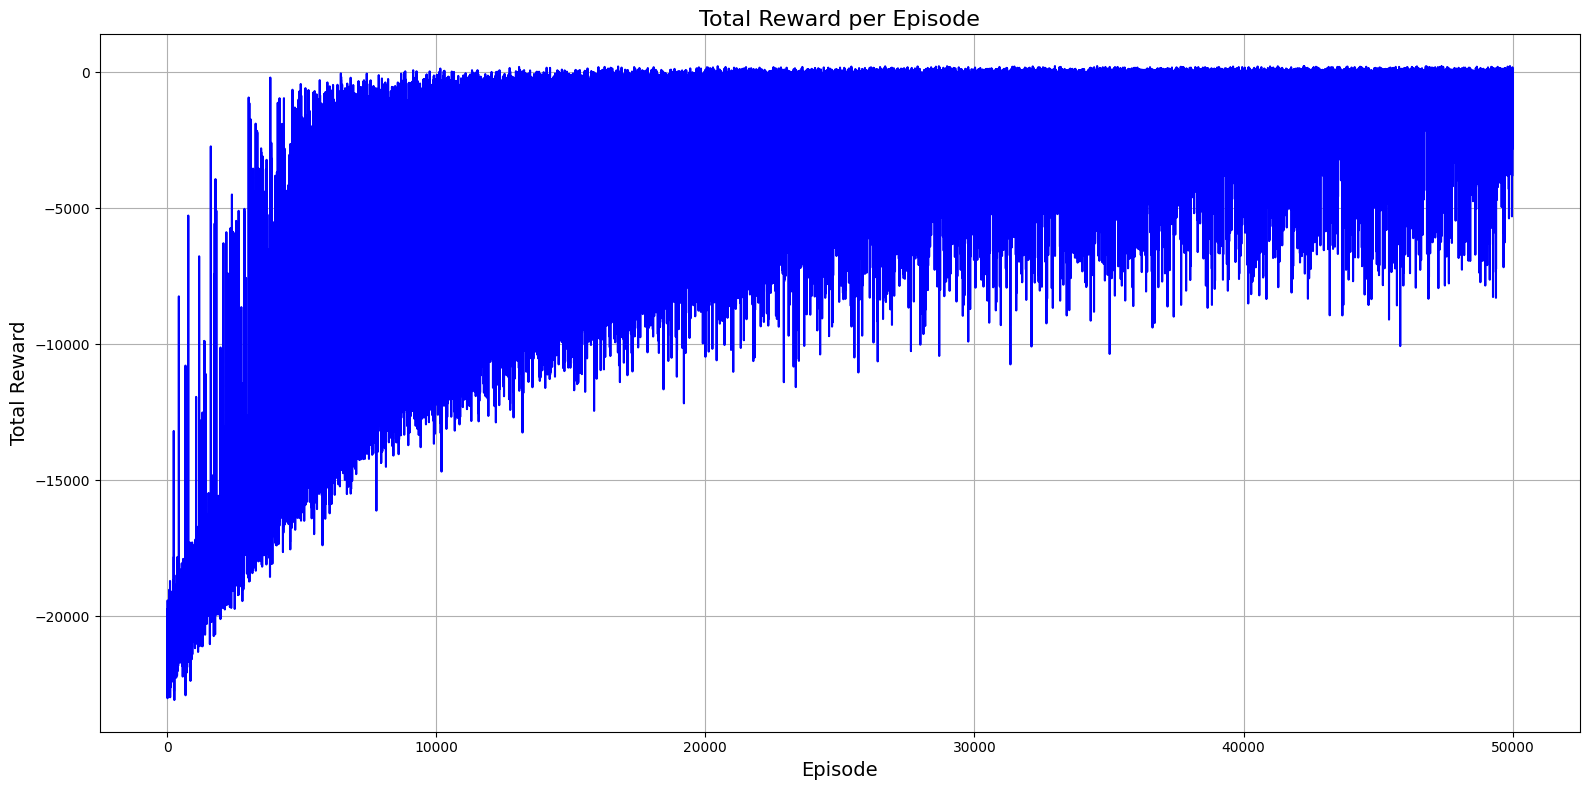

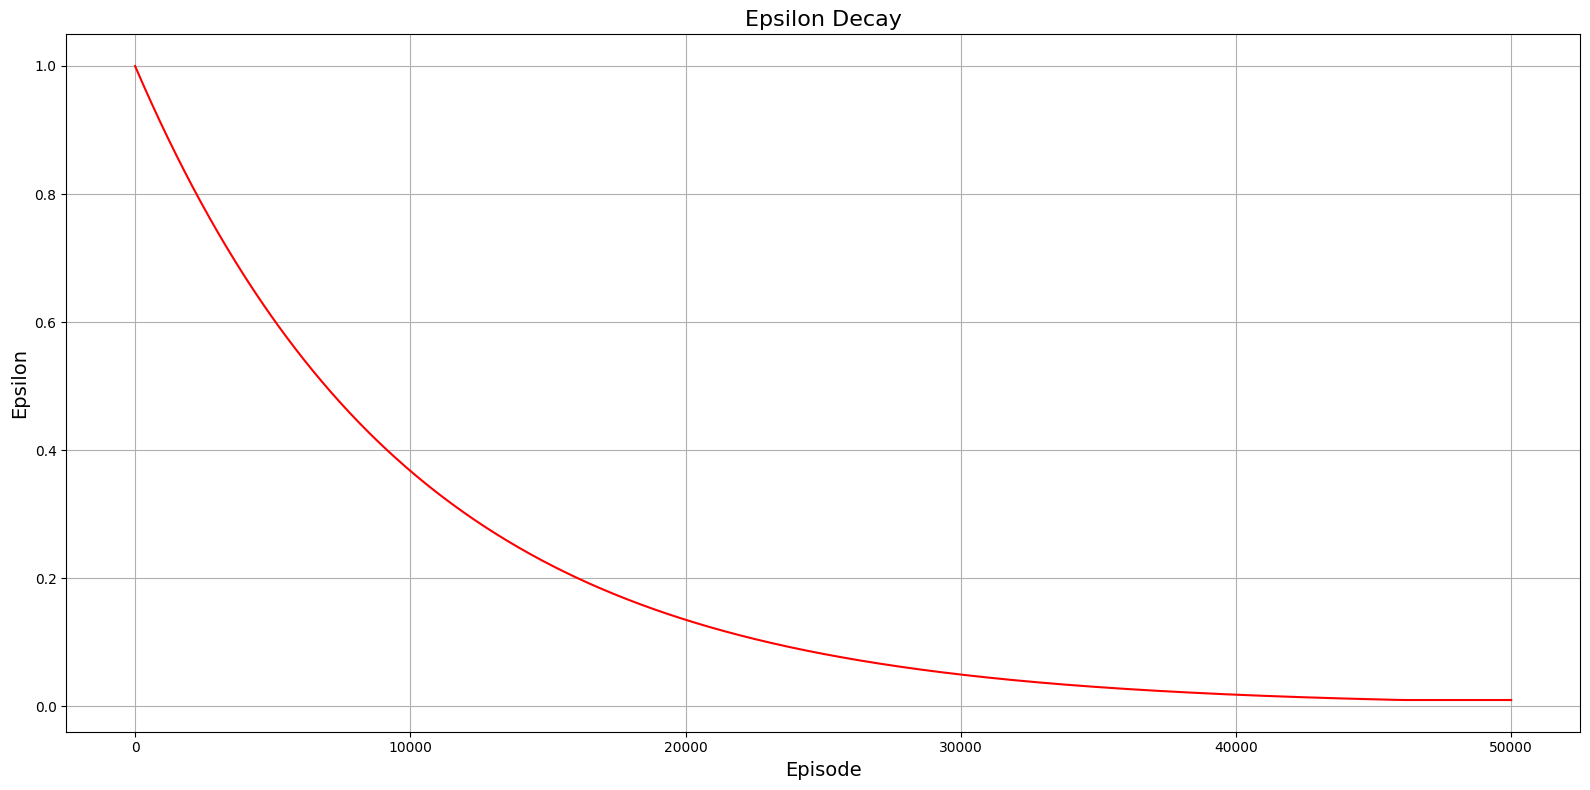

In [ ]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Episode 1: Steps: 39 | Total Reward: -41
Evaluation Episode 2: Steps: 119 | Total Reward: -417
Evaluation Episode 3: Steps: 120 | Total Reward: -629
Evaluation Episode 4: Steps: 125 | Total Reward: -545
Evaluation Episode 5: Steps: 175 | Total Reward: -413
Evaluation Episode 6: Steps: 304 | Total Reward: -1918
Evaluation Episode 7: Steps: 178 | Total Reward: -832
Evaluation Episode 8: Steps: 252 | Total Reward: -3009
Evaluation Episode 9: Steps: 184 | Total Reward: -1444
Evaluation Episode 10: Steps: 791 | Total Reward: -4463
Evaluation Episode 11: Steps: 86 | Total Reward: -646
Evaluation Episode 12: Steps: 180 | Total Reward: -897
Evaluation Episode 13: Steps: 154 | Total Reward: -822
Evaluation Episode 14: Steps: 1000 | Total Reward: -12045
Evaluation Episode 15: Steps: 50 | Total Reward: 22
Evaluation Episode 16: Steps: 331 | Total Reward: -786
Evaluation Episode 17: Steps: 1000 | Total Reward: -8963
Evaluation Episode 18: Steps: 175 | Total Reward: -888
Evaluation Episo

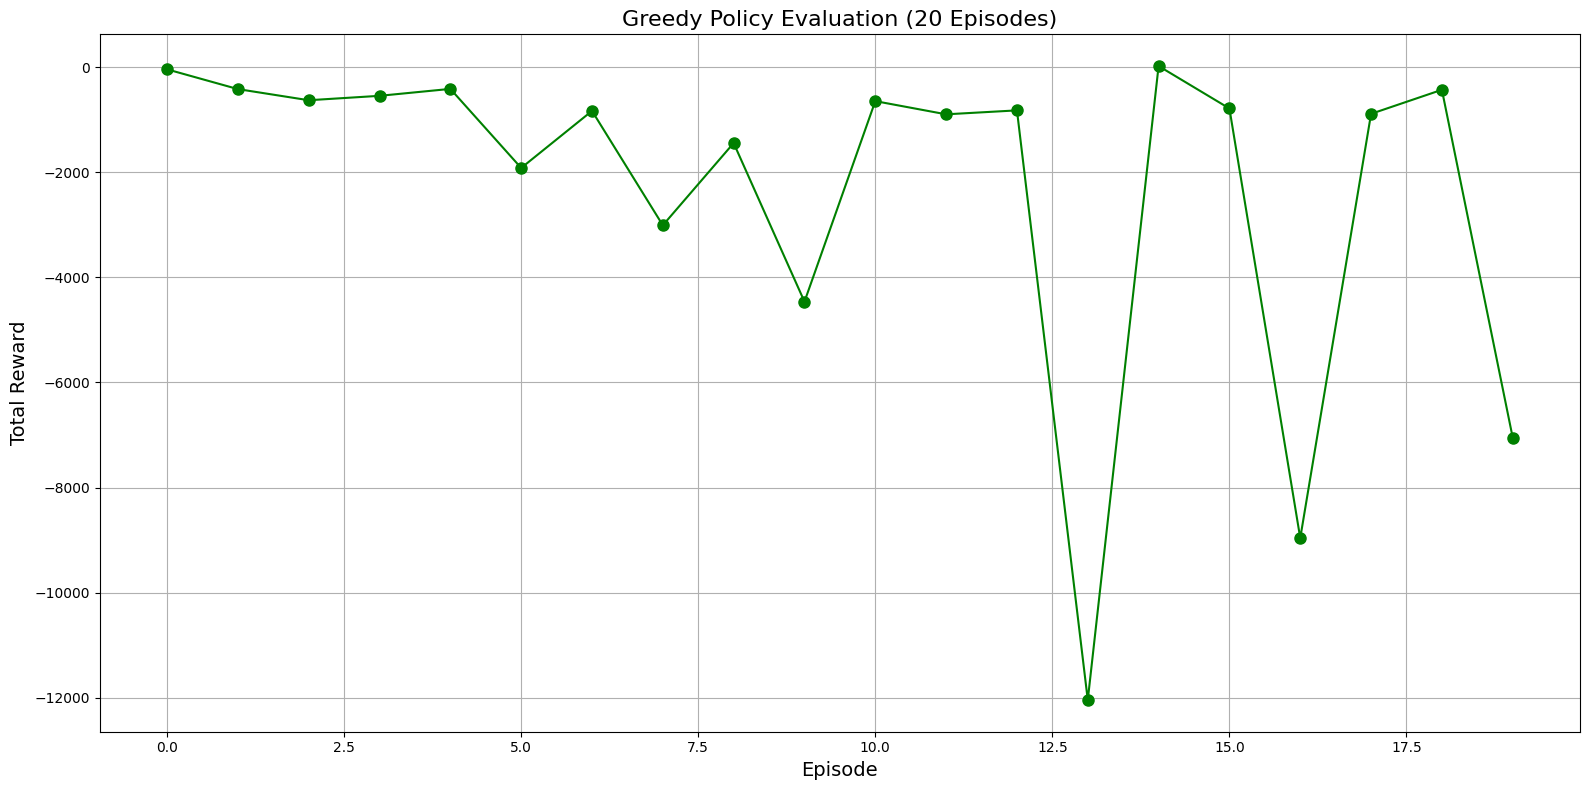

In [84]:
# Evaluating the trained agent
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_1_stochastic_q_table.pkl"


evaluation_rewards_stochastic_Q = evaluate_agent_stochastic_Q(env, q_table_filename=q_table_filename, 
                                                 episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# Rendering the trained drone in a stochastic environment
deterministic = False  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as stochastic

# Loading the trained Q-table
q_table_filename = "part_2_files/hyperparams_1_stochastic_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_hyperparams_1_stochastic_q.txt"

# Evaluating the agent and rendering the final output
final_hyperparams_1_rewards_deterministic_Q = evaluate_agent_stochastic_Q(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 76 | Total Reward: -232
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ ⬇️ ⬜ 🦅 ⬜ ⬜
➡️ 🌪️ ⬅️ ⬜ ⬜ ⬜
⬜ ⬆️ ⬜ 🏠 🦅 ⬜
⬜ ⬜ 🛖 📦 ⬜ ⬜
🎁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🚁 ⬜ ⬜

Drone moved to (5, 4). Step reward: -2
⬜ ⬜ ⬜ 🦅 ⬜ ⬜
⬜ ⬇️ ⬜ ⬜ ⬜ ⬜
⬅️ 🌪️ ➡️ 🏠 🦅 ⬜
⬜ ⬆️ 🛖 📦 ⬜ ⬜
🎁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 🚁 ⬜

Evaluation Episode 1 - Step 1
Drone moved to (4, 4). Step reward: -2
⬜ ⬇️ ⬜ 🦅 ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ ⬜
⬜ ⬆️ ⬜ 🏠 🦅 ⬜
⬜ ⬜ 🛖 📦 ⬜ ⬜
🎁 ⬜ ⬜ ⬜ 🚁 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 3). Step reward: -2
⬜ ⬇️ ⬜ 🦅 ⬜ ⬜
⬅️ 🌪️ ➡️ ⬜ ⬜ ⬜
⬜ ⬆️ ⬜ 🏠 🦅 ⬜
⬜ ⬜ 🛖 📦 ⬜ ⬜
🎁 ⬜ ⬜ 🚁 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (3, 3). Step reward: -2
⬜ ⬜ ⬇️ 🦅 ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ 🏠 🦅 ⬜
⬜ ⬜ 🛖 🚁 ⬜ ⬜
🎁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

State (3, 3, 0, 0, -1, 'destination_1', -1, 'destination_2', 'package_2', 0, 0, 0, 0) not found or has default Q-values. Choosing random valid action.
Drone moved to (3, 2). Step reward: -2
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ 🦅 ⬜
⬜ ⬜ 🚁 📦 ⬜ ⬜
🎁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone moved to (4, 2). Step reward: -2


In [90]:
def train_agent_deterministic_DoubleQ(env, hyperparams, render=False):
    """
    I train a Double Q-learning agent in a deterministic environment.
    I maintain two Q-tables (Q1 and Q2) and update them using a double Q-learning approach.
    Action selection is based on the sum of the Q-values from both tables.
    """
    filename = "part_2_files/train_agent_deterministic_DoubleQ_console_output.txt"
    
    # Extracting hyperparameters.
    alpha = hyperparams.get('alpha', 0.1)
    gamma = hyperparams.get('gamma', 0.95)
    epsilon = hyperparams.get('epsilon', 1.0)
    epsilon_decay = hyperparams.get('epsilon_decay', 0.995)
    epsilon_min = hyperparams.get('epsilon_min', 0.01)
    episodes = hyperparams.get('episodes', 500)
    max_steps = hyperparams.get('max_steps', 100)
    
    # Initializing two Q-tables.
    Q1 = defaultdict(default_q)
    Q2 = defaultdict(default_q)
    
    rewards_per_episode = []
    eps_history = []
    
    total_successful_delivery_count = 0
    success_in_last_100 = 0
    
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()
                state = get_state(env)
                total_reward = 0
                step_count = 0
                
                print(f"\n--- Training Episode {ep+1} starting ---")
                for step in range(max_steps):
                    safe_actions = [0, 1, 2, 3, 4, 5]
                    if random.random() < epsilon:
                        action = random.choice(safe_actions)
                    else:
                        combined_q = Q1[state] + Q2[state]
                        
                        safe_q = {a: combined_q[a] for a in safe_actions}
                        action = max(safe_q, key=safe_q.get)
                    
                    reward, done = env.step(action, render_env=render, print_log=True)
                    total_reward += reward
                    next_state = get_state(env)
                    
                    # Double Q-learning update.
                    if random.random() < 0.5:
                        a_max = np.argmax(Q1[next_state])
                        target = reward + gamma * Q2[next_state][a_max]
                        Q1[state][action] += alpha * (target - Q1[state][action])
                    else:
                        a_max = np.argmax(Q2[next_state])
                        target = reward + gamma * Q1[next_state][a_max]
                        Q2[state][action] += alpha * (target - Q2[state][action])
                    
                    state = next_state
                    step_count += 1
                    
                    if render and (step % 10 == 0):
                        print(f"Episode {ep+1} - Step {step+1}")
                        env.render()
                    
                    if done:
                        total_successful_delivery_count += 1
                        success_in_last_100 += 1
                        break
                
                epsilon = max(epsilon * epsilon_decay, epsilon_min)
                rewards_per_episode.append(total_reward)
                eps_history.append(epsilon)
                
                print(f"Episode {ep+1}/{episodes} | Steps: {step_count} | Total Reward: {total_reward} | Epsilon: {epsilon:.3f}")
                if (ep + 1) % 100 == 0:
                    print(f"Episode {ep+1}/{episodes} | Epsilon: {epsilon:.4f} | Success in last 100: {success_in_last_100} %", file=sys.__stdout__)
                    success_in_last_100 = 0
                    
        print(f"Task complete count: {total_successful_delivery_count} \n")
    
    q_table_filename = "part_2_files/deterministic_double_q_table.pkl"
    with open(q_table_filename, "wb") as pf:
        pickle.dump((Q1, Q2), pf)
    print(f"Double Q-tables saved to {q_table_filename}")
    
    return (Q1, Q2), rewards_per_episode, eps_history


def evaluate_agent_deterministic_DoubleQ(env, q_table_filename="part_2_files/deterministic_double_q_table.pkl", episodes=10, max_steps=100, render=True, final_render_file_name= "part_2_files/evaluate_agent_deterministic_DoubleQ_console_output.txt"):
    """
    I evaluate a Double Q-learning agent in a deterministic environment.
    I load both Q-tables from a pickle file and select actions greedily based on
    the combined Q-values.
    """
    (Q1, Q2) = None, None

    with open(q_table_filename, "rb") as pf:
        (Q1, Q2) = pickle.load(pf)
    
    rewards = []
    filename = final_render_file_name
    total_successful_delivery_count = 0
    
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()
                state = get_state(env)
                total_reward = 0
                step_count = 0
                print(f"\n--- Evaluation Episode {ep+1} starting ---")
                env.render()
                for step in range(max_steps):
                    combined_q = Q1[state] + Q2[state]
                    action = int(np.argmax(combined_q))
                    reward, done = env.step(action, render_env=render, print_log=True)
                    total_reward += reward
                    state = get_state(env)
                    step_count += 1
                    if render and (step % 10 == 0):
                        print(f"Evaluation Episode {ep+1} - Step {step+1}")
                        # env.render()
                    if done:
                        total_successful_delivery_count += 1
                        break
                
                rewards.append(total_reward)
                print(f"Evaluation Episode {ep+1}: Steps: {step_count} | Total Reward: {total_reward}", file=sys.__stdout__)
    
    print(f"Task complete count: {total_successful_delivery_count} \n")
    return rewards


In [91]:
# Choosing environment type: deterministic
deterministic = True 
env = Environment(0, 0, stochastic=(not deterministic))

# Setting hyperparameters
hyperparams = {
    'alpha': 0.01,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.995,
    'epsilon_min': 0.01,
    'episodes': 5000,
    'max_steps': 1000
}

print("Training Q-Learning agent ...")
(Q1_deterministic_DoubleQ, Q2_deterministic_DoubleQ), rewards_deterministic_DoubleQ, eps_history_deterministic_DoubleQ = train_agent_deterministic_DoubleQ(env, hyperparams, render=True)


Training Q-Learning agent ...
Episode 100/5000 | Epsilon: 0.6058 | Success in last 100: 0 %
Episode 200/5000 | Epsilon: 0.3670 | Success in last 100: 0 %
Episode 300/5000 | Epsilon: 0.2223 | Success in last 100: 0 %
Episode 400/5000 | Epsilon: 0.1347 | Success in last 100: 2 %
Episode 500/5000 | Epsilon: 0.0816 | Success in last 100: 13 %
Episode 600/5000 | Epsilon: 0.0494 | Success in last 100: 20 %
Episode 700/5000 | Epsilon: 0.0299 | Success in last 100: 39 %
Episode 800/5000 | Epsilon: 0.0181 | Success in last 100: 55 %
Episode 900/5000 | Epsilon: 0.0110 | Success in last 100: 65 %
Episode 1000/5000 | Epsilon: 0.0100 | Success in last 100: 70 %
Episode 1100/5000 | Epsilon: 0.0100 | Success in last 100: 77 %
Episode 1200/5000 | Epsilon: 0.0100 | Success in last 100: 79 %
Episode 1300/5000 | Epsilon: 0.0100 | Success in last 100: 75 %
Episode 1400/5000 | Epsilon: 0.0100 | Success in last 100: 77 %
Episode 1500/5000 | Epsilon: 0.0100 | Success in last 100: 92 %
Episode 1600/5000 | Eps

In [ ]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/deterministic_double_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


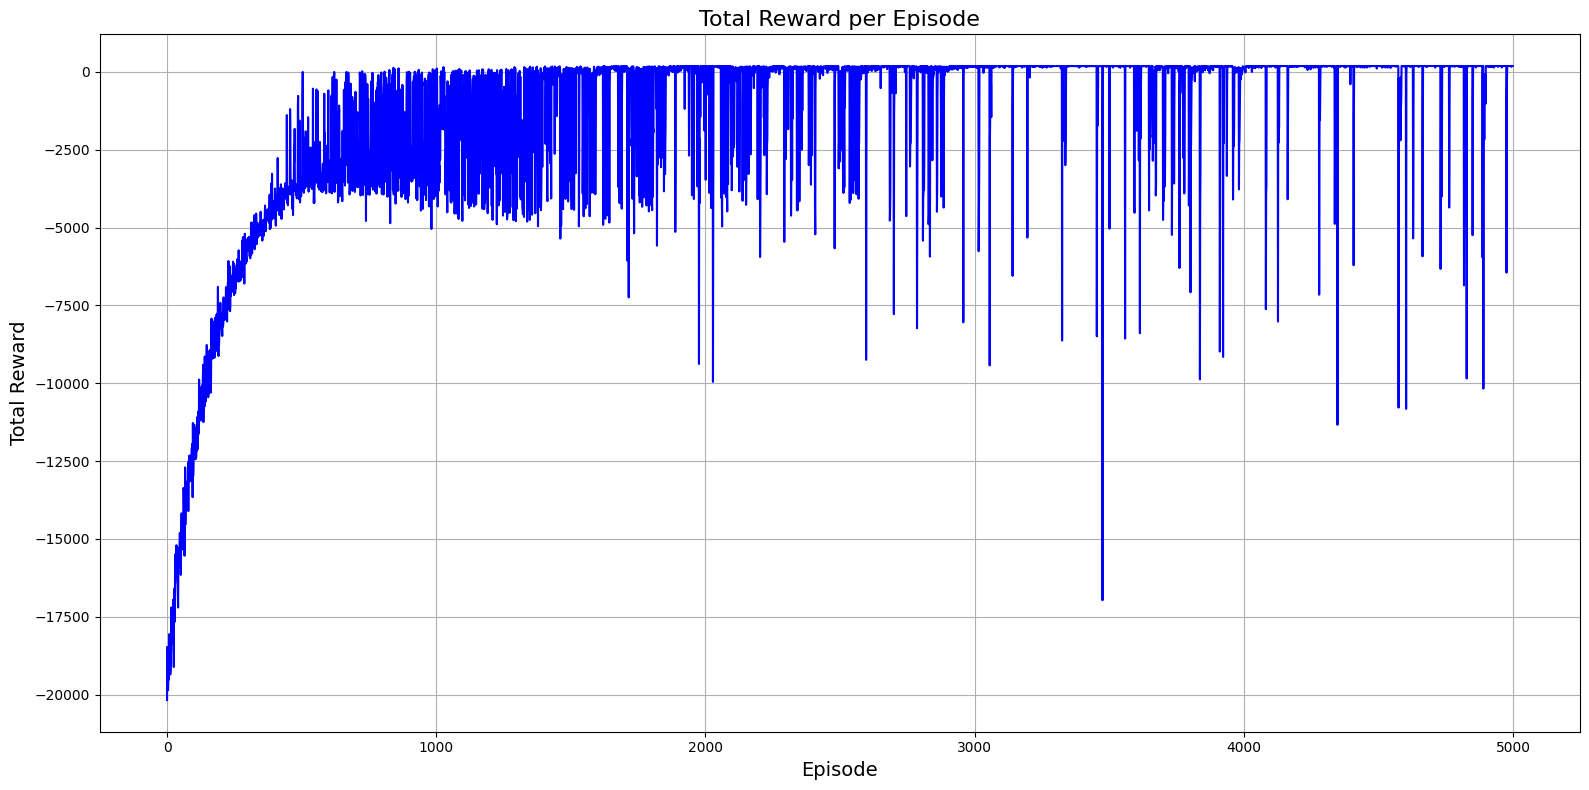

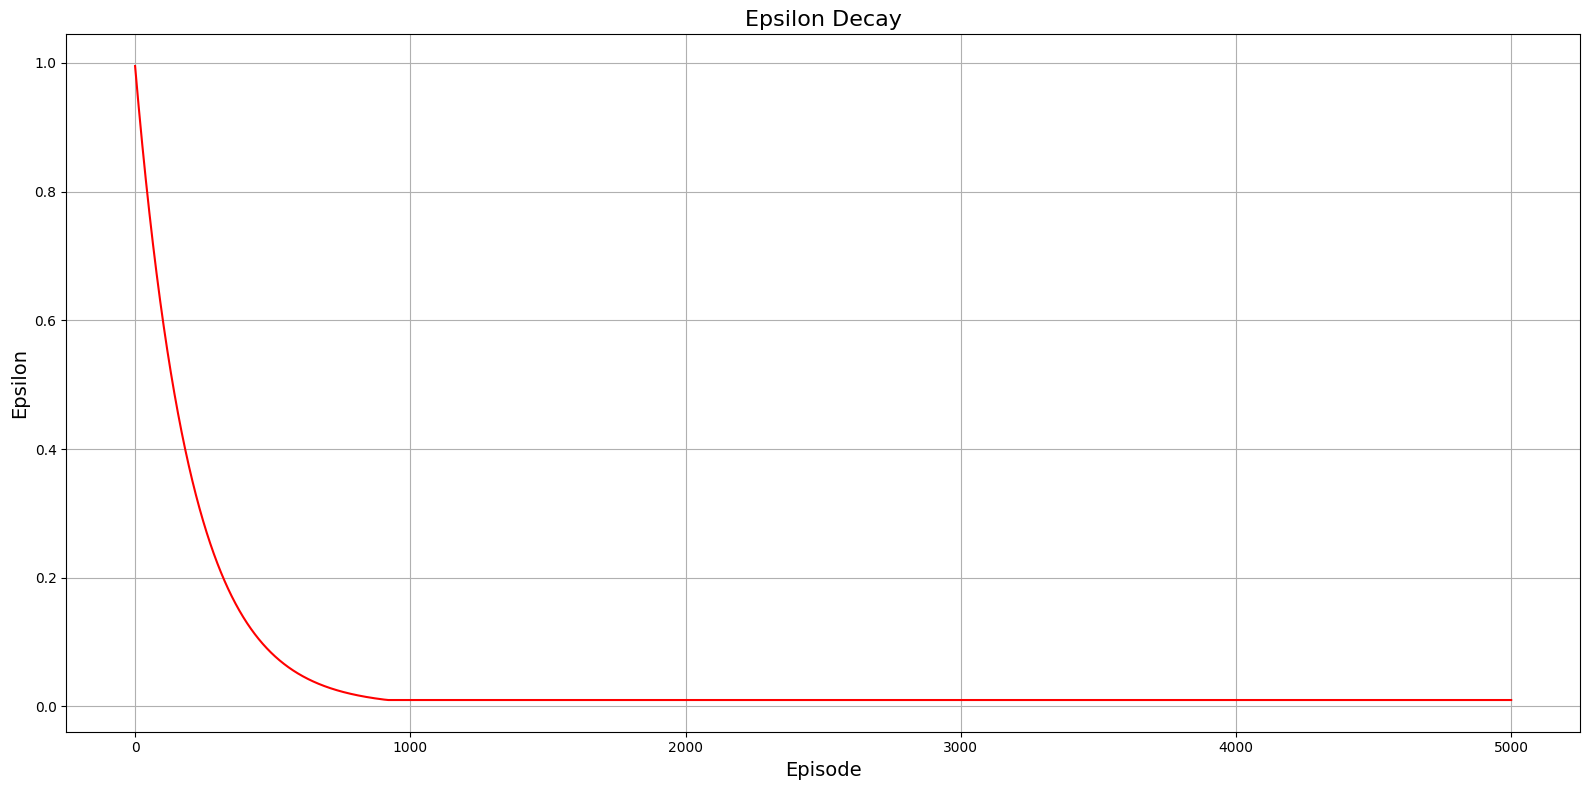

In [92]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_deterministic_DoubleQ, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_deterministic_DoubleQ, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation Episode 1: Steps: 24 | Total Reward: 187
Evaluation Episode 2: Steps: 24 | Total Reward: 187
Evaluation Episode 3: Steps: 24 | Total Reward: 187
Evaluation Episode 4: Steps: 24 | Total Reward: 187
Evaluation Episode 5: Steps: 24 | Total Reward: 187
Evaluation Episode 6: Steps: 24 | Total Reward: 187
Evaluation Episode 7: Steps: 24 | Total Reward: 187
Evaluation Episode 8: Steps: 24 | Total Reward: 187
Evaluation Episode 9: Steps: 24 | Total Reward: 187
Evaluation Episode 10: Steps: 24 | Total Reward: 187
Task complete count: 10 



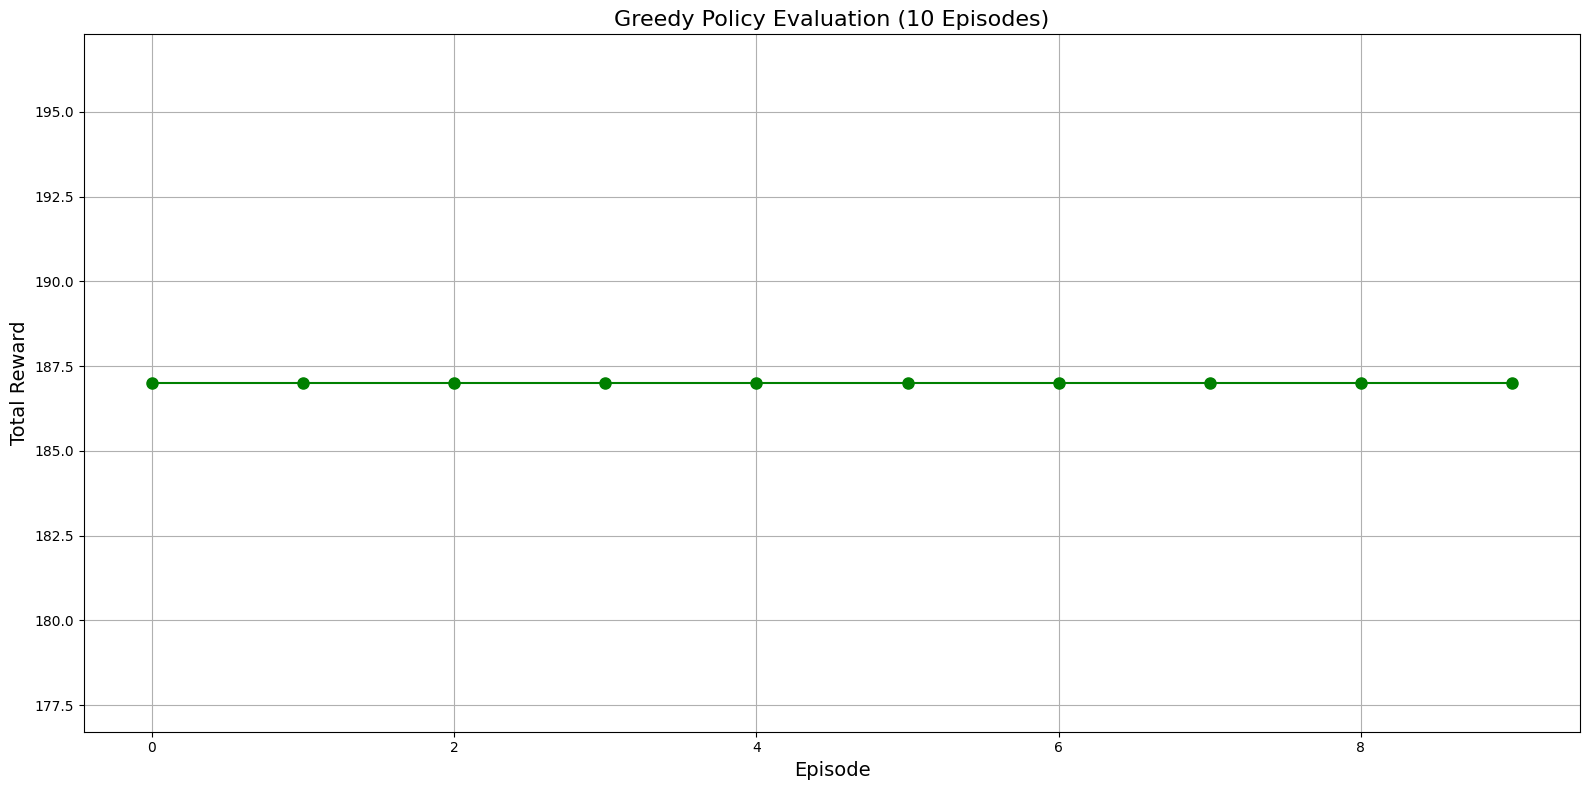

In [93]:
# Evaluating the trained agent using a greedy policy

deterministic = True 
env = Environment(0, 0, stochastic=(not deterministic))

q_table_filename = "part_2_files/deterministic_double_q_table.pkl"

evaluation_rewards_deterministic_DoubleQ = evaluate_agent_deterministic_DoubleQ(env, 
                                                          q_table_filename=q_table_filename,
                                                          episodes=10, max_steps=1000, render=True)

# Plotting greedy policy evaluation results
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_deterministic_DoubleQ, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (10 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
# Rendering the trained drone in a deterministic environment
deterministic = True  
env = Environment(0, 0, stochastic=(not deterministic))  # Setting up the environment as deterministic

# Loading the trained Q-table
q_table_filename = "part_2_files/deterministic_double_q_table.pkl"

# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_agent_deterministic_double_q.txt"

# Evaluating the agent and rendering the final output
final_evaluation_deterministic_Q = evaluate_agent_deterministic_DoubleQ(
    env, q_table_filename=q_table_filename, episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name
)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 24 | Total Reward: 187
Task complete count: 1 


--- Evaluation Episode 1 starting ---
🚁 ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ➡️ 🌪️ ⬅️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (0, 1). Step reward: -2
⬜ 🚁 ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Evaluation Episode 1 - Step 1
Drone moved to (1, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ 🚁 ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (1, 2). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ 🚁 ⬜ ⬜ 🦅
⬜ ⬜ 🎁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (2, 2). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ 🚁 ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Picked up package 1 for 25 reward
Drone moved to (2, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ 🚁 ⬜ ⬇️ ⬜ ⬜
⬜ ⬜ ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (3, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ ⬜ 🛖
⬜ ⬜ ⬜ ⬜ ⬜ 🦅
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
⬜ 🚁 ⬅️ 🌪️ ➡️ ⬜
⬜ 📦 ⬜ ⬆️ ⬜ ⬜
⬜ 🦅 ⬜ ⬜ ⬜ 🏠

Drone moved to (4, 1). Step reward: -2
⬜

In [98]:

def train_agent_stochastic_DoubleQ(env, hyperparams, render=False):
    """
    I train a Double Q-learning agent in a stochastic environment.
    I maintain two Q-tables (Q1 and Q2) and update one of them at random
    at each step to reduce overestimation bias. Action selection is based on
    the combined Q-values (Q1 + Q2) using an epsilon-greedy strategy.
    I also apply a penalty for repetitive actions.
    """
    filename = "part_2_files/train_agent_stochastic_DoubleQ_console_output.txt"
    
    # Extracting hyperparameters.
    alpha = hyperparams.get('alpha', 0.1)           # Learning rate
    gamma = hyperparams.get('gamma', 0.95)            # Discount factor
    epsilon = hyperparams.get('epsilon', 1.0)         # Initial exploration rate
    epsilon_decay = hyperparams.get('epsilon_decay', 0.995)
    epsilon_min = hyperparams.get('epsilon_min', 0.01)
    episodes = hyperparams.get('episodes', 500)
    max_steps = hyperparams.get('max_steps', 100)
    repetition_penalty = hyperparams.get('repetition_penalty', -50)
    
    total_successful_delivery_count = 0
    success_in_last_1K = 0
    
    # Initializing two Q-tables.
    Q1 = defaultdict(default_q)
    Q2 = defaultdict(default_q)
    
    rewards_per_episode = []
    eps_history = []
    
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()                      # Reset environment.
                state = get_state(env)               # Get initial state.
                total_reward = 0
                step_count = 0
                
                # Tracking repeated actions.
                last_action = None
                repeat_count = 0
                
                print(f"\n--- Training Episode {ep+1} starting ---")
                
                for step in range(max_steps):
                    safe_actions = [0, 1, 2, 3, 4, 5]
                    
                    # Epsilon-greedy: choosing a random action with probability epsilon.
                    if random.random() < epsilon:
                        action = random.choice(safe_actions)
                    else:
                        # Using combined Q-values for greedy selection.
                        combined_q = Q1[state] + Q2[state]
                        safe_q = {a: combined_q[a] for a in safe_actions}
                        action = max(safe_q, key=safe_q.get)
                    
                    # Checking for repeated actions.
                    if last_action is not None and action == last_action:
                        repeat_count += 1
                    else:
                        repeat_count = 1
                    last_action = action
                    
                    # Executing the chosen action.
                    reward, done = env.step(action, render_env=render, print_log=True)
                    
                    # Applying penalty if the same action repeats 3+ times.
                    if repeat_count >= 3:
                        reward += repetition_penalty
                        print(f"Repetition penalty applied: {repetition_penalty} (repeat_count={repeat_count})")
                    
                    total_reward += reward
                    next_state = get_state(env)
                    
                    # Double Q-learning update: randomly update Q1 or Q2.
                    if random.random() < 0.5:
                        a_max = np.argmax(Q1[next_state])
                        target = reward + gamma * Q2[next_state][a_max]
                        Q1[state][action] += alpha * (target - Q1[state][action])
                    else:
                        a_max = np.argmax(Q2[next_state])
                        target = reward + gamma * Q1[next_state][a_max]
                        Q2[state][action] += alpha * (target - Q2[state][action])
                    
                    state = next_state
                    step_count += 1
                    
                    if render and (step % 10 == 0):
                        print(f"Episode {ep+1} - Step {step+1}")
                    
                    if done:
                        total_successful_delivery_count += 1
                        success_in_last_1K += 1
                        break
                
                # Decay epsilon.
                epsilon = max(epsilon * epsilon_decay, epsilon_min)
                rewards_per_episode.append(total_reward)
                eps_history.append(epsilon)
                
                print(f"Episode {ep+1}/{episodes} | Steps: {step_count} | Total Reward: {total_reward} | Epsilon: {epsilon:.3f}")
                if (ep + 1) % 1000 == 0:
                    print(f"Episode {ep+1}/{episodes} | Epsilon: {epsilon:.4f} | Success in last 1K: {success_in_last_1K/10} %", file=sys.__stdout__)
                    success_in_last_1K = 0
                    
        print(f"Task complete count: {total_successful_delivery_count} \n")
    
    # Saving both Q-tables as a tuple.
    q_table_filename = "part_2_files/stochastic_double_q_table.pkl"
    with open(q_table_filename, "wb") as pf:
        pickle.dump((Q1, Q2), pf)
    print(f"Double Q-tables saved to {q_table_filename}")
    
    return (Q1, Q2), rewards_per_episode, eps_history


def evaluate_agent_stochastic_DoubleQ(env, q_table_filename="part_2_files/stochastic_double_q_table.pkl", episodes=10, max_steps=100, render=True, final_render_file_name="part_2_files/evaluate_agent_stochastic_DoubleQ_console_output.txt"):
    """
    I evaluate a Double Q-learning agent in a stochastic environment.
    I load both Q-tables from a pickle file and use the sum of their Q-values
    for greedy action selection.
    """

    (Q1, Q2) = None, None
    
    with open(q_table_filename, "rb") as pf:
        (Q1, Q2) = pickle.load(pf)
    
    rewards = []
    repetition_threshold = 4  # For preventing looping
    valid_actions = [0, 1, 2, 3, 4, 5]
    filename = final_render_file_name
    total_successful_delivery_count = 0
    
    with open(filename, "w") as f:
        with contextlib.redirect_stdout(f):
            for ep in range(episodes):
                env.reset_env()
                state = get_state(env)
                total_reward = 0
                step_count = 0
                last_action = None
                repeat_count = 0
                print(f"\n--- Evaluation Episode {ep+1} starting ---")
                env.render()
                for step in range(max_steps):
                    if state not in Q1 or (np.all(Q1[state] == 0) and np.all(Q2[state] == 0)):
                        print(f"State {state} not found or has default Q-values. Choosing random valid action.")
                        action = random.choice(valid_actions)
                    else:
                        combined_q = Q1[state] + Q2[state]
                        action = int(np.argmax(combined_q))
                    
                    # Checking for repeated actions.
                    if last_action is not None and action == last_action:
                        repeat_count += 1
                    else:
                        repeat_count = 1
                    last_action = action
                    if repeat_count >= repetition_threshold:
                        print(f"Action {action} repeated {repeat_count} times. Switching to a new action.")
                        action = random.choice(valid_actions)
                        repeat_count = 1
                    
                    reward, done = env.step(action, render_env=render, print_log=True)
                    total_reward += reward
                    state = get_state(env)
                    step_count += 1
                    if render and (step % 10 == 0):
                        print(f"Evaluation Episode {ep+1} - Step {step+1}")
                    if done:
                        total_successful_delivery_count += 1
                        break
                
                rewards.append(total_reward)
                print(f"Evaluation Episode {ep+1}: Steps: {step_count} | Total Reward: {total_reward}", file=sys.__stdout__)
    
    print(f"Task complete count: {total_successful_delivery_count} \n")
    return rewards


In [99]:
# Best hyperparams 1
hyperparams = {   
                'alpha': 0.1,
                'gamma': 0.95,
                'epsilon': 1.0,
                'epsilon_decay': 0.9999,
                'epsilon_min': 0.01,
                'episodes': 50000,
                'max_steps': 1000
            }
            

deterministic = False  # Set to False for stochastic mode.
env = Environment(0, 0, stochastic=(not deterministic))


print("Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...")
(Q1_stochastic_DoubleQ, Q2_stochastic_DoubleQ), rewards_stochastic_DoubleQ, eps_history_stochastic_DoubleQ = train_agent_stochastic_DoubleQ(env, hyperparams, render=False)

Training Q-Learning agent (Stochastic Environment with Sensor-Augmented State) ...
Episode 1000/50000 | Epsilon: 0.9048 | Success in last 1K: 1.2 %
Episode 2000/50000 | Epsilon: 0.8187 | Success in last 1K: 2.6 %
Episode 3000/50000 | Epsilon: 0.7408 | Success in last 1K: 4.2 %
Episode 4000/50000 | Epsilon: 0.6703 | Success in last 1K: 11.4 %
Episode 5000/50000 | Epsilon: 0.6065 | Success in last 1K: 24.5 %
Episode 6000/50000 | Epsilon: 0.5488 | Success in last 1K: 33.5 %
Episode 7000/50000 | Epsilon: 0.4966 | Success in last 1K: 47.2 %
Episode 8000/50000 | Epsilon: 0.4493 | Success in last 1K: 59.9 %
Episode 9000/50000 | Epsilon: 0.4066 | Success in last 1K: 68.2 %
Episode 10000/50000 | Epsilon: 0.3679 | Success in last 1K: 73.5 %
Episode 11000/50000 | Epsilon: 0.3329 | Success in last 1K: 78.5 %
Episode 12000/50000 | Epsilon: 0.3012 | Success in last 1K: 81.6 %
Episode 13000/50000 | Epsilon: 0.2725 | Success in last 1K: 85.4 %
Episode 14000/50000 | Epsilon: 0.2466 | Success in last 1K

In [100]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_2_files/stochastic_double_q_table.pkl"

# print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

# Q = defaultdict(default_q)
# for k, v in Q.items():
#     print(k, v)

# # Loading the Q-table from the pickle file
# with open(q_table_filename, "rb") as pf:
#     Q = pickle.load(pf)

# # Printing the final Q-table
# print("\nTrained Q-table (for visited states):\n")
# for k, v in Q.items():
#     print(k, v)


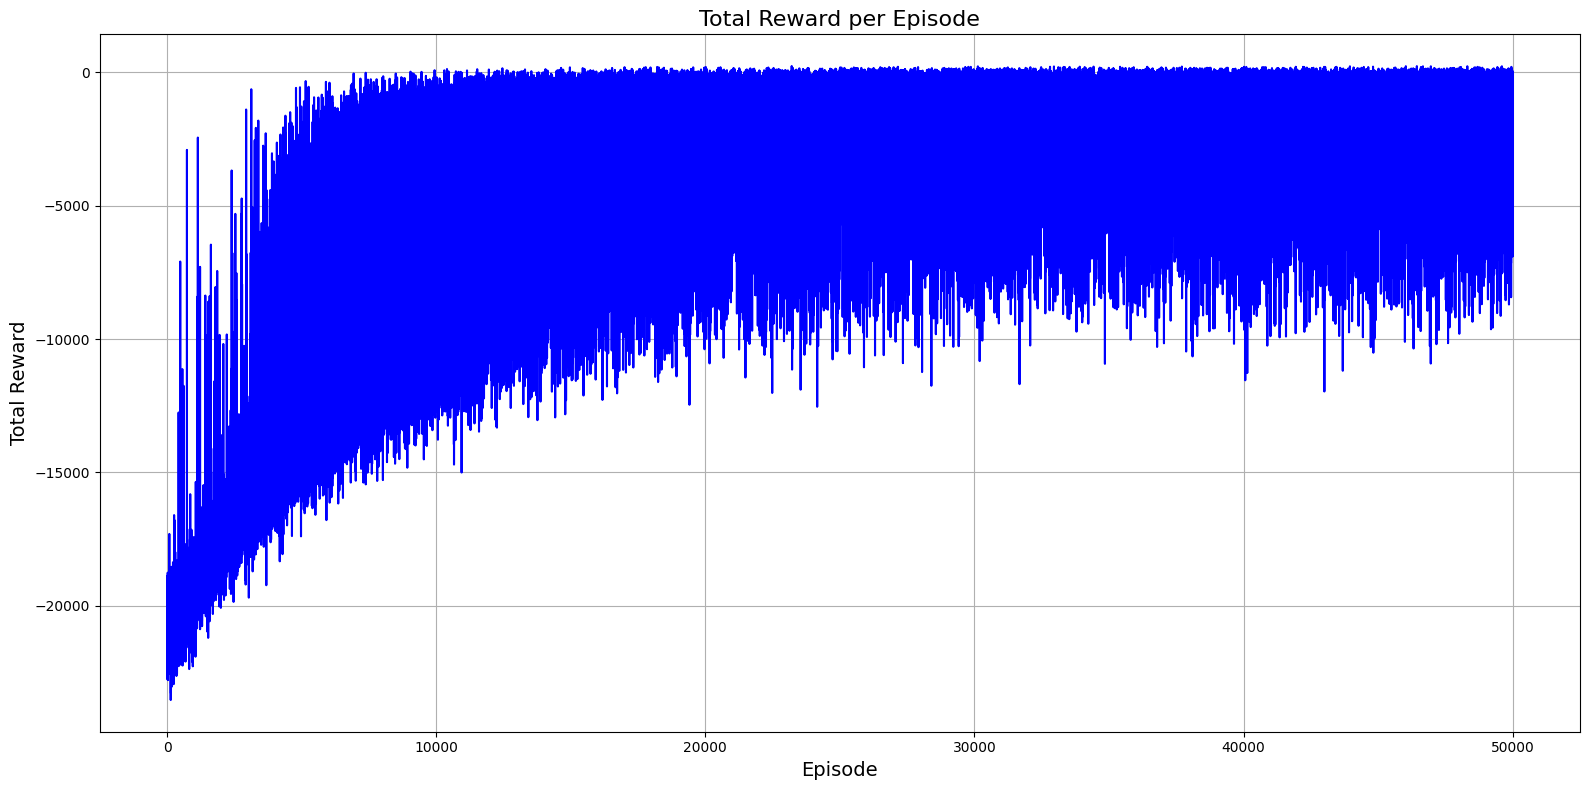

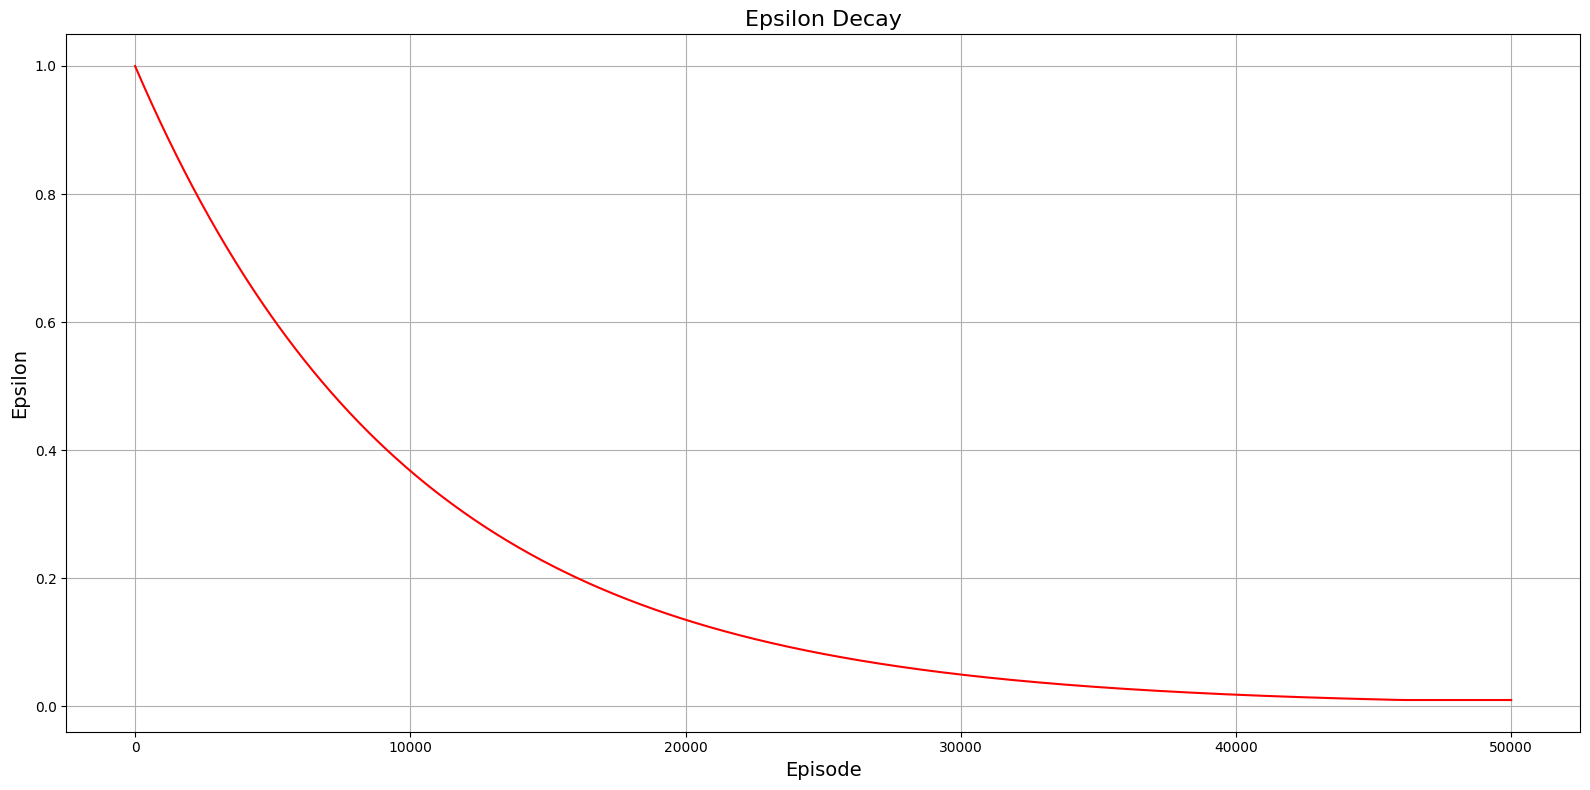

In [101]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_DoubleQ, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_DoubleQ, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation Episode 1: Steps: 78 | Total Reward: -381
Evaluation Episode 2: Steps: 285 | Total Reward: -1549
Evaluation Episode 3: Steps: 1000 | Total Reward: -12207
Evaluation Episode 4: Steps: 198 | Total Reward: -1974
Evaluation Episode 5: Steps: 1000 | Total Reward: -12274
Evaluation Episode 6: Steps: 1000 | Total Reward: -11925
Evaluation Episode 7: Steps: 115 | Total Reward: -1012
Evaluation Episode 8: Steps: 1000 | Total Reward: -11504
Evaluation Episode 9: Steps: 402 | Total Reward: -3961
Evaluation Episode 10: Steps: 1000 | Total Reward: -12002
Evaluation Episode 11: Steps: 1000 | Total Reward: -11846
Evaluation Episode 12: Steps: 523 | Total Reward: -3840
Evaluation Episode 13: Steps: 61 | Total Reward: -473
Evaluation Episode 14: Steps: 1000 | Total Reward: -10865
Evaluation Episode 15: Steps: 1000 | Total Reward: -10882
Evaluation Episode 16: Steps: 1000 | Total Reward: -12315
Evaluation Episode 17: Steps: 43 | Total Reward: 20
Evaluation Episode 18: Steps: 1000 | Total Rewa

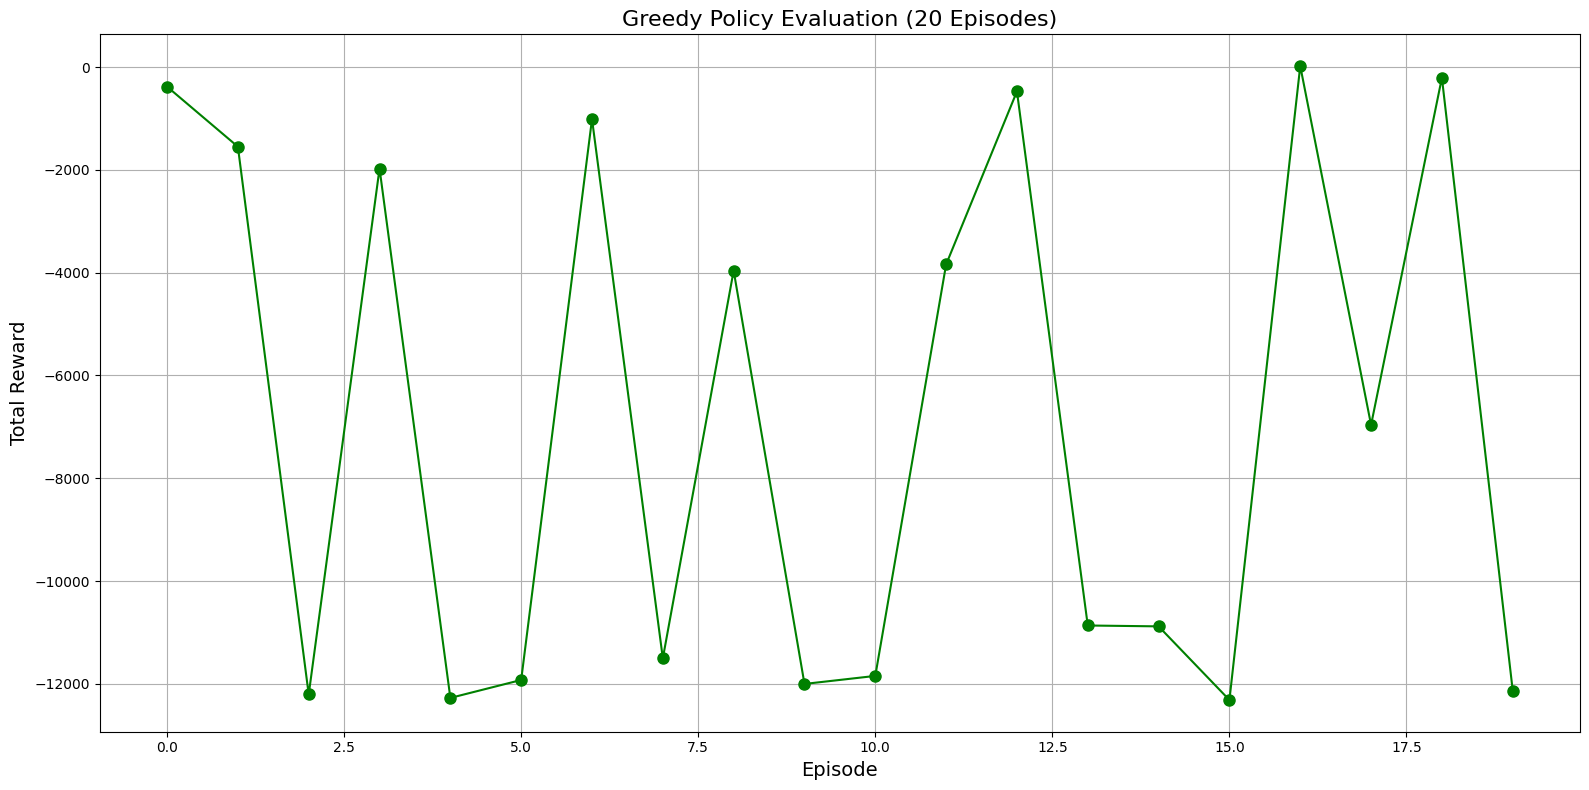

In [102]:
# Evaluating the trained agent using a greedy policy

deterministic = False  # Set to False for stochastic mode.
env = Environment(0, 0, stochastic=(not deterministic))

q_table_filename = "part_2_files/stochastic_double_q_table.pkl"

evaluation_rewards_stochastic_DoubleQ = evaluate_agent_stochastic_DoubleQ(env, 
                                                       q_table_filename=q_table_filename, 
                                                       episodes=20, max_steps=1000, render=True)

# Plotting greedy policy evaluation results
plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_DoubleQ, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [105]:
# Rendering the trained drone in a stochastic environment
deterministic = False  # Set to False for stochastic mode.
env = Environment(0, 0, stochastic=(not deterministic))

q_table_filename = "part_2_files/stochastic_double_q_table.pkl"


# File to save the final evaluation results
final_render_file_name = "part_2_files/final_evaluate_stochastic_double_q.txt"

# Evaluating the agent and rendering the final output

final_evaluation_stochastic_DoubleQ = evaluate_agent_stochastic_DoubleQ(env, 
                                                       q_table_filename=q_table_filename, 
                                                       episodes=1, max_steps=1000, render=True, final_render_file_name=final_render_file_name)

# Reading and printing the final evaluation results
with open(final_render_file_name, "r") as file:
    content = file.read()
    print(content)


Evaluation Episode 1: Steps: 52 | Total Reward: -319
Task complete count: 1 


--- Evaluation Episode 1 starting ---
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
🛖 ⬜ 🚁 ⬜ ⬜ ⬜
⬜ 🎁 📦 ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🦅 ⬇️ ⬜
⬜ 🏠 ⬜ ➡️ 🌪️ ⬅️
⬜ ⬜ ⬜ ⬜ ⬆️ ⬜

Drone moved to (2, 2). Step reward: -2
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
🛖 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🎁 🚁 ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🦅 ⬇️ ⬜
⬜ 🏠 ⬜ ⬅️ 🌪️ ➡️
⬜ ⬜ ⬜ ⬜ ⬆️ ⬜

Evaluation Episode 1 - Step 1
Picked up package 2 for 25 reward
Drone moved to (2, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
🛖 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🚁 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬇️ ⬜ ⬜
⬜ 🏠 ⬅️ 🌪️ ➡️ ⬜
⬜ ⬜ ⬜ ⬆️ ⬜ ⬜

Picked up package 1 for 25 reward
Drone moved to (2, 0). Step reward: -2
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
🛖 ⬜ ⬜ ⬜ ⬜ ⬜
🚁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ 🦅 ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ ⬜ ⬆️ ⬜ ⬜ ⬜

Drone moved to (1, 0). Step reward: -2
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
🚁 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬇️ ⬜ ⬜ ⬜
⬜ ⬅️ 🌪️ ➡️ ⬜ ⬜
⬜ 🏠 ⬆️ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Dropped package_1 incorrectly. Penalty -50
Delivered package_2 for +100 reward
Picked up package 1 for 25 reward
Drone moved to (1, 1). Step reward: -2
⬜ ⬜ ⬜ ⬜ 🦅 ⬜
✅ 🚁 ⬜ ⬜ ⬜ ⬜
⬜ ⬇️ ⬜ ⬜ ⬜ ⬜
⬅️ 🌪️ ➡️ 🦅 ⬜ ⬜
⬜ ⬆️ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜

Drone mov

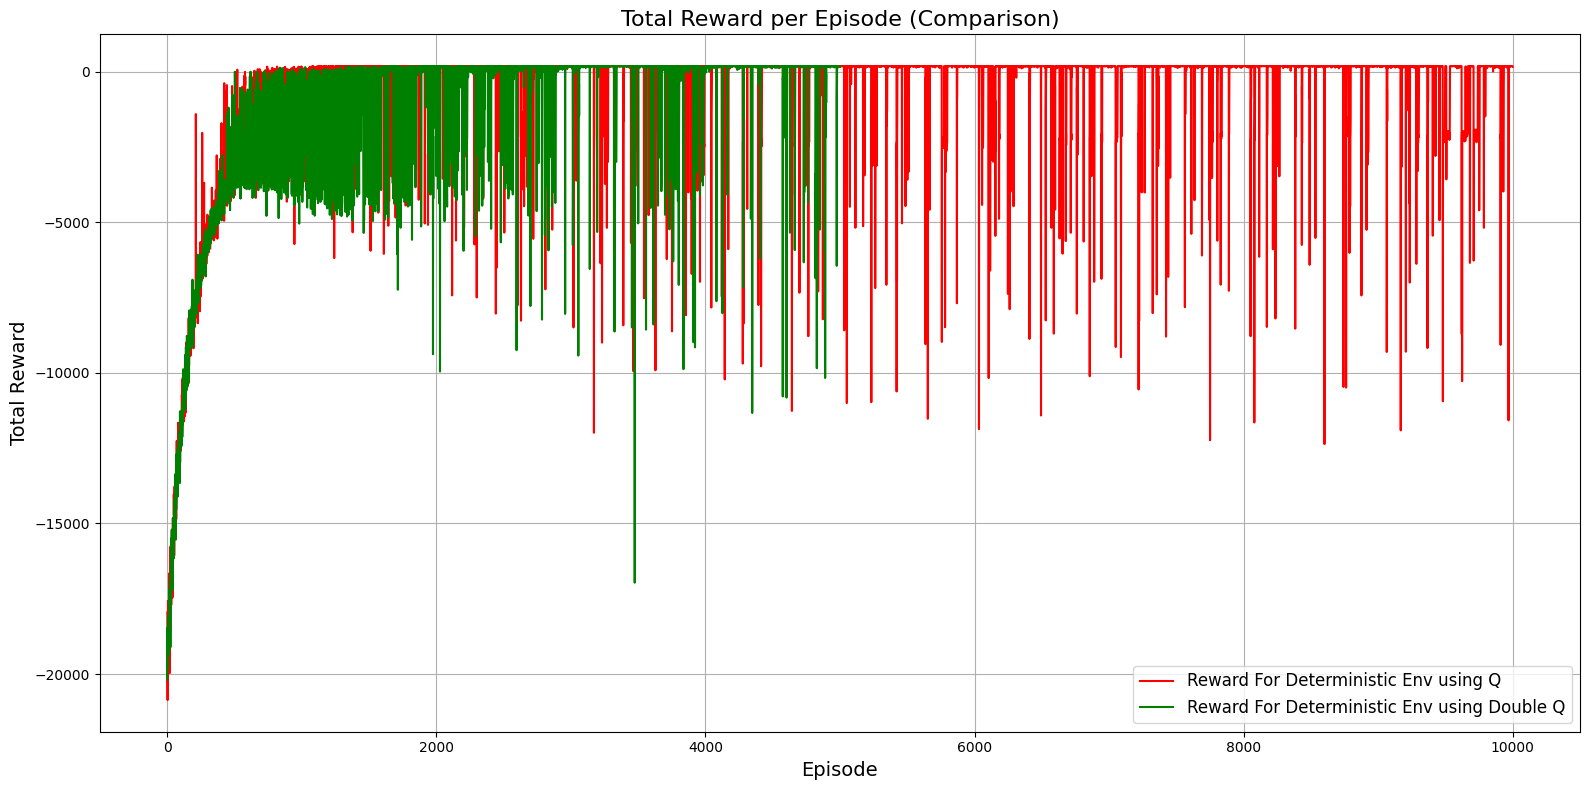

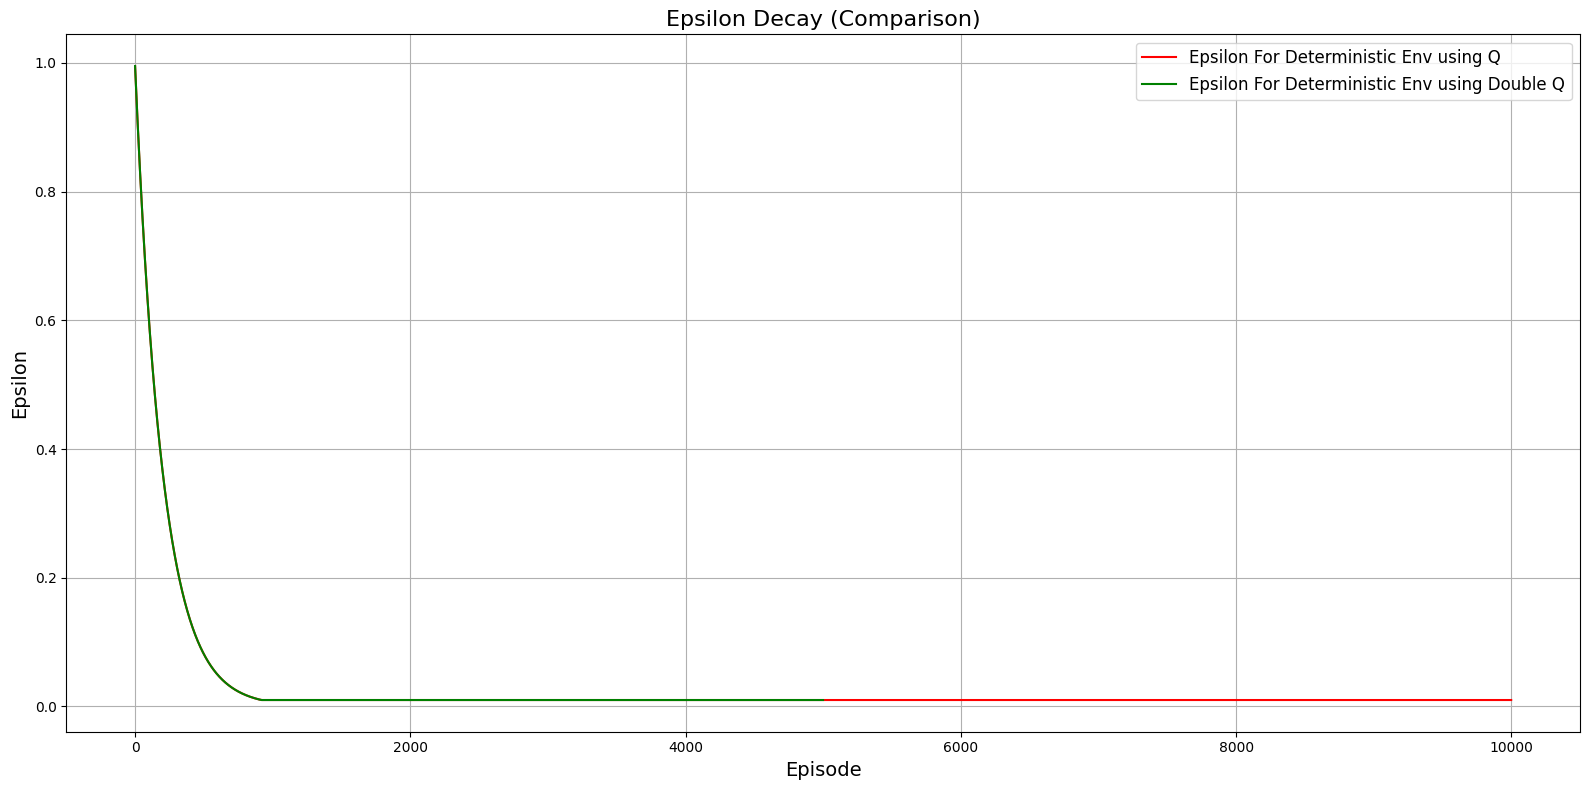

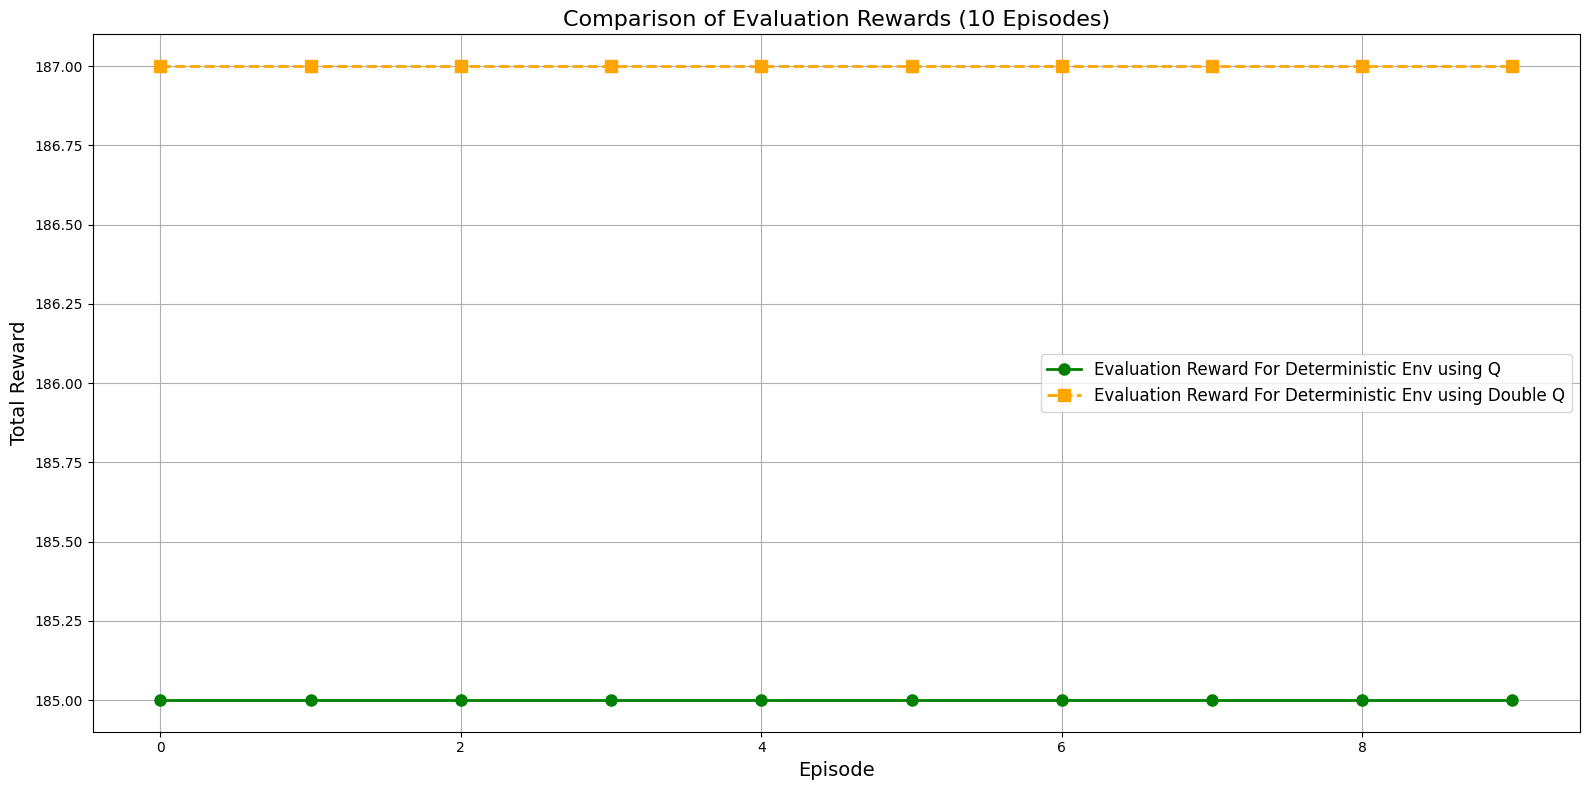

In [95]:
# --- Combined Graph for Total Reward per Episode ---

plt.figure(figsize=(16,8))
plt.plot(rewards_deterministic_Q, color='red', linewidth=1.5, label='Reward For Deterministic Env using Q')
plt.plot(rewards_deterministic_DoubleQ, color='green', linewidth=1.5, label='Reward For Deterministic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode (Comparison)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Combined Graph for Epsilon Decay ---

plt.figure(figsize=(16,8))
plt.plot(eps_history_deterministic_Q, color='red', linewidth=1.5, label='Epsilon For Deterministic Env using Q')
plt.plot(eps_history_deterministic_DoubleQ, color='green', linewidth=1.5, label='Epsilon For Deterministic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay (Comparison)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_deterministic_Q, marker='o', linestyle='-', color='green', 
         markersize=8, linewidth=2, label='Evaluation Reward For Deterministic Env using Q')
plt.plot(evaluation_rewards_deterministic_DoubleQ, marker='s', linestyle='--', color='orange', 
         markersize=8, linewidth=2, label='Evaluation Reward For Deterministic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Comparison of Evaluation Rewards (10 Episodes)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

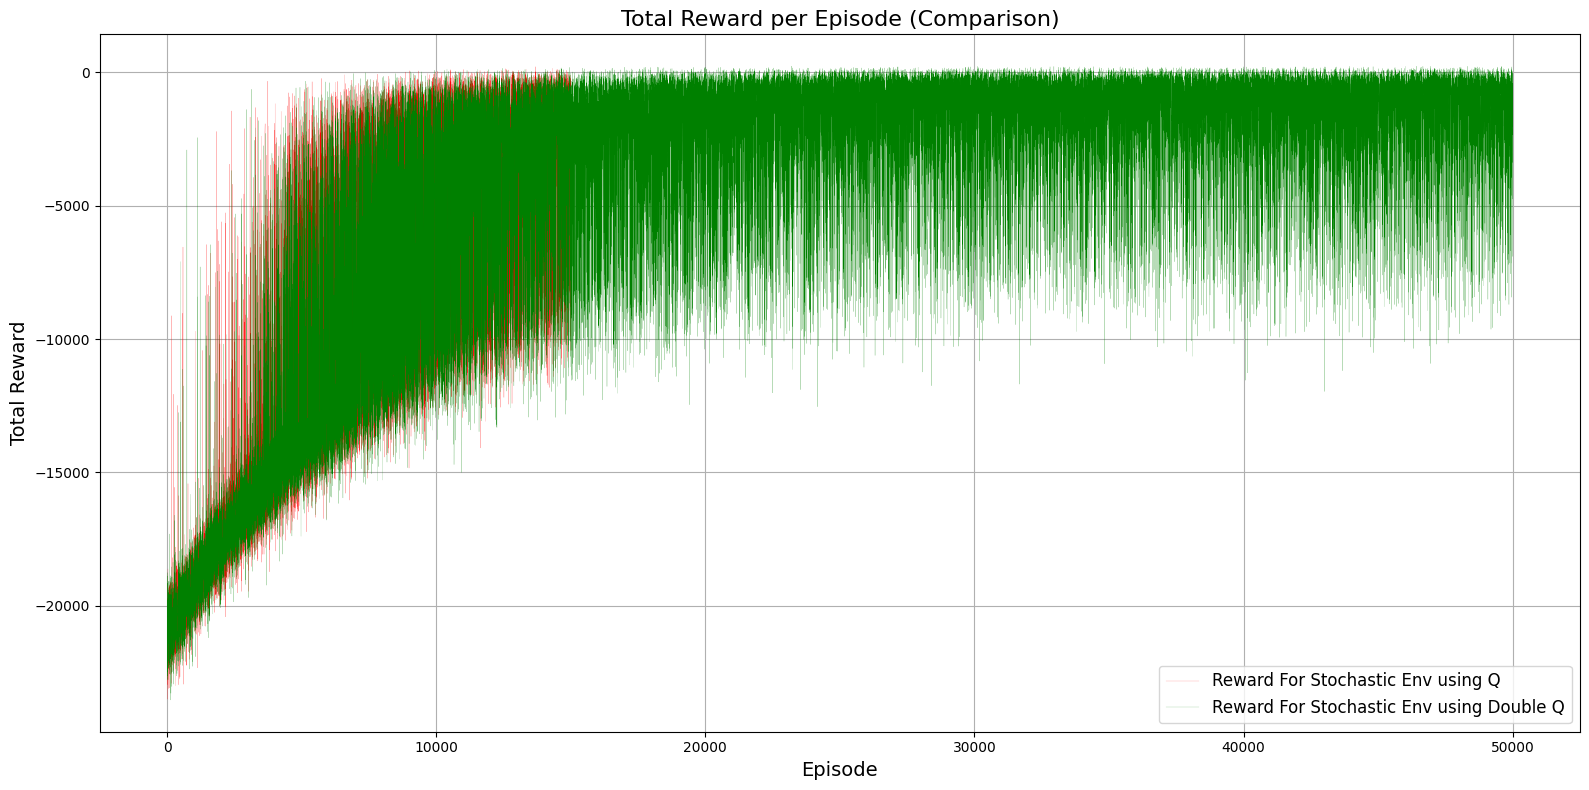

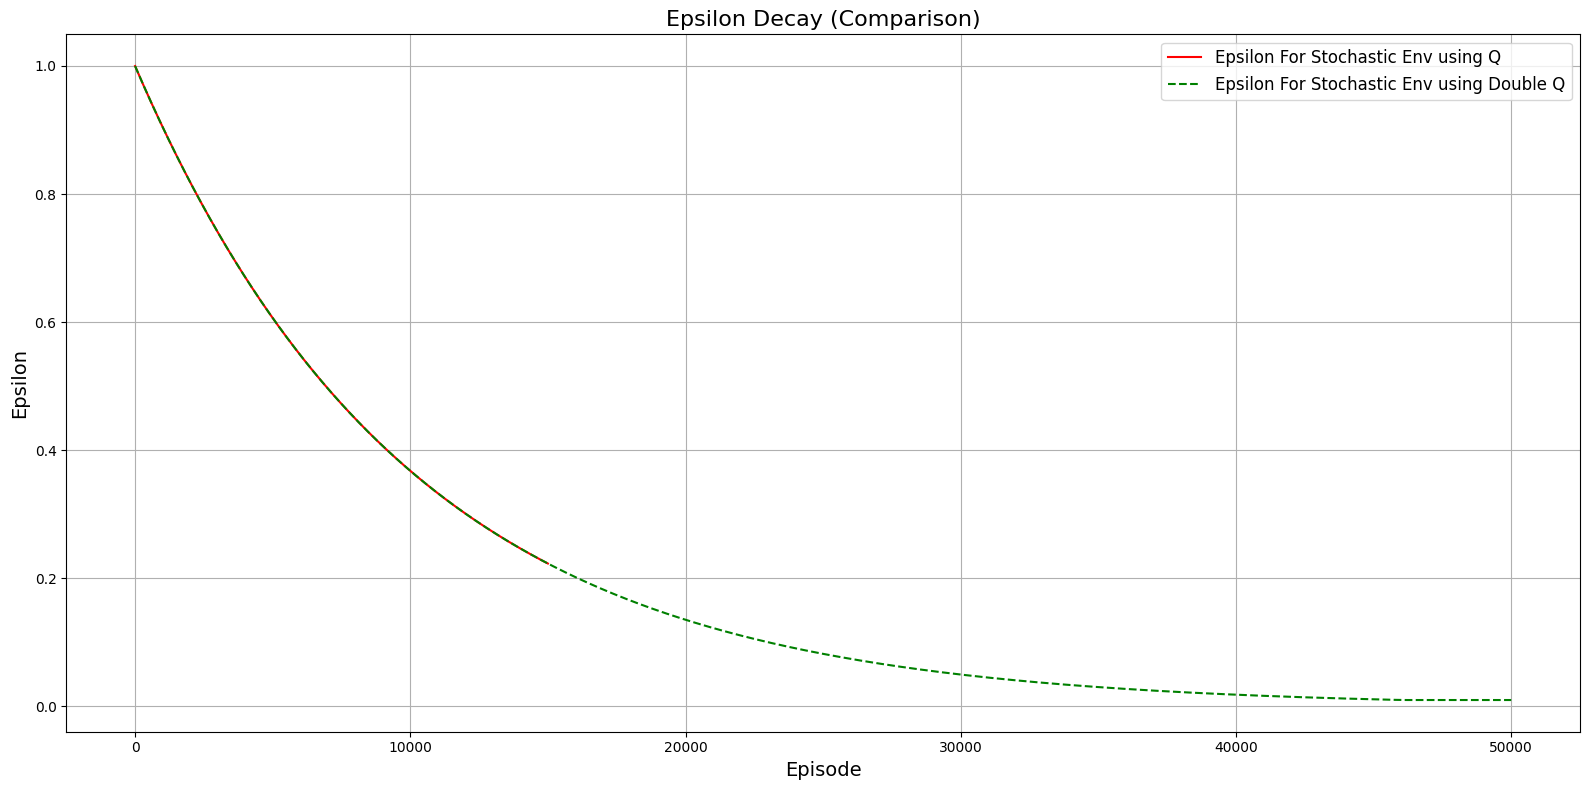

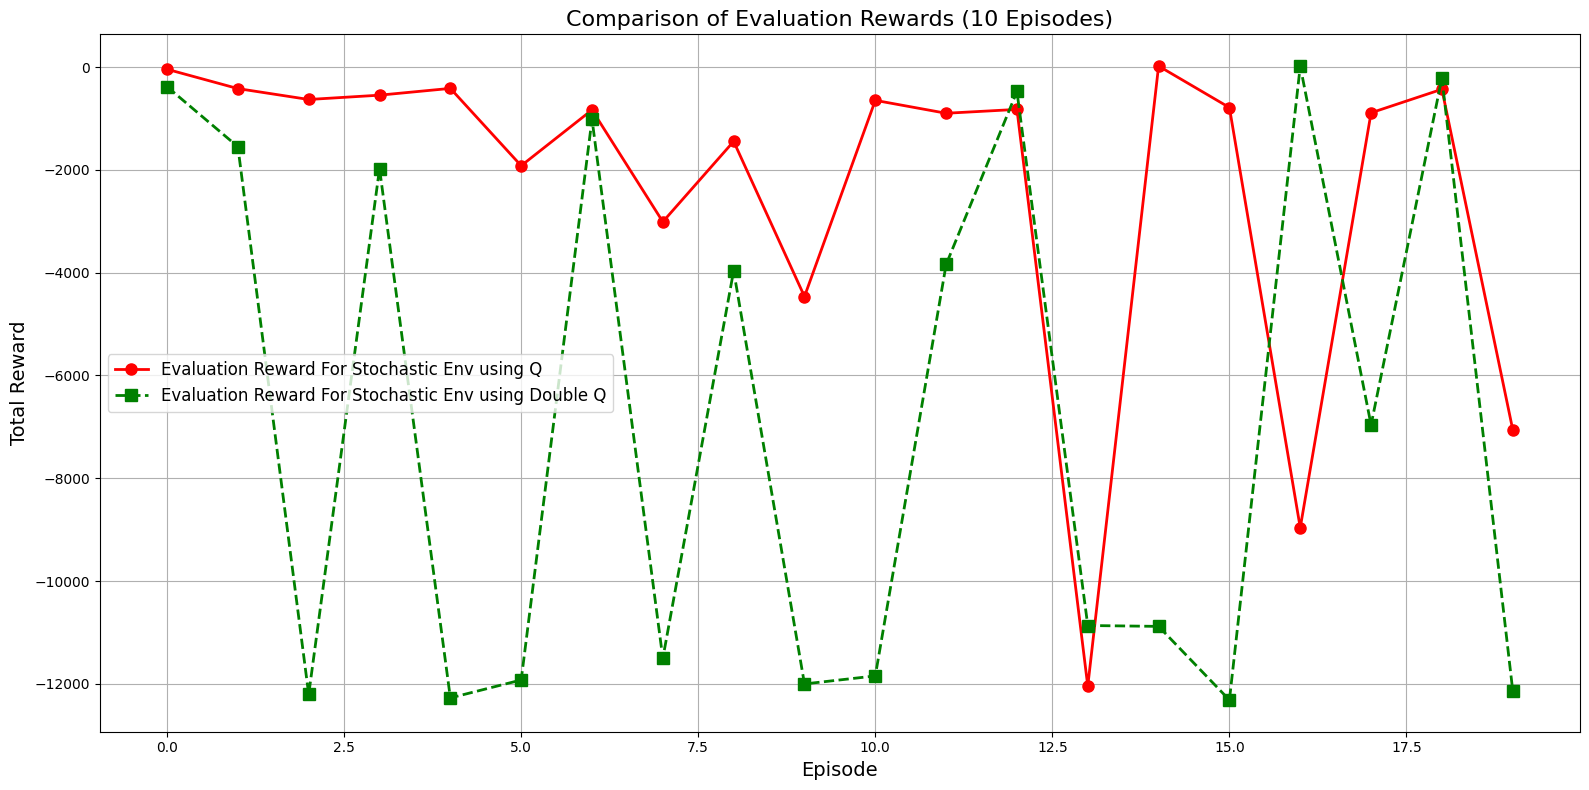

In [106]:
# --- Combined Graph for Total Reward per Episode ---

plt.figure(figsize=(16,8))
plt.plot(rewards_stochastic_Q, color='red', linewidth=.1, label='Reward For Stochastic Env using Q')
plt.plot(rewards_stochastic_DoubleQ, color='green', linewidth=.1,label='Reward For Stochastic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode (Comparison)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Combined Graph for Epsilon Decay ---

plt.figure(figsize=(16,8))
plt.plot(eps_history_stochastic_Q, color='red',linestyle='-', linewidth=1.5, label='Epsilon For Stochastic Env using Q')
plt.plot(eps_history_stochastic_DoubleQ, color='green', linestyle='--', linewidth=1.5, label='Epsilon For Stochastic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay (Comparison)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(evaluation_rewards_stochastic_Q, marker='o', linestyle='-', color='red', 
         markersize=8, linewidth=2, label='Evaluation Reward For Stochastic Env using Q')
plt.plot(evaluation_rewards_stochastic_DoubleQ, marker='s', linestyle='--', color='green', 
         markersize=8, linewidth=2, label='Evaluation Reward For Stochastic Env using Double Q')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Comparison of Evaluation Rewards (10 Episodes)", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()